In [1]:
# || Header ||
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy import fftpack
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import ipyvolume as ipv
from skimage import measure
import linecache
import math
import random
import sys
sys.path.append('/home/andy/py_scripts/')
import set_fxns
import sm_fxns as sm
import dimer_dissoc_analysis as lib
import plot_dimer_diss as plt_lib
import dimer_cavity as cav_lib
from importlib import reload
#%matplotlib inline
#plt.rcParams.update({'font.size': 14})
#plt.rcParams['figure.facecolor'] = 'white'

In [2]:
eVtokT = 1/(8.617333262145e-5 * 120)
unitl = 21.9166090280612
fkjmol = 189.100159648419

First half figure 2 of the solvent environments paper, which is generated by binning the energy gap during nonequilibrium dissociation and umbrella run dissociation while on both the ground state and excited state

Also goes into figure 3 of that paper which looks at how the environments change as the solute dissociates, both at equilibrium and nonequilibrium

In [3]:
def binDict(scalars, bond_dist, r0, r, dr):
    bins = np.round(np.arange(r0, r, dr) + dr/2, 3)
    my_dict = {}
    for i in bins:
        my_dict[str(i)] = []
    
    for i in range(len(scalars)):
        if bond_dist[i] < r0 or bond_dist[i] > r:
            continue
        else:
            my_ind = int((bond_dist[i]-r0)/dr)
            my_dict[str(np.round(r0+dr*my_ind+dr/2,3))] += [scalars[i]]
    
    return my_dict
def genDistr(my_array, spacing=0.1):
    low = int(min(my_array)/spacing)*spacing
    high = math.ceil(max(my_array)/spacing)*spacing
    bins = np.arange(low, high, spacing)
    counts = np.zeros([len(bins),3])
    
    for i in range(len(my_array)):
        counts[int((my_array[i]-low)/spacing),1] += 1
    norm = np.sum(counts[:,1])
    print(norm)
    counts[:,2] = np.sqrt((counts[:,1]/norm)*(1-counts[:,1]/norm)/norm)*1.96
    counts[:,1] /= norm
    counts[:,0] = bins + spacing/2
    
    return counts
def genFreeEnergy(pop_distr):
    e_distr = np.zeros([len(pop_distr),3])
    e_distr[:,0] = pop_distr[:,0]
    e_distr[:,1] = -np.log(pop_distr[:,1]/np.max(pop_distr[:,1]))/eVtokT
    my_ind = np.argwhere(pop_distr[:,1] == np.max(pop_distr[:,1]))[0][0]
    e_distr[:,2] = np.sqrt((pop_distr[:,2]/pop_distr[:,1])**2 + (pop_distr[my_ind,2]/pop_distr[my_ind,1])**2)/eVtokT
    return e_distr
def increasingBondDist(my_dir, tolerance = 0.1, r_stop = 9.0):
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')

    loc_max = bond_dist[0,1]
    my_ind = 0
    for i in range(1,len(bond_dist)):
        if bond_dist[i,1] > loc_max and bond_dist[i,1] < r_stop:
            loc_max = bond_dist[i,1]
            my_ind = i
        elif loc_max - bond_dist[i,1] > tolerance or bond_dist[i,1] > r_stop:
            break

    return bond_dist[:my_ind]

In [4]:
# egap fluctuations across full length range
# gas-phase eigvals as function of distance
gas_eigvals = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
gas_eigvals[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
for i in range(5):
    gas_eigvals[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1]
gas_eigvals = gas_eigvals[gas_eigvals[:,0].argsort()]

# gnd umbrella sampling
r0 = 3.6; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
bond_dist_gnd = np.zeros(1)
e_gap_gnd = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_gnd = np.append(bond_dist_gnd, np.loadtxt(my_dir+'/bondumb1.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_gnd = np.append(e_gap_gnd, eigvals[:,2] - eigvals[:,1])
bond_dist_gnd = np.delete(bond_dist_gnd, [0])
e_gap_gnd = np.delete(e_gap_gnd, [0])
e_gap_gnd = e_gap_gnd - np.interp(bond_dist_gnd, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_gnd = lib.binScalarsBondDist(e_gap_gnd, bond_dist_gnd, r0, r, dr)
gnd_dict = binDict(e_gap_gnd, bond_dist_gnd, r0, r, dr)

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
gnd_egap = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = gnd_dict[str(bins[i])]
    random.shuffle(a)
    gnd_egap[i*200:(i+1)*200] = a[:200]

# fes umbrella sampling
r0 = 3.6; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0',
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
bond_dist_fes = np.zeros(1)
e_gap_fes = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_fes = np.append(bond_dist_fes, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_fes = np.append(e_gap_fes, eigvals[:,2] - eigvals[:,1])
bond_dist_fes = np.delete(bond_dist_fes, [0])
e_gap_fes = np.delete(e_gap_fes, [0])
e_gap_fes = e_gap_fes - np.interp(bond_dist_fes, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_fes = lib.binScalarsBondDist(e_gap_fes, bond_dist_fes, r0, r, dr)
fes_dict = binDict(e_gap_fes, bond_dist_fes, r0, r, dr)

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
fes_egap = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = fes_dict[str(bins[i])]
    random.shuffle(a)
    fes_egap[i*200:(i+1)*200] = a[:200]
    
# from noneqb, dissociation traj
r0 = 3.6; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/'
dirs = np.arange(1,101,1)
bond_dist_diss = np.zeros(1)
e_gap_diss = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+str(dirs[i])+'/1/'
    my_bond_dist = increasingBondDist(my_dir)
    bond_dist_diss = np.append(bond_dist_diss, my_bond_dist[:,1])
    eigvals = lib.readEigval(my_dir, nstates=2)[:len(my_bond_dist),:]
    e_gap_diss = np.append(e_gap_diss, eigvals[:,2] - eigvals[:,1])
bond_dist_diss = np.delete(bond_dist_diss, [0])
e_gap_diss = np.delete(e_gap_diss, [0])
e_gap_diss = e_gap_diss - np.interp(bond_dist_diss, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_diss = lib.binScalarsBondDist(e_gap_diss, bond_dist_diss, r0, r, dr)

diss_dict = binDict(e_gap_diss, bond_dist_diss, r0, r, dr)
norm_count = min([len(diss_dict[i]) for i in diss_dict.keys()])

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
diss_egap = np.zeros(len(bins)*norm_count)
for i in range(len(bins)):
    a = diss_dict[str(bins[i])]
    random.shuffle(a)
    diss_egap[i*norm_count:(i+1)*norm_count] = a[:norm_count]

10800.0
10800.0
4482.0


/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


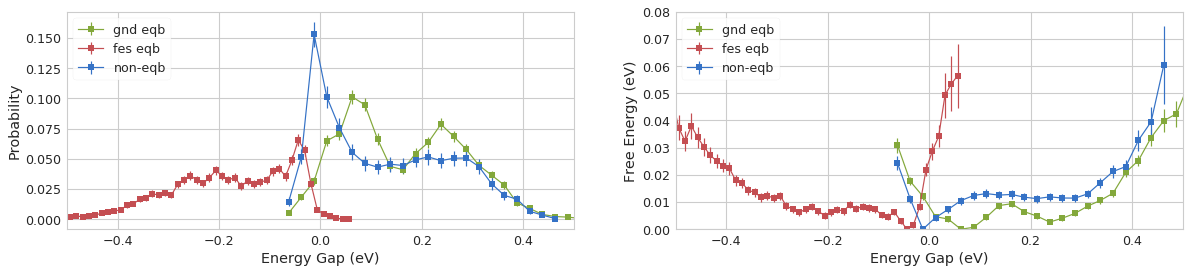

In [55]:
# full range of bond lengths
s = 0.025
distr_gnd = genDistr(gnd_egap, spacing=s); e_gnd = genFreeEnergy(distr_gnd)
distr_fes = genDistr(fes_egap, spacing=s/2); e_fes = genFreeEnergy(distr_fes)
distr_diss = genDistr(diss_egap, spacing=s); e_diss = genFreeEnergy(distr_diss)
# distr_red_m = genDistr(red_m_egap, spacing=s); e_red_m = genFreeEnergy(distr_red_m)
# distr_inc_m = genDistr(inc_m_egap, spacing=s); e_inc_m = genFreeEnergy(distr_inc_m)
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_gnd[:,0], distr_gnd[:,1], yerr=distr_gnd[:,2], color='C1',marker='s', label='gnd eqb')
plt.errorbar(distr_fes[:,0], distr_fes[:,1], yerr=distr_fes[:,2], color='C2', marker='s', label='fes eqb')
plt.errorbar(distr_diss[:,0], distr_diss[:,1], yerr=distr_diss[:,2], color='C0', marker='s', label='non-eqb')
# plt.errorbar(distr_red_m[:,0], distr_red_m[:,1], yerr=distr_red_m[:,2], color='C3', marker='s', label='red m')
# plt.errorbar(distr_inc_m[:,0], distr_inc_m[:,1], yerr=distr_inc_m[:,2], color='C4', marker='s', label='inc m')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.subplot(1,2,2)
plt.errorbar(e_gnd[:,0], e_gnd[:,1], yerr=e_gnd[:,2], marker='s', color='C1', label='gnd eqb')
plt.errorbar(e_fes[:,0], e_fes[:,1], yerr=e_fes[:,2], marker='s', color='C2', label='fes eqb')
plt.errorbar(e_diss[:,0], e_diss[:,1], yerr=e_diss[:,2], marker='s', color='C0', label='non-eqb')
# plt.errorbar(e_red_m[:,0], e_red_m[:,1], yerr=e_red_m[:,2], marker='s', color='C3', label='red m')
# plt.errorbar(e_inc_m[:,0], e_inc_m[:,1], yerr=e_inc_m[:,2], marker='s', color='C4', label='inc m')
plt.xlim([-0.5,0.5])
plt.ylim([0,0.08])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)

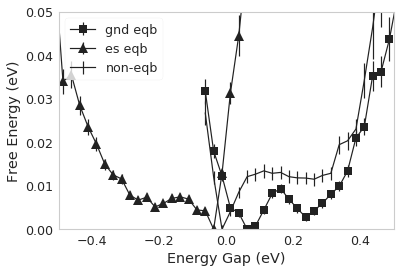

In [7]:
# cleaning up for Proposal
plt.figure(figsize=(6,4))
plt.errorbar(e_gnd[:,0], e_gnd[:,1], yerr=e_gnd[:,2], marker='s', ms=8, color='k', label='gnd eqb')
plt.errorbar(e_fes[:,0], e_fes[:,1], yerr=e_fes[:,2], marker='^', ms=10, color='k', label='es eqb')
plt.errorbar(e_diss[:,0], e_diss[:,1], yerr=e_diss[:,2], color='k', label='non-eqb')
# plt.errorbar(e_red_m[:,0], e_red_m[:,1], yerr=e_red_m[:,2], marker='s', color='C3', label='red m')
# plt.errorbar(e_inc_m[:,0], e_inc_m[:,1], yerr=e_inc_m[:,2], marker='s', color='C4', label='inc m')
plt.xlim([-0.5,0.5])
plt.ylim([0,0.05])
plt.xlabel('Energy Gap (eV)', size='x-large')
plt.ylabel('Free Energy (eV)', size='x-large')
plt.legend(loc=2)
plt.grid(False)
plt.savefig('energy_gap_distr.png', format='png')

### Fitting both equilibrium (ground and excited state) and nonequilibrium profiles to series of Gaussians

In [6]:
def gaussian(x, mu, sigma, a):
    return a/(sigma*np.sqrt(np.pi)) * np.exp(-0.5*(x-mu)**2/sigma**2)
def doubleGaussian(x, mu1=0.07, mu2=0.24, sigma1=0.05, sigma2=0.06, a=0.012, b=0.008):
    return gaussian(x, mu1, sigma1, a) + gaussian(x, mu2, sigma2, b)
def quadGaussian(x, mu0, mu1, mu2, mu3, sigma0, sigma1, sigma2, sigma3, a0, a1, a2, a3):
    return gaussian(x,mu0,sigma0,a0)+gaussian(x,mu1,sigma1,a1)+gaussian(x,mu2,sigma2,a2)+\
        gaussian(x,mu3,sigma3,a3)

In [7]:
# figuring out the range of bond lengths that correspond to either gaussians gnd eqb
# gas-phase eigvals as function of distance
gas_eigvals = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
gas_eigvals[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
for i in range(5):
    gas_eigvals[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1]
gas_eigvals = gas_eigvals[gas_eigvals[:,0].argsort()]

# gnd umbrella sampling
# FC/pre-caging
r0 = 3.6; r = 5.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
bond_dist_gnd = np.zeros(1)
e_gap_gnd_fc = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_gnd = np.append(bond_dist_gnd, np.loadtxt(my_dir+'/bondumb1.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_gnd_fc = np.append(e_gap_gnd_fc, eigvals[:,2] - eigvals[:,1])
bond_dist_gnd = np.delete(bond_dist_gnd, [0])
e_gap_gnd_fc = np.delete(e_gap_gnd_fc, [0])
e_gap_gnd_fc = e_gap_gnd_fc - np.interp(bond_dist_gnd, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_gnd = lib.binScalarsBondDist(e_gap_gnd_fc, bond_dist_gnd, r0, r, dr)
gnd_dict_fc = binDict(e_gap_gnd_fc, bond_dist_gnd, r0, r, dr)

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
gnd_egap_fc = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = gnd_dict_fc[str(bins[i])]
    random.shuffle(a)
    gnd_egap_fc[i*200:(i+1)*200] = a[:200]

# caging/post-caging
r0 = 5.0; r = 7.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
bond_dist_gnd = np.zeros(1)
e_gap_gnd_cage = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_gnd = np.append(bond_dist_gnd, np.loadtxt(my_dir+'/bondumb1.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_gnd_cage = np.append(e_gap_gnd_cage, eigvals[:,2] - eigvals[:,1])
bond_dist_gnd = np.delete(bond_dist_gnd, [0])
e_gap_gnd_cage = np.delete(e_gap_gnd_cage, [0])
e_gap_gnd_cage = e_gap_gnd_cage - np.interp(bond_dist_gnd, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_gnd = lib.binScalarsBondDist(e_gap_gnd_cage, bond_dist_gnd, r0, r, dr)
gnd_dict_cage = binDict(e_gap_gnd_cage, bond_dist_gnd, r0, r, dr)

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
gnd_egap_cage = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = gnd_dict_cage[str(bins[i])]
    random.shuffle(a)
    gnd_egap_cage[i*200:(i+1)*200] = a[:200]

# localization
r0 = 7.0; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
bond_dist_gnd = np.zeros(1)
e_gap_gnd_loc = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_gnd = np.append(bond_dist_gnd, np.loadtxt(my_dir+'/bondumb1.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_gnd_loc = np.append(e_gap_gnd_loc, eigvals[:,2] - eigvals[:,1])
bond_dist_gnd = np.delete(bond_dist_gnd, [0])
e_gap_gnd_loc = np.delete(e_gap_gnd_loc, [0])
e_gap_gnd_loc = e_gap_gnd_loc - np.interp(bond_dist_gnd, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_gnd = lib.binScalarsBondDist(e_gap_gnd_loc, bond_dist_gnd, r0, r, dr)
gnd_dict_loc = binDict(e_gap_gnd_loc, bond_dist_gnd, r0, r, dr)

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
gnd_egap_loc = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = gnd_dict_loc[str(bins[i])]
    random.shuffle(a)
    gnd_egap_loc[i*200:(i+1)*200] = a[:200]

2800.0
4000.0
4000.0


/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


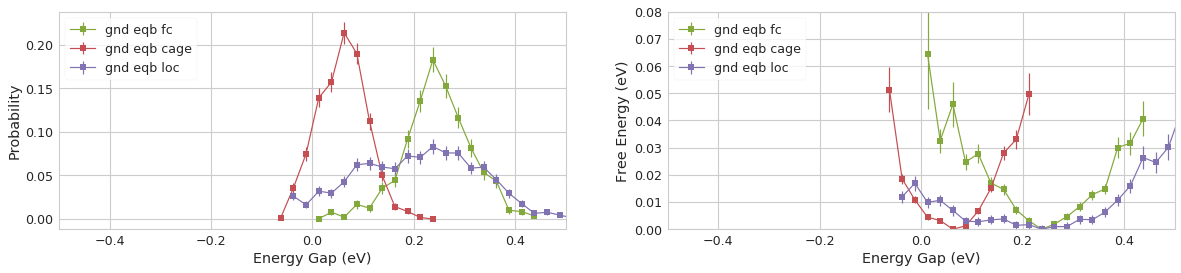

In [8]:
# partial range of bond lengths [3.6, 5.0] [5.0, 7.0], [7.0, 9.0]
s = 0.025
distr_gnd_fc = genDistr(gnd_egap_fc, spacing=s); e_gnd_fc = genFreeEnergy(distr_gnd_fc)
distr_gnd_cage = genDistr(gnd_egap_cage, spacing=s); e_gnd_cage = genFreeEnergy(distr_gnd_cage)
distr_gnd_loc = genDistr(gnd_egap_loc, spacing=s); e_gnd_loc = genFreeEnergy(distr_gnd_loc)

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_gnd_fc[:,0], distr_gnd_fc[:,1], yerr=distr_gnd_fc[:,2], color='C1',marker='s', label='gnd eqb fc')
plt.errorbar(distr_gnd_cage[:,0], distr_gnd_cage[:,1], yerr=distr_gnd_cage[:,2], color='C2',marker='s', label='gnd eqb cage')
plt.errorbar(distr_gnd_loc[:,0], distr_gnd_loc[:,1], yerr=distr_gnd_loc[:,2], color='C3', marker='s', label='gnd eqb loc')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.subplot(1,2,2)
plt.errorbar(e_gnd_fc[:,0], e_gnd_fc[:,1], yerr=e_gnd_fc[:,2], marker='s', color='C1', label='gnd eqb fc')
plt.errorbar(e_gnd_cage[:,0], e_gnd_cage[:,1], yerr=e_gnd_cage[:,2], marker='s', color='C2', label='gnd eqb cage')
plt.errorbar(e_gnd_loc[:,0], e_gnd_loc[:,1], yerr=e_gnd_loc[:,2], marker='s', color='C3', label='gnd eqb loc')
plt.xlim([-0.5,0.5])
plt.ylim([0,0.08])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)

In [9]:
# fitting to three gaussians, with ranges [3.6, 5.0], [5.0, 7.0], [7.0, 9.0]
popt1, pcov1 = curve_fit(gaussian, distr_gnd_fc[:,0], distr_gnd_fc[:,1], p0=[0.23, 0.07, 0.05], bounds=(0, 0.5))
popt2, pcov2 = curve_fit(gaussian, distr_gnd_cage[:,0], distr_gnd_cage[:,1], p0=[0.07, 0.07, 0.05], bounds=(0, 0.4))
popt3, pcov3 = curve_fit(gaussian, distr_gnd_loc[:,0], distr_gnd_loc[:,1], p0=[0.24, 0.14, 0.05], bounds=(0, 0.5))
gauss_gnd_fc = np.array([distr_gnd_fc[:,0], gaussian(distr_gnd_fc[:,0], *popt1), np.ones(len(distr_gnd_fc[:,0]))]).T
gauss_gnd_cage = np.array([distr_gnd_cage[:,0], gaussian(distr_gnd_cage[:,0], *popt2), np.ones(len(distr_gnd_cage[:,0]))]).T
gauss_gnd_loc = np.array([distr_gnd_loc[:,0], gaussian(distr_gnd_loc[:,0], *popt3), np.ones(len(distr_gnd_loc[:,0]))]).T
gnd_energy_fit1 = genFreeEnergy(gauss_gnd_fc)
gnd_energy_fit2 = genFreeEnergy(gauss_gnd_cage)
gnd_energy_fit3 = genFreeEnergy(gauss_gnd_loc)
print(popt1)
print(popt2)
print(popt3)

[0.24720216 0.05864871 0.01697969]
[0.06002978 0.04886202 0.01783278]
[0.20985532 0.13360331 0.01844669]


In [10]:
print('root mean square fluctuation = [' + str(np.round(popt1[1]*1000, 4))+', '+
      str(np.round(popt2[1]*1000, 4))+', '+str(np.round(popt3[1]*1000, 4))+']')

root mean square fluctuation = [58.6487, 48.862, 133.6033]


In [11]:
print('curvature = '+'['+str(np.round((8.617333262145e-5 * 120)/(2*popt1[1]**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*popt2[1]**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*popt3[1]**2), 4))+']')

curvature = [1.5032, 2.1656, 0.2897]


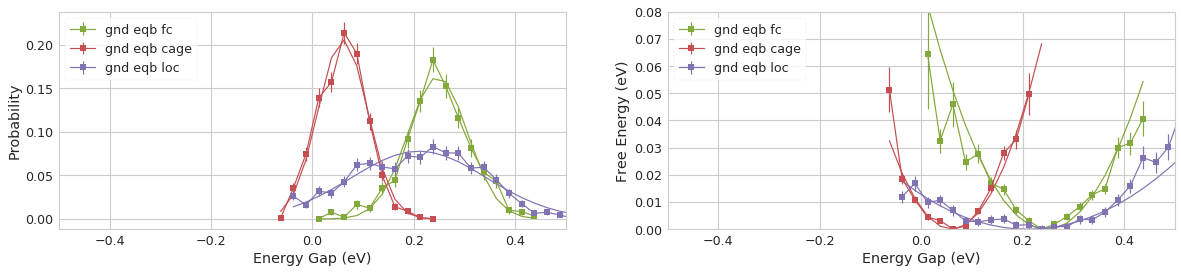

In [12]:
# partial range of bond lengths [3.6, 5.0] for fc region
s = 0.025
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_gnd_fc[:,0], distr_gnd_fc[:,1], yerr=distr_gnd_fc[:,2], color='C1',marker='s', label='gnd eqb fc')
plt.errorbar(distr_gnd_cage[:,0], distr_gnd_cage[:,1], yerr=distr_gnd_cage[:,2], color='C2',marker='s', label='gnd eqb cage')
plt.errorbar(distr_gnd_loc[:,0], distr_gnd_loc[:,1], yerr=distr_gnd_loc[:,2], color='C3', marker='s', label='gnd eqb loc')
plt.plot(gauss_gnd_fc[:,0], gauss_gnd_fc[:,1], 'C1')
plt.plot(gauss_gnd_cage[:,0], gauss_gnd_cage[:,1], 'C2')
plt.plot(gauss_gnd_loc[:,0], gauss_gnd_loc[:,1], 'C3')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.subplot(1,2,2)
plt.errorbar(e_gnd_fc[:,0], e_gnd_fc[:,1], yerr=e_gnd_fc[:,2], marker='s', color='C1', label='gnd eqb fc')
plt.errorbar(e_gnd_cage[:,0], e_gnd_cage[:,1], yerr=e_gnd_cage[:,2], marker='s', color='C2', label='gnd eqb cage')
plt.errorbar(e_gnd_loc[:,0], e_gnd_loc[:,1], yerr=e_gnd_loc[:,2], marker='s', color='C3', label='gnd eqb loc')
plt.plot(gnd_energy_fit1[:,0], gnd_energy_fit1[:,1], 'C1')
plt.plot(gnd_energy_fit2[:,0], gnd_energy_fit2[:,1], 'C2')
plt.plot(gnd_energy_fit3[:,0], gnd_energy_fit3[:,1], 'C3')
plt.xlim([-0.5,0.5])
plt.ylim([0,0.08])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)

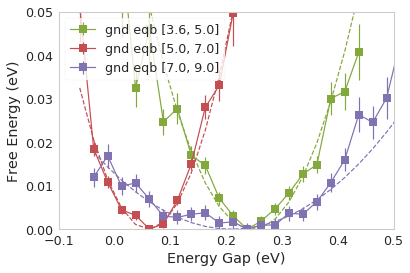

In [13]:
# cleaning up for Proposal
plt.figure(figsize=(6,4))
plt.errorbar(e_gnd_fc[:,0], e_gnd_fc[:,1], yerr=e_gnd_fc[:,2], marker='s', ms='8', color='C1', label='gnd eqb [3.6, 5.0]')
plt.errorbar(e_gnd_cage[:,0], e_gnd_cage[:,1], yerr=e_gnd_cage[:,2], marker='s', ms='8', color='C2', label='gnd eqb [5.0, 7.0]')
plt.errorbar(e_gnd_loc[:,0], e_gnd_loc[:,1], yerr=e_gnd_loc[:,2], marker='s', ms='8', color='C3', label='gnd eqb [7.0, 9.0]')
plt.plot(gnd_energy_fit1[:,0], gnd_energy_fit1[:,1], '--C1')
plt.plot(gnd_energy_fit2[:,0], gnd_energy_fit2[:,1], '--C2')
plt.plot(gnd_energy_fit3[:,0], gnd_energy_fit3[:,1], '--C3')
plt.xlim([-0.1,0.5])
plt.ylim([0,0.05])
plt.xlabel('Energy Gap (eV)', size='x-large')
plt.ylabel('Free Energy (eV)', size='x-large')
plt.legend(loc=2)
plt.grid(False)
plt.savefig('gnd_distr_fits.eps', format='eps')

Fitting fes eqb to two gaussians

In [47]:
# figuring out the range of bond lengths that correspond to either gaussians fes eqb
# gas-phase eigvals as function of distance
gas_eigvals = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
gas_eigvals[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
for i in range(5):
    gas_eigvals[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1]
gas_eigvals = gas_eigvals[gas_eigvals[:,0].argsort()]

# fes umbrella sampling
# 1
r0 = 3.6; r = 5.8; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', 
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
bond_dist_fes = np.zeros(1)
e_gap_fes_1 = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_fes = np.append(bond_dist_fes, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_fes_1 = np.append(e_gap_fes_1, eigvals[:,2] - eigvals[:,1])
bond_dist_fes = np.delete(bond_dist_fes, [0])
e_gap_fes_1 = np.delete(e_gap_fes_1, [0])
e_gap_fes_1 = e_gap_fes_1 - np.interp(bond_dist_fes, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_fes = lib.binScalarsBondDist(e_gap_fes_1, bond_dist_fes, r0, r, dr)
fes_dict_1 = binDict(e_gap_fes_1, bond_dist_fes, r0, r, dr)

bins = np.round(np.arange(r0, r-dr, dr)+dr/2, 3)
fes_egap_1 = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = fes_dict_1[str(bins[i])]
    random.shuffle(a)
    fes_egap_1[i*200:(i+1)*200] = a[:200]
    
# 2
r0 = 5.8; r = 6.9; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', 
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
bond_dist_fes = np.zeros(1)
e_gap_fes_2 = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_fes = np.append(bond_dist_fes, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_fes_2 = np.append(e_gap_fes_2, eigvals[:,2] - eigvals[:,1])
bond_dist_fes = np.delete(bond_dist_fes, [0])
e_gap_fes_2 = np.delete(e_gap_fes_2, [0])
e_gap_fes_2 = e_gap_fes_2 - np.interp(bond_dist_fes, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_fes = lib.binScalarsBondDist(e_gap_fes_2, bond_dist_fes, r0, r, dr)
fes_dict_2 = binDict(e_gap_fes_2, bond_dist_fes, r0, r, dr)

bins = np.round(np.arange(r0, r-dr, dr)+dr/2, 3)
fes_egap_2 = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = fes_dict[str(bins[i])]
    random.shuffle(a)
    fes_egap_2[i*200:(i+1)*200] = a[:200]

# 3
r0 = 6.9; r = 7.6; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', 
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
bond_dist_fes = np.zeros(1)
e_gap_fes_3 = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_fes = np.append(bond_dist_fes, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_fes_3 = np.append(e_gap_fes_3, eigvals[:,2] - eigvals[:,1])
bond_dist_fes = np.delete(bond_dist_fes, [0])
e_gap_fes_3 = np.delete(e_gap_fes_3, [0])
e_gap_fes_3 = e_gap_fes_3 - np.interp(bond_dist_fes, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_fes = lib.binScalarsBondDist(e_gap_fes_3, bond_dist_fes, r0, r, dr)
fes_dict_3 = binDict(e_gap_fes_3, bond_dist_fes, r0, r, dr)

bins = np.round(np.arange(r0, r-dr, dr)+dr/2, 3)
fes_egap_3 = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = fes_dict[str(bins[i])]
    random.shuffle(a)
    fes_egap_3[i*200:(i+1)*200] = a[:200]

# 4
r0 = 7.6; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', 
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
bond_dist_fes = np.zeros(1)
e_gap_fes_4 = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    bond_dist_fes = np.append(bond_dist_fes, np.loadtxt(my_dir+'/bondumb2.out')[500:,1])
    eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    e_gap_fes_4 = np.append(e_gap_fes_4, eigvals[:,2] - eigvals[:,1])
bond_dist_fes = np.delete(bond_dist_fes, [0])
e_gap_fes_4 = np.delete(e_gap_fes_4, [0])
e_gap_fes_4 = e_gap_fes_4 - np.interp(bond_dist_fes, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

binned_gap_fes = lib.binScalarsBondDist(e_gap_fes_4, bond_dist_fes, r0, r, dr)
fes_dict_4 = binDict(e_gap_fes_4, bond_dist_fes, r0, r, dr)

bins = np.round(np.arange(r0, r-dr, dr)+dr/2, 3)
fes_egap_4 = np.zeros(len(bins)*200)
for i in range(len(bins)):
    a = fes_dict[str(bins[i])]
    random.shuffle(a)
    fes_egap_4[i*200:(i+1)*200] = a[:200]

/home/andy/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4200.0
2200.0
1200.0
2800.0


/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


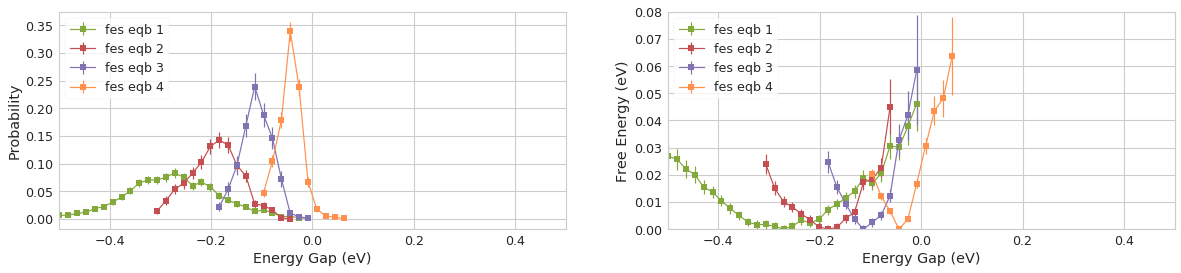

In [48]:
# partial range of bond lengths [3.6, 5.8] and [5.8, 6.9] and [6.9, 7.6] and [7.6, 9.0]
s = 0.0175
distr_fes_1 = genDistr(fes_egap_1, spacing=s); e_fes_1 = genFreeEnergy(distr_fes_1)
distr_fes_2 = genDistr(fes_egap_2, spacing=s); e_fes_2 = genFreeEnergy(distr_fes_2)
distr_fes_3 = genDistr(fes_egap_3, spacing=s); e_fes_3 = genFreeEnergy(distr_fes_3)
distr_fes_4 = genDistr(fes_egap_4, spacing=s); e_fes_4 = genFreeEnergy(distr_fes_4)
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_fes_1[:,0], distr_fes_1[:,1], yerr=distr_fes_1[:,2], color='C1',marker='s', label='fes eqb 1')
plt.errorbar(distr_fes_2[:,0], distr_fes_2[:,1], yerr=distr_fes_2[:,2], color='C2',marker='s', label='fes eqb 2')
plt.errorbar(distr_fes_3[:,0], distr_fes_3[:,1], yerr=distr_fes_3[:,2], color='C3',marker='s', label='fes eqb 3')
plt.errorbar(distr_fes_4[:,0], distr_fes_4[:,1], yerr=distr_fes_4[:,2], color='C4',marker='s', label='fes eqb 4')
#plt.plot(fc_fes_gauss[:,0], fc_fes_gauss[:,1]/np.max(fc_fes_gauss[:,1])*np.max(distr_fes_1[:,1]), 'C3')
#plt.plot(cage_fes_gauss[:,0], cage_fes_gauss[:,1]/np.max(cage_fes_gauss[:,1])*np.max(distr_fes_2[:,1]), 'C4')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.subplot(1,2,2)
plt.errorbar(e_fes_1[:,0], e_fes_1[:,1], yerr=e_fes_1[:,2], marker='s', color='C1', label='fes eqb 1')
plt.errorbar(e_fes_2[:,0], e_fes_2[:,1], yerr=e_fes_2[:,2], marker='s', color='C2', label='fes eqb 2')
plt.errorbar(e_fes_3[:,0], e_fes_3[:,1], yerr=e_fes_3[:,2], marker='s', color='C3', label='fes eqb 3')
plt.errorbar(e_fes_4[:,0], e_fes_4[:,1], yerr=e_fes_4[:,2], marker='s', color='C4', label='fes eqb 4')
#plt.plot(fes_energy_fit1[:,0], fes_energy_fit1[:,1], 'C3')
#plt.plot(fes_energy_fit2[:,0], fes_energy_fit2[:,1], 'C4')
plt.xlim([-0.5,0.5])
plt.ylim([0,0.08])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)

In [49]:
# fitting to three gaussians, with ranges [3.6, 5.8], [5.8, 6.9], [6.9, 7.6], and [7.6, 9.0]
popt1, pcov1 = curve_fit(gaussian, distr_fes_1[:,0], distr_fes_1[:,1], p0=[-0.3, 0.07, 0.05], bounds=(-0.4, 0.4))
popt2, pcov2 = curve_fit(gaussian, distr_fes_2[:,0], distr_fes_2[:,1], p0=[-0.2, 0.07, 0.05], bounds=(-0.4, 0.4))
popt3, pcov3 = curve_fit(gaussian, distr_fes_3[:,0], distr_fes_3[:,1], p0=[-0.1, 0.14, 0.05], bounds=(-0.4, 0.4))
popt4, pcov4 = curve_fit(gaussian, distr_fes_4[:,0], distr_fes_4[:,1], p0=[-0.1, 0.14, 0.05], bounds=(-0.4, 0.4))
gauss_fes1 = np.array([distr_fes_1[:,0], gaussian(distr_fes_1[:,0], *popt1), np.ones(len(distr_fes_1[:,0]))]).T
gauss_fes2 = np.array([distr_fes_2[:,0], gaussian(distr_fes_2[:,0], *popt2), np.ones(len(distr_fes_2[:,0]))]).T
gauss_fes3 = np.array([distr_fes_3[:,0], gaussian(distr_fes_3[:,0], *popt3), np.ones(len(distr_fes_3[:,0]))]).T
gauss_fes4 = np.array([distr_fes_4[:,0], gaussian(distr_fes_4[:,0], *popt4), np.ones(len(distr_fes_4[:,0]))]).T
fes_energy_fit1 = genFreeEnergy(gauss_fes1)
fes_energy_fit2 = genFreeEnergy(gauss_fes2)
fes_energy_fit3 = genFreeEnergy(gauss_fes3)
fes_energy_fit4 = genFreeEnergy(gauss_fes4)
print(popt1)
print(popt2)
print(popt3)
print(popt4)

[-0.27667336  0.08973637  0.01229948]
[-0.19019405  0.05180898  0.01245678]
[-0.10980734  0.03131944  0.01242297]
[-0.04274056  0.02086942  0.01184021]


In [50]:
print('root mean square fluctuation = [' + str(np.round(popt1[1]*1000, 4))+', '+
      str(np.round(popt2[1]*1000, 4))+', '+str(np.round(popt3[1]*1000, 4))+', '+
      str(np.round(popt4[1]*1000, 4))+']')

root mean square fluctuation = [89.7364, 51.809, 31.3194, 20.8694]


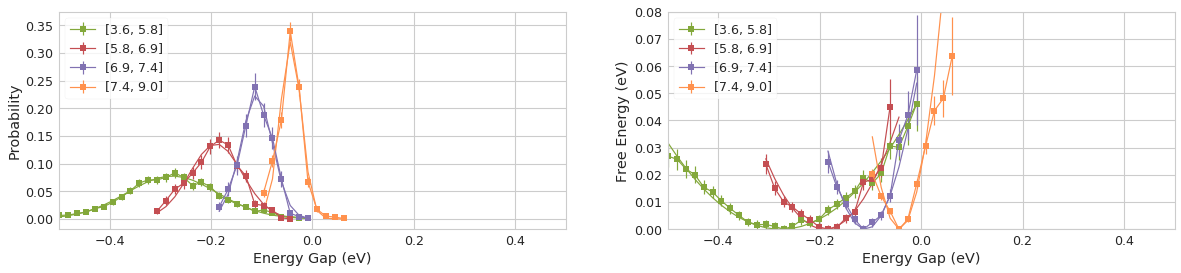

In [51]:
# partial range of bond lengths
s = 0.025
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_fes_1[:,0], distr_fes_1[:,1], yerr=distr_fes_1[:,2], color='C1',marker='s', label='[3.6, 5.8]')
plt.errorbar(distr_fes_2[:,0], distr_fes_2[:,1], yerr=distr_fes_2[:,2], color='C2',marker='s', label='[5.8, 6.9]')
plt.errorbar(distr_fes_3[:,0], distr_fes_3[:,1], yerr=distr_fes_3[:,2], color='C3',marker='s', label='[6.9, 7.4]')
plt.errorbar(distr_fes_4[:,0], distr_fes_4[:,1], yerr=distr_fes_4[:,2], color='C4',marker='s', label='[7.4, 9.0]')
plt.plot(gauss_fes1[:,0], gauss_fes1[:,1], 'C1')
plt.plot(gauss_fes2[:,0], gauss_fes2[:,1], 'C2')
plt.plot(gauss_fes3[:,0], gauss_fes3[:,1], 'C3')
plt.plot(gauss_fes4[:,0], gauss_fes4[:,1], 'C4')
plt.xlim([-0.5,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)
plt.subplot(1,2,2)
plt.errorbar(e_fes_1[:,0], e_fes_1[:,1], yerr=e_fes_1[:,2], marker='s', color='C1', label='[3.6, 5.8]')
plt.errorbar(e_fes_2[:,0], e_fes_2[:,1], yerr=e_fes_2[:,2], marker='s', color='C2', label='[5.8, 6.9]')
plt.errorbar(e_fes_3[:,0], e_fes_3[:,1], yerr=e_fes_3[:,2], marker='s', color='C3', label='[6.9, 7.4]')
plt.errorbar(e_fes_4[:,0], e_fes_4[:,1], yerr=e_fes_4[:,2], marker='s', color='C4', label='[7.4, 9.0]')
plt.plot(fes_energy_fit1[:,0], fes_energy_fit1[:,1], 'C1')
plt.plot(fes_energy_fit2[:,0], fes_energy_fit2[:,1], 'C2')
plt.plot(fes_energy_fit3[:,0], fes_energy_fit3[:,1], 'C3')
plt.plot(fes_energy_fit4[:,0], fes_energy_fit4[:,1], 'C4')
plt.xlim([-0.5,0.5])
plt.ylim([0,0.08])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)

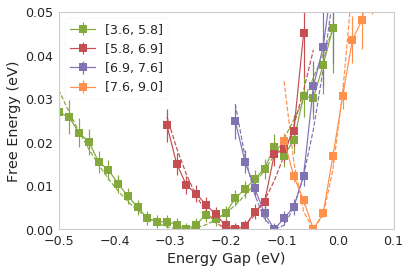

In [52]:
# cleaning up for fes eqb
plt.figure(figsize=(6,4))
plt.errorbar(e_fes_1[:,0], e_fes_1[:,1], yerr=e_fes_1[:,2], marker='s', ms='8', color='C1', label='[3.6, 5.8]')
plt.errorbar(e_fes_2[:,0], e_fes_2[:,1], yerr=e_fes_2[:,2], marker='s', ms='8', color='C2', label='[5.8, 6.9]')
plt.errorbar(e_fes_3[:,0], e_fes_3[:,1], yerr=e_fes_3[:,2], marker='s', ms='8', color='C3', label='[6.9, 7.6]')
plt.errorbar(e_fes_4[:,0], e_fes_4[:,1], yerr=e_fes_4[:,2], marker='s', ms='8', color='C4', label='[7.6, 9.0]')
plt.plot(fes_energy_fit1[:,0], fes_energy_fit1[:,1], '--C1')
plt.plot(fes_energy_fit2[:,0], fes_energy_fit2[:,1], '--C2')
plt.plot(fes_energy_fit3[:,0], fes_energy_fit3[:,1], '--C3')
plt.plot(fes_energy_fit4[:,0], fes_energy_fit4[:,1], '--C4')
plt.xlim([-0.5,0.1])
plt.ylim([0,0.05])
plt.xlabel('Energy Gap (eV)', size='x-large')
plt.ylabel('Free Energy (eV)', size='x-large')
plt.legend(loc=2)
plt.grid(False)
plt.savefig('fes_distr_fits.eps', format='eps')

In [71]:
# egap fluctuations of bond lengths [3.6, 6.0], [6.0, 7.0], [7.0, 9.0] non-eqb
# from noneqb, dissociation traj
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/'
dirs = np.arange(1,101,1)
bond_dist_diss = np.zeros(1)
e_gap_diss = np.zeros(1)
for i in range(len(dirs)):
    my_dir = root+str(dirs[i])+'/1/'
    my_bond_dist = increasingBondDist(my_dir)
    bond_dist_diss = np.append(bond_dist_diss, my_bond_dist[:,1])
    eigvals = lib.readEigval(my_dir, nstates=2)[:len(my_bond_dist)]
    e_gap_diss = np.append(e_gap_diss, eigvals[:,2] - eigvals[:,1])
bond_dist_diss = np.delete(bond_dist_diss, [0])
e_gap_diss = np.delete(e_gap_diss, [0])
e_gap_diss = e_gap_diss - np.interp(bond_dist_diss, gas_eigvals[:,0], gas_eigvals[:,2]-gas_eigvals[:,1])

r0 = 3.6; r = 5.7; dr = 0.1
binned_gap_diss1 = lib.binScalarsBondDist(e_gap_diss, bond_dist_diss, r0, r, dr)
diss_dict1 = binDict(e_gap_diss, bond_dist_diss, r0, r, dr)
norm_count = min([len(diss_dict1[i]) for i in diss_dict1.keys()])

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
diss_egap1 = np.zeros(len(bins)*norm_count)
for i in range(len(bins)):
    a = diss_dict1[str(bins[i])]
    random.shuffle(a)
    diss_egap1[i*norm_count:(i+1)*norm_count] = a[:norm_count]

s = 0.025
distr_diss1 = genDistr(diss_egap1, spacing=s); e_diss1 = genFreeEnergy(distr_diss1)


r0 = 5.7; r = 7.0; dr = 0.1
binned_gap_diss2 = lib.binScalarsBondDist(e_gap_diss, bond_dist_diss, r0, r, dr)
diss_dict2 = binDict(e_gap_diss, bond_dist_diss, r0, r, dr)
norm_count = min([len(diss_dict2[i]) for i in diss_dict2.keys()])

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
diss_egap2 = np.zeros(len(bins)*norm_count)
for i in range(len(bins)):
    a = diss_dict2[str(bins[i])]
    random.shuffle(a)
    diss_egap2[i*norm_count:(i+1)*norm_count] = a[:norm_count]

s = 0.025
distr_diss2 = genDistr(diss_egap2, spacing=s); e_diss2 = genFreeEnergy(distr_diss2)


r0 = 7.0; r = 9.0; dr = 0.1
binned_gap_diss3 = lib.binScalarsBondDist(e_gap_diss, bond_dist_diss, r0, r, dr)
diss_dict2 = binDict(e_gap_diss, bond_dist_diss, r0, r, dr)
norm_count = min([len(diss_dict2[i]) for i in diss_dict2.keys()])

bins = np.round(np.arange(r0, r, dr)+dr/2, 3)
diss_egap2 = np.zeros(len(bins)*norm_count)
for i in range(len(bins)):
    a = diss_dict2[str(bins[i])]
    random.shuffle(a)
    diss_egap2[i*norm_count:(i+1)*norm_count] = a[:norm_count]

s = 0.025
distr_diss3 = genDistr(diss_egap2, spacing=s); e_diss3 = genFreeEnergy(distr_diss3)

1743.0
1404.0
3600.0


/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


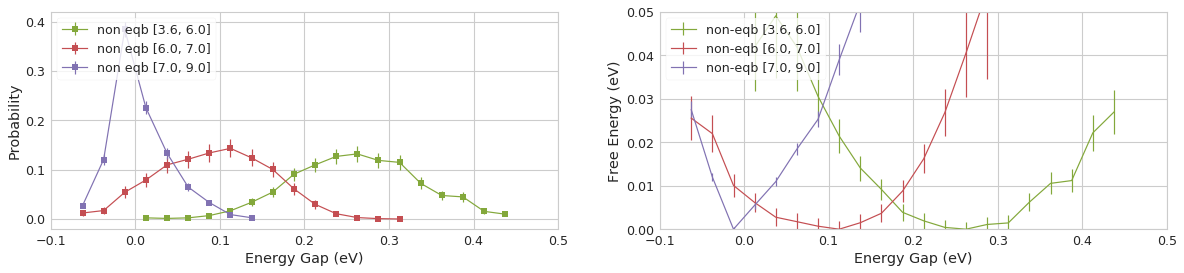

In [72]:
# plotting egap fluctuations for [3.6, 6.0], [6.0, 7.0], [7.0, 9.0] non-eqb
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_diss1[:,0], distr_diss1[:,1], yerr=distr_diss1[:,2], color='C1',marker='s', label='non eqb [3.6, 6.0]')
plt.errorbar(distr_diss2[:,0], distr_diss2[:,1], yerr=distr_diss2[:,2], color='C2',marker='s', label='non eqb [6.0, 7.0]')
plt.errorbar(distr_diss3[:,0], distr_diss3[:,1], yerr=distr_diss3[:,2], color='C3', marker='s', label='non eqb [7.0, 9.0]')
plt.xlim([-0.1,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=2)

plt.subplot(1,2,2)
plt.errorbar(e_diss1[:,0], e_diss1[:,1], yerr=e_diss1[:,2], color='C1', label='non-eqb [3.6, 6.0]')
plt.errorbar(e_diss2[:,0], e_diss2[:,1], yerr=e_diss2[:,2], color='C2', label='non-eqb [6.0, 7.0]')
plt.errorbar(e_diss3[:,0], e_diss3[:,1], yerr=e_diss3[:,2], color='C3', label='non-eqb [7.0, 9.0]')

plt.xlim([-0.1,0.5])
plt.ylim([0,0.05])
plt.xlabel('Energy Gap (eV)', size='x-large')
plt.ylabel('Free Energy (eV)', size='x-large')
plt.legend(loc=2)

In [73]:
# fitting to three gaussians, with ranges [3.6, 6.0], [6.0, 7.0], [7.0, 9.0]
popt1, pcov1 = curve_fit(gaussian, distr_diss1[:,0], distr_diss1[:,1], p0=[0.23, 0.07, 0.05], bounds=(-0.1, 0.5))
popt2, pcov2 = curve_fit(gaussian, distr_diss2[:,0], distr_diss2[:,1], p0=[0.07, 0.07, 0.05], bounds=(-0.1, 0.5))
popt3, pcov3 = curve_fit(gaussian, distr_diss3[:,0], distr_diss3[:,1], p0=[0.24, 0.14, 0.05], bounds=(-0.1, 0.5))
gauss_diss1 = np.array([distr_diss1[:,0], gaussian(distr_diss1[:,0], *popt1), np.ones(len(distr_diss1[:,0]))]).T
gauss_diss2 = np.array([distr_diss2[:,0], gaussian(distr_diss2[:,0], *popt2), np.ones(len(distr_diss2[:,0]))]).T
gauss_diss3 = np.array([distr_diss3[:,0], gaussian(distr_diss3[:,0], *popt3), np.ones(len(distr_diss3[:,0]))]).T
diss_energy_fit1 = genFreeEnergy(gauss_diss1)
diss_energy_fit2 = genFreeEnergy(gauss_diss2)
diss_energy_fit3 = genFreeEnergy(gauss_diss3)
print(popt1)
print(popt2)
print(popt3)

[0.26040591 0.07563635 0.01782724]
[0.09456482 0.0710579  0.01812684]
[-0.00473863  0.02582738  0.01602825]


In [74]:
print('root mean square fluctuation = [' + str(np.round(popt1[1]*1000, 4))+', '+
      str(np.round(popt2[1]*1000, 4))+', '+str(np.round(popt3[1]*1000, 4))+']')

root mean square fluctuation = [75.6364, 71.0579, 25.8274]


In [75]:
print('curvature = '+'['+str(np.round((8.617333262145e-5 * 120)/(2*popt1[1]**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*popt2[1]**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*popt3[1]**2), 4))+']')

curvature = [0.9038, 1.024, 7.7511]


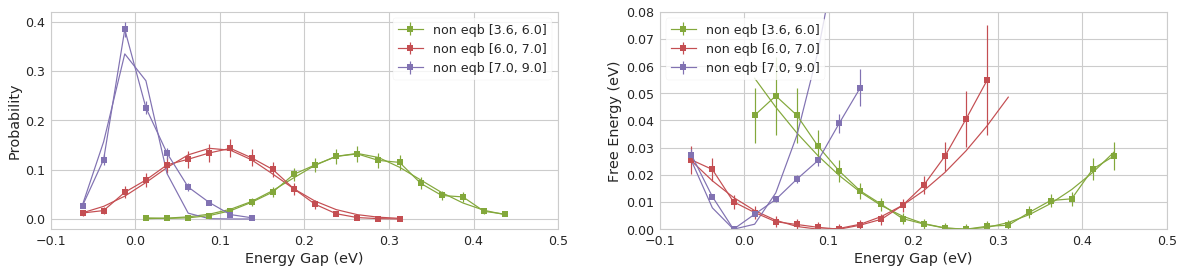

In [76]:
# plotting gaussian fits
s = 0.025
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.errorbar(distr_diss1[:,0], distr_diss1[:,1], yerr=distr_diss1[:,2], color='C1',marker='s', label='non eqb [3.6, 6.0]')
plt.errorbar(distr_diss2[:,0], distr_diss2[:,1], yerr=distr_diss2[:,2], color='C2',marker='s', label='non eqb [6.0, 7.0]')
plt.errorbar(distr_diss3[:,0], distr_diss3[:,1], yerr=distr_diss3[:,2], color='C3', marker='s', label='non eqb [7.0, 9.0]')
plt.plot(gauss_diss1[:,0], gauss_diss1[:,1], 'C1')
plt.plot(gauss_diss2[:,0], gauss_diss2[:,1], 'C2')
plt.plot(gauss_diss3[:,0], gauss_diss3[:,1], 'C3')
plt.xlim([-0.1,0.5])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Probability')
plt.legend(loc=1)
plt.subplot(1,2,2)
plt.errorbar(e_diss1[:,0], e_diss1[:,1], yerr=e_diss1[:,2], marker='s', color='C1', label='non eqb [3.6, 6.0]')
plt.errorbar(e_diss2[:,0], e_diss2[:,1], yerr=e_diss2[:,2], marker='s', color='C2', label='non eqb [6.0, 7.0]')
plt.errorbar(e_diss3[:,0], e_diss3[:,1], yerr=e_diss3[:,2], marker='s', color='C3', label='non eqb [7.0, 9.0]')
plt.plot(diss_energy_fit1[:,0], diss_energy_fit1[:,1], 'C1')
plt.plot(diss_energy_fit2[:,0], diss_energy_fit2[:,1], 'C2')
plt.plot(diss_energy_fit3[:,0], diss_energy_fit3[:,1], 'C3')
plt.xlim([-0.1,0.5])
plt.ylim([0,0.08])
plt.xlabel('Energy Gap (eV)')
plt.ylabel('Free Energy (eV)')
plt.legend(loc=2)

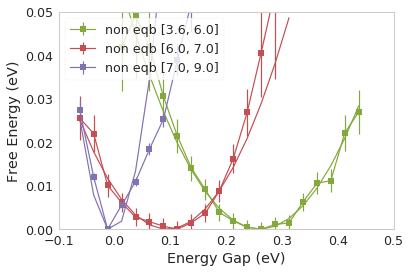

In [77]:
# cleaning up for Proposal
plt.figure(figsize=(6,4))
plt.errorbar(e_diss1[:,0], e_diss1[:,1], yerr=e_diss1[:,2], marker='s', color='C1', label='non eqb [3.6, 6.0]')
plt.errorbar(e_diss2[:,0], e_diss2[:,1], yerr=e_diss2[:,2], marker='s', color='C2', label='non eqb [6.0, 7.0]')
plt.errorbar(e_diss3[:,0], e_diss3[:,1], yerr=e_diss3[:,2], marker='s', color='C3', label='non eqb [7.0, 9.0]')
plt.plot(diss_energy_fit1[:,0], diss_energy_fit1[:,1], 'C1')
plt.plot(diss_energy_fit2[:,0], diss_energy_fit2[:,1], 'C2')
plt.plot(diss_energy_fit3[:,0], diss_energy_fit3[:,1], 'C3')

plt.xlim([-0.1,0.5])
plt.ylim([0,0.05])
plt.xlabel('Energy Gap (eV)', size='x-large')
plt.ylabel('Free Energy (eV)', size='x-large')
plt.legend(loc=2)
plt.grid(False)
plt.savefig('noneqb_fits.eps', format='eps')

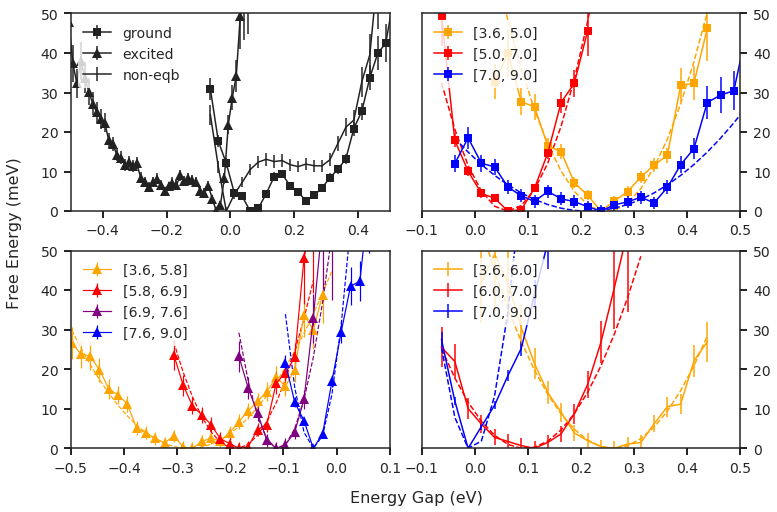

In [78]:
# 4-panel for proposal, roughly publication quality
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(12,8))
# fig, axs = plt.subplots(2, sharex=False, sharey=True, figsize=(6,8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
plt.rcParams["font.family"] = "sans-serif"

plt.grid(False)
ax1.errorbar(e_gnd[:,0], e_gnd[:,1]*1000, yerr=e_gnd[:,2]*1000, marker='s', ms=8, color='k', label='ground', linewidth=1.5)
ax1.errorbar(e_fes[:,0], e_fes[:,1]*1000, yerr=e_fes[:,2]*1000, marker='^', ms=10, color='k', label='excited', linewidth=1.5)
ax1.errorbar(e_diss[:,0], e_diss[:,1]*1000, yerr=e_diss[:,2]*1000, color='k', label='non-eqb', linewidth=1.5)
ax1.grid(False)
ax1.set_xlim([-0.5,0.5])
ax1.legend(loc=2, prop={"size":14}, edgecolor='white')

ax2.errorbar(e_gnd_fc[:,0], e_gnd_fc[:,1]*1000, yerr=e_gnd_fc[:,2]*1000, marker='s', ms='8', color='orange', label='[3.6, 5.0]', linewidth=1.5)
ax2.errorbar(e_gnd_cage[:,0], e_gnd_cage[:,1]*1000, yerr=e_gnd_cage[:,2]*1000, marker='s', ms='8', color='red', label='[5.0, 7.0]', linewidth=1.5)
ax2.errorbar(e_gnd_loc[:,0], e_gnd_loc[:,1]*1000, yerr=e_gnd_loc[:,2]*1000, marker='s', ms='8', color='blue', label='[7.0, 9.0]', linewidth=1.5)
ax2.plot(gnd_energy_fit1[:,0], gnd_energy_fit1[:,1]*1000, '--', color='orange', linewidth=1.5)
ax2.plot(gnd_energy_fit2[:,0], gnd_energy_fit2[:,1]*1000, '--', color='red', linewidth=1.5)
ax2.plot(gnd_energy_fit3[:,0], gnd_energy_fit3[:,1]*1000, '--', color='blue', linewidth=1.5)
ax2.grid(False)
ax2.set_xlim([-0.1,0.5])
ax2.legend(loc=2, prop={"size":14}, edgecolor='white')

ax3.errorbar(e_fes_1[:,0], e_fes_1[:,1]*1000, yerr=e_fes_1[:,2]*1000, marker='^', ms='10', color='orange', label='[3.6, 5.8]')
ax3.errorbar(e_fes_2[:,0], e_fes_2[:,1]*1000, yerr=e_fes_2[:,2]*1000, marker='^', ms='10', color='red', label='[5.8, 6.9]')
ax3.errorbar(e_fes_3[:,0], e_fes_3[:,1]*1000, yerr=e_fes_3[:,2]*1000, marker='^', ms='10', color='purple', label='[6.9, 7.6]')
ax3.errorbar(e_fes_4[:,0], e_fes_4[:,1]*1000, yerr=e_fes_4[:,2]*1000, marker='^', ms='10', color='blue', label='[7.6, 9.0]')
ax3.plot(fes_energy_fit1[:,0], fes_energy_fit1[:,1]*1000, '--', color='orange')
ax3.plot(fes_energy_fit2[:,0], fes_energy_fit2[:,1]*1000, '--', color='red')
ax3.plot(fes_energy_fit3[:,0], fes_energy_fit3[:,1]*1000, '--', color='purple')
ax3.plot(fes_energy_fit4[:,0], fes_energy_fit4[:,1]*1000, '--', color='blue')
ax3.set_xlim([-0.5,0.1])
# ax3.ylim([0,0.05])
# plt.xlabel('Energy Gap (eV)', size='x-large')
# plt.ylabel('Free Energy (eV)', size='x-large')
ax3.legend(loc=2, prop={"size":14}, edgecolor='white')
ax3.grid(False)

# ax3.errorbar(e_fes_fc[:,0], e_fes_fc[:,1]*1000, yerr=e_fes_fc[:,2]*1000, marker='^', ms=10, color='orange', label='[3.6, 7.5]', linewidth=1.5)
# ax3.errorbar(e_fes_cage[:,0], e_fes_cage[:,1]*1000, yerr=e_fes_cage[:,2]*1000, marker='^', ms=10, color='blue', label='[7.5, 9.0]', linewidth=1.5)
# ax3.plot(fes_energy_fit1[:,0], fes_energy_fit1[:,1]*1000, '--', color='orange', linewidth=1.5)
# ax3.plot(fes_energy_fit2[:,0], fes_energy_fit2[:,1]*1000, '--', color='blue', linewidth=1.5)
# ax3.grid(False)
# ax3.set_xlim([-0.5,0.1])
# ax3.legend(loc=2, prop={"size":14}, edgecolor='white')

ax4.errorbar(e_diss1[:,0], e_diss1[:,1]*1000, yerr=e_diss1[:,2]*1000, color='orange', label='[3.6, 6.0]', linewidth=1.5)
ax4.errorbar(e_diss2[:,0], e_diss2[:,1]*1000, yerr=e_diss2[:,2]*1000, color='red', label='[6.0, 7.0]', linewidth=1.5)
ax4.errorbar(e_diss3[:,0], e_diss3[:,1]*1000, yerr=e_diss3[:,2]*1000, color='blue', label='[7.0, 9.0]', linewidth=1.5)
ax4.plot(diss_energy_fit1[:,0], diss_energy_fit1[:,1]*1000, '--', color='orange', linewidth=1.5)
ax4.plot(diss_energy_fit2[:,0], diss_energy_fit2[:,1]*1000, '--', color='red', linewidth=1.5)
ax4.plot(diss_energy_fit3[:,0], diss_energy_fit3[:,1]*1000, '--', color='blue', linewidth=1.5)
ax4.grid(False)
ax4.set_xlim([-0.1,0.5])
ax4.legend(loc=2, prop={"size":14}, edgecolor='white')

plt.ylim([0,50])
fig.text(0.525, 0.04, 'Energy Gap (eV)', ha='center', va='center', fontname='sans-serif', size=16)
fig.text(0.06, 0.5, 'Free Energy (meV)', ha='center', va='center', rotation='vertical', fontname='sans-serif', size=16)

ax1.tick_params(which='major', length=7, width=2)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='major', length=7, width=2)
ax2.tick_params(labelsize=14, left=False, right=True, labelright=True)
ax2.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='major', length=7, width=2)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax4.tick_params(which='major', length=7, width=2)
ax4.tick_params(labelsize=14, left=False, right=True, labelright=True)
ax4.tick_params(axis='y', labelsize=14)

ax1.spines['top'].set_linewidth(1.5)
ax1.spines['top'].set_color('k')
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['bottom'].set_color('k')
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['left'].set_color('k')
ax1.spines['right'].set_linewidth(1.5)
ax1.spines['right'].set_color('k')
ax2.spines['top'].set_linewidth(1.5)
ax2.spines['top'].set_color('k')
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['bottom'].set_color('k')
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['left'].set_color('k')
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['right'].set_color('k')
ax3.spines['top'].set_linewidth(1.5)
ax3.spines['top'].set_color('k')
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['bottom'].set_color('k')
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['left'].set_color('k')
ax3.spines['right'].set_linewidth(1.5)
ax3.spines['right'].set_color('k')
ax4.spines['top'].set_linewidth(1.5)
ax4.spines['top'].set_color('k')
ax4.spines['bottom'].set_linewidth(1.5)
ax4.spines['bottom'].set_color('k')
ax4.spines['left'].set_linewidth(1.5)
ax4.spines['left'].set_color('k')
ax4.spines['right'].set_linewidth(1.5)
ax4.spines['right'].set_color('k')

plt.savefig('4panel_egap_distr.eps', format='eps')

### Looking at solvent structure corresponding to gnd eqb gaussians. Range 3.6-5.0 Ang, 5.0-7.0 Ang, 7.0-9.0 Ang
Done! As the dimer expands from [3.6, 5.0] to [5.0, 7.0] more space opens up between the Na+ allowing Ar to more strongly interact with the electron, thus increasing the curvature of the free energy profile. (will want to calculate Ar-e_com to show this) As the dimer goes from [5.0, 7.0] to [7.0, 9.0] enough space opens up for an Ar to fit between the Na+ increasing the the number of neighbors and forcing the electron to localize. After it localizes, the difference in energy between the ground state and excited state increases bc the the excited state energy increases. The curvature also decreases because less overlap between the electron's electronic states and the Ar. (again will want to calculate some type of overlap)

In [4]:
def visualizeAtoms(na, ar, ind0, ind, dind, N, ncutoff):
    vacant = {}
    occupied = {}
    r_Na = {}
    close = {}
    closest = {}
    
    indices = np.linspace(ind0, ind, num=int((ind-ind0)/dind+1), dtype='int')
    
    for i in range(len(indices)):
        my_Na = na[indices[i]]
        my_Ar = ar[indices[i]]
        
        my_Na, my_Ar = lib.rotDimerEnv(my_Na, my_Ar)
        my_close = lib.closestAr(my_Na, my_Ar, n_cutoff=N, option='dimer')
        my_pts, my_closest = lib.spherProjDimer(my_Na, my_Ar, 1.7, 3.3, n_cutoff=ncutoff, Ar_metric='cation', N=2000)
        
        my_val = int(len(my_pts)-sum(my_pts[:,3]))
        order = np.argsort(my_pts[:,3])
        my_vacant = my_pts[order,:][:my_val,:]
        my_occupied = my_pts[order,:][my_val:,:]
        
        vacant[str(indices[i])] = my_vacant
        occupied[str(indices[i])] = my_occupied
        r_Na[str(indices[i])] = my_Na
        close[str(indices[i])] = my_close
        closest[str(indices[i])] = my_closest
    
    return vacant, occupied, r_Na, close, closest
def colorShell(shell_pts):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(shell_pts[:,0],shell_pts[:,1],shell_pts[:,2],s=1.5,c=shell_pts[:,3],marker='o',vmin=0,vmax=1,cmap='bwr')
    fig.colorbar(p)

    X = shell_pts[:,0]; Y = shell_pts[:,1]; Z = shell_pts[:,2]

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    return None
def compareShell(my_dir, t, num=1000):
    r_Na = lib.readNa(my_dir+'out.na', t)
    r_Ar = lib.readAr(my_dir+'out.water', t)
    shell_pts, closest_ar = lib.spherProjDimer(r_Na, r_Ar, 1.7, 3.3, n_cutoff=6, Ar_metric='dimer', N=num)
    
    myval = int(len(shell_pts)-sum(shell_pts[:,3]))
    print(sum(shell_pts[:,3])/len(shell_pts))
    order = np.argsort(shell_pts[:,3])
    vacant = shell_pts[order,:][:myval,:]
    occupied = shell_pts[order,:][myval:,:]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=vacant[:,0], ys=vacant[:,1], zs=vacant[:,2],s=0.75, c = 'C0', marker='o')
    ax.scatter(xs=occupied[:,0], ys=occupied[:,1], zs=occupied[:,2],s=0.75, c = 'r', marker='o')
    ax.scatter(xs=closest_ar[:,0], ys=closest_ar[:,1], zs=closest_ar[:,2], s=20, c='r', marker='o')

    X = shell_pts[:,0]; Y = shell_pts[:,1]; Z = shell_pts[:,2]

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    return None

In [7]:
# binning data according to ranges [3.6 Ang, 5.0 Ang], [5.0 Ang, 7.0 Ang], [7.0 Ang, 9.0 Ang]. starting with [3.6, 5.0]
# gnd umbrella sampling

# [FC/pre-caging]
r0 = 5.2; r = 7.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  6.9  7.2  \
        7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3'.split()

na_fc = []; ar_fc = []; e_com_fc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_fc += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_fc += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_fc += [my_e_com[j*tau,1:]]
na_fc = np.array(na_fc, dtype='float32'); ar_fc = np.array(ar_fc, dtype='float32'); e_com_fc = np.array(e_com_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/gnd_eqb/na_3.npy', na_fc)
np.save('solvent_environments/gnd_eqb/ar_3.npy', ar_fc)
np.save('solvent_environments/gnd_eqb/ecom_3.npy', e_com_fc)

In [6]:
# load the Na, Ar, e_com data for FC ([3.6, 5.0]) region
na_fc = np.load('solvent_environments/gnd_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/gnd_eqb_ar_fc.npy')
e_com_fc = np.load('solvent_environments/gnd_eqb_ecom_fc.npy')

13.112967889878686 0.02546427807542312


Text(0.5,0,'num of neighbors')

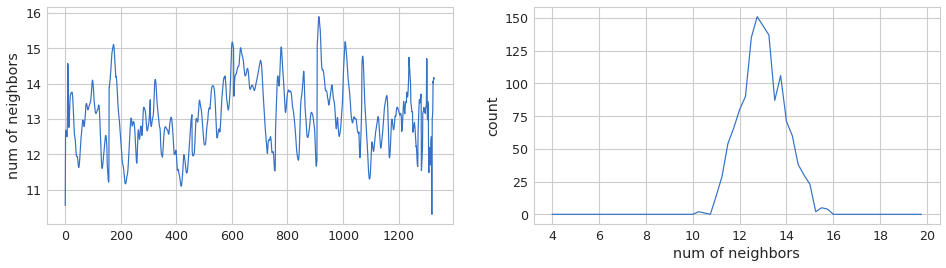

In [8]:
# Num of Neighbors, fc [3.6,5.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    my_bond_dist = lib.dist(na_fc[i,0], na_fc[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,0], ar_fc[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,1], ar_fc[i])-r_cutoff)/kappa))                 
    my_dimer_dist = lib.calcNaArDist(na_fc[i,0], ar_fc[i]) + lib.calcNaArDist(na_fc[i,1], ar_fc[i])
    
    neighbors_fc[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_fc), stats.sem(neighbors_fc))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_fc = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_fc)):
    my_ind = int((neighbors_fc[i]-n0)/dn)
    neighbor_counts_fc[my_ind,1] += 1
neighbor_counts_fc[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_fc)
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_fc[:,0], neighbor_counts_fc[:,1])
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [8]:
# radial distr fxn using radial distance and averaging over both Na's, fc
r0 = 2; r = 10; dr = 0.2
bins_radial_na = np.arange(r0,r,dr)
gr_fc = np.zeros([len(bins_radial_na),3])

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_fc[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_fc[my_ind,1] += 1

gr_fc[:,2] = gr_fc[:,1]
rho = 1600/(43.8332180561224**3)
for j in range(len(gr_fc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_fc[j,1] /= (V2-V1)*2*rho
    gr_fc[j,2] /= (V2-V1)*2*rho*np.sqrt(gr_fc[j,2])
gr_fc[:,1] /= len(na_fc)
gr_fc[:,2] /= len(na_fc)
gr_fc[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 2; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_fc = np.zeros([len(bins_radial_com), 2])

for i in range(len(na_fc)):
    r_na_ar = ar_fc[i] - np.repeat([(na_fc[i,0]+na_fc[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_fc)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_fc[j,1] /= (V2-V1)*rho
gr_dimer_fc[:,1] /= len(na_fc)
gr_dimer_fc[:,0] = bins_radial_com

# radial distr fxn using only 1 Na+
r0 = 2; r = 10; dr = 0.1
bins = np.arange(r0,r,dr)
gr_min_fc = np.zeros([len(bins),2])

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_ar = d_na1_ar if np.min(d_na1_ar) < np.min(d_na2_ar) else d_na2_ar
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_min_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_min_fc)):
    V1 = 4*np.pi/3 * bins[j]**3
    V2 = 4*np.pi/3 * (bins[j]+dr)**3
    gr_min_fc[j,1] /= (V2-V1)*rho
gr_min_fc[:,1] /= len(na_fc)
gr_min_fc[:,0] = bins

/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,1,'g(r) for Na1 closest to neighboring Ar')

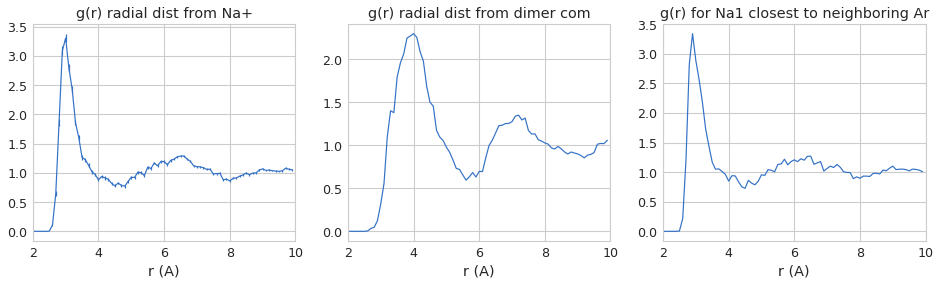

In [13]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.errorbar(gr_fc[:,0], gr_fc[:,1], yerr=gr_fc[:,2])
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_fc[:,0], gr_dimer_fc[:,1])
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(gr_min_fc[:,0], gr_min_fc[:,1])
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) for Na1 closest to neighboring Ar')

In [16]:
ind0 = 800; ind = 1200; dind = 10; N = 15; ncutoff = 8
vacant, occupied, r_Na, close, closest = visualizeAtoms(na_fc, ar_fc, ind0, ind, dind, N, ncutoff)

In [18]:
# With BoundedIntText widget
indices = np.linspace(ind0, ind, num=int((ind-ind0)/dind+1), dtype='int')
my_Na = r_Na[str(indices[0])]
my_vacant = vacant[str(indices[0])]; my_occupied = occupied[str(indices[0])]
my_close = close[str(indices[0])]; my_closest = closest[str(indices[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=ind0, min=ind0, max=ind, step=dind, description='Index :')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

interactive(children=(BoundedIntText(value=800, description='Index :', max=1200, min=800, step=10), Output()),…

In [10]:
# caging/post-caging [5.0, 7.0]
r0 = 5.0; r = 7.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3'.split()
na_cage = []; ar_cage = []; e_com_cage = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_cage += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_cage += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_cage += [my_e_com[j*tau,1:]]
na_cage = np.array(na_cage, dtype='float32'); ar_cage = np.array(ar_cage, dtype='float32'); e_com_cage = np.array(e_com_cage, dtype='float32')

# saving data to load at later time
np.save('solvent_environments/gnd_eqb_na_cage.npy', na_cage)
np.save('solvent_environments/gnd_eqb_ar_cage.npy', ar_cage)
np.save('solvent_environments/gnd_eqb_ecom_cage.npy', e_com_cage)

In [7]:
# load the Na, Ar, e_com data for cage ([5.0, 7.0]) region
na_cage = np.load('solvent_environments/gnd_eqb_na_cage.npy')
ar_cage = np.load('solvent_environments/gnd_eqb_ar_cage.npy')
e_com_cage = np.load('solvent_environments/gnd_eqb_ecom_cage.npy')

13.121079689254014 0.02802100319003571


Text(0.5,0,'num of neighbors')

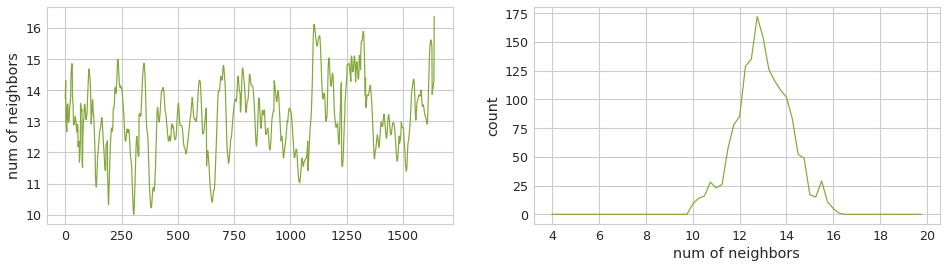

In [12]:
# Num of Neighbors, caging [5.0, 7.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    my_bond_dist = lib.dist(na_cage[i,0], na_cage[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,0], ar_cage[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,1], ar_cage[i])-r_cutoff)/kappa))                 
    my_dimer_dist = lib.calcNaArDist(na_cage[i,0], ar_cage[i]) + lib.calcNaArDist(na_cage[i,1], ar_cage[i])
    
    neighbors_cage[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_cage), stats.sem(neighbors_cage))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_cage = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_cage)):
    my_ind = int((neighbors_cage[i]-n0)/dn)
    neighbor_counts_cage[my_ind] += 1
neighbor_counts_cage[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_cage, 'C1')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_cage[:,0], neighbor_counts_cage[:,1], 'C1')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [13]:
# radial distr fxn using radial distance and averaging over both Na's, cage/post-cage
r0 = 2; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_cage = np.zeros([len(bins_radial_na),2])

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_cage[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_cage)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_cage[j,1] /= (V2-V1)*2*rho
gr_cage[:,1] /= len(na_cage)
gr_cage[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 2; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_cage = np.zeros([len(bins_radial_com),2])

for i in range(len(na_cage)):
    r_na_ar = ar_cage[i] - np.repeat([(na_cage[i,0]+na_cage[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_cage)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_cage[j,1] /= (V2-V1)*rho
gr_dimer_cage[:,1] /= len(na_cage)
gr_dimer_cage[:,0] = bins_radial_com

# radial distr fxn using only 1 Na+
r0 = 2; r = 10; dr = 0.1
bins = np.arange(r0,r,dr)
gr_min_cage = np.zeros([len(bins),2])

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_ar = d_na1_ar if np.min(d_na1_ar) < np.min(d_na2_ar) else d_na2_ar
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_min_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_min_cage)):
    V1 = 4*np.pi/3 * bins[j]**3
    V2 = 4*np.pi/3 * (bins[j]+dr)**3
    gr_min_cage[j,1] /= (V2-V1)*rho
gr_min_cage[:,1] /= len(na_cage)
gr_min_cage[:,0] = bins

Text(0.5,1,'g(r) with only one Na+')

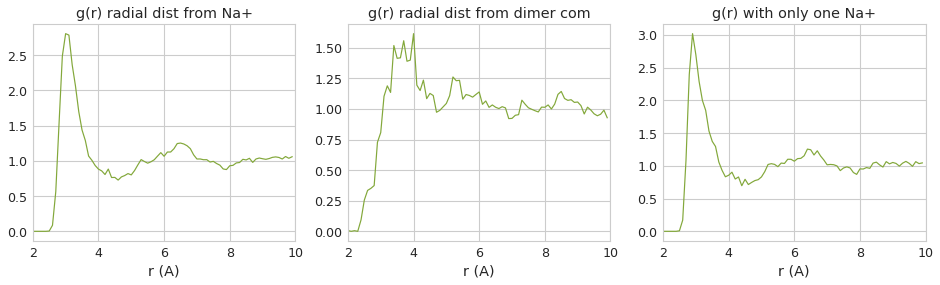

In [14]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_cage[:,0], gr_dimer_cage[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(gr_min_cage[:,0], gr_min_cage[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) with only one Na+')

In [9]:
ind0 = 1000; ind = 1200; dind = 10; N = 8; ncutoff = 8
vacant, occupied, r_Na, close, closest = visualizeAtoms(na_cage, ar_cage, ind0, ind, dind, N, ncutoff)

In [10]:
# With BoundedIntText widget
indices = np.linspace(ind0, ind, num=int((ind-ind0)/dind+1), dtype='int')
my_Na = r_Na[str(indices[0])]
my_vacant = vacant[str(indices[0])]; my_occupied = occupied[str(indices[0])]
my_close = close[str(indices[0])]; my_closest = closest[str(indices[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=ind0, min=ind0, max=ind, step=dind, description='Index :')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

interactive(children=(BoundedIntText(value=1000, description='Index :', max=1200, min=1000, step=10), Output()…

In [5]:
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = ['4.0', '4.2', '4.4', '4.5', '4.7', '4.8', '5.0', '5.1', '5.2', '5.3', '5.5', '5.6', '5.7', '5.8', '6.0']
overlap40 = lib.avgOccDist(root, dirs, 1.7, 3.3, 4.0, 1.0, num=2000)
print(sum(overlap40[:,3])/len(overlap40))

947
0.5379872925887251


Presents average argon environment as series of colored points around the sodium cation cores (not shown). Red means occupied (Ar generally present) and blue means unoccupied (Ar not present). Points are distributed according to fibonacci sphere so points are approximately evenly spaced.

<IPython.core.display.Javascript object>


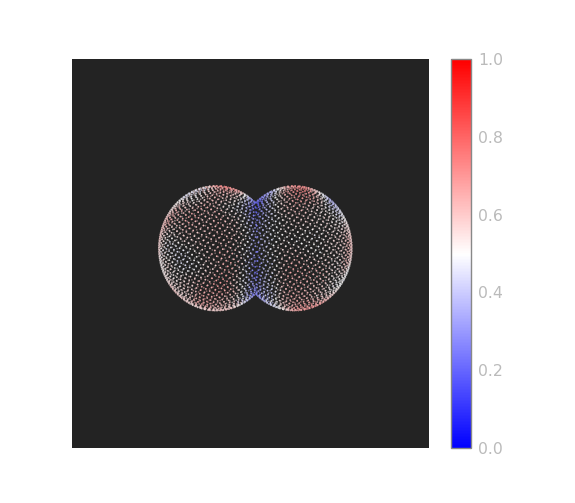

(-5.54832340883369, 5.548086258807869, -5.548763554396165, 5.547646113245395)

In [6]:
%matplotlib notebook
colorShell(overlap40)
plt.grid(False)
plt.axis('off')

In [5]:
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '5.0 5.1 5.2 5.3 5.5 5.6 5.7 5.8 6.0 6.1 6.3 6.4 6.5 6.7'.split()
overlap50 = lib.avgOccDist(root, dirs, 1.7, 3.3, 5.0, 1.0, num=2000)
print(sum(overlap50[:,3])/len(overlap50))

712
0.4824288787951223


<IPython.core.display.Javascript object>


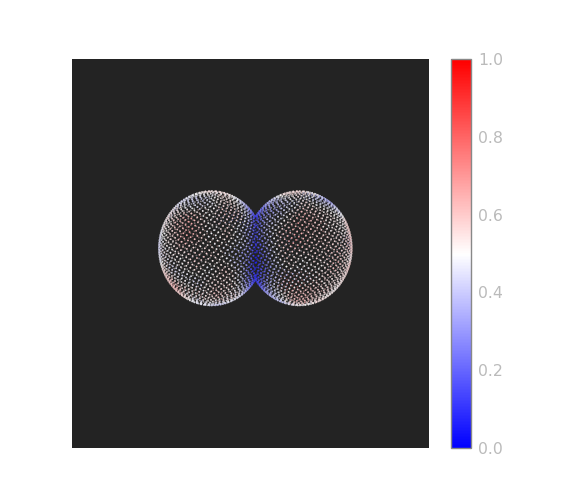

(-6.04832340883369, 6.048086258807869, -6.048763554396165, 6.047646113245395)

In [6]:
%matplotlib notebook
colorShell(overlap50)
plt.grid(False)
plt.axis('off')

In [5]:
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '8.0 8.2 8.4 8.5 8.6 8.8 9.0'.split()
overlap80 = lib.avgOccDist(root, dirs, 1.7, 3.3, 8.0, 1.0, num=2000)
print(sum(overlap80[:,3])/len(overlap80))

567
0.4829488536155204


<IPython.core.display.Javascript object>


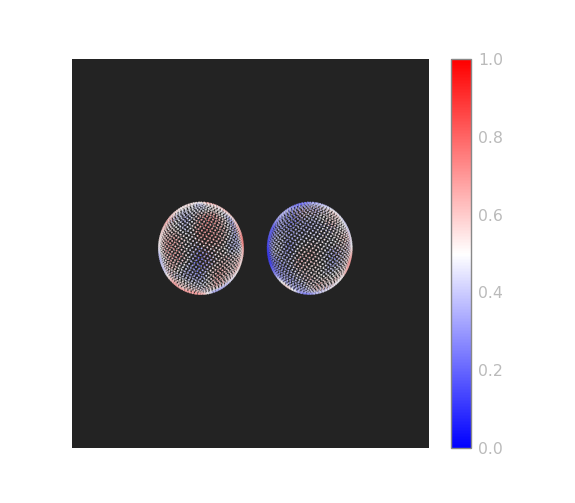

(-7.54832340883369, 7.548086258807869, -7.548763554396165, 7.547646113245395)

In [6]:
%matplotlib notebook
colorShell(overlap80)
plt.grid(False)
plt.axis('off')

In [25]:
def checkRange(my_dir):
    data = np.loadtxt(my_dir+'/bondumb2.out')[50:,1]
    return [np.min(data), np.max(data)]

In [36]:
checkRange('/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/5.0')

[4.21712246320949, 5.05316742488147]

In [ ]:
dirs = '5.0 5.1 5.2 5.3 5.5 5.6 5.7 5.8 6.0 6.1 6.3 6.4 6.5 6.7'.split()

In [7]:
# localization
r0 = 7.0; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
na_loc = []; ar_loc = []; e_com_loc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_loc += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_loc += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_loc += [my_e_com[j*tau,1:]]
na_loc = np.array(na_loc, dtype='float32'); ar_loc = np.array(ar_loc, dtype='float32'); e_com_loc = np.array(e_com_loc, dtype='float32')

# saving data to load at later time
np.save('solvent_environments/gnd_eqb_na_loc.npy', na_loc)
np.save('solvent_environments/gnd_eqb_ar_loc.npy', ar_loc)
np.save('solvent_environments/gnd_eqb_ecom_loc.npy', e_com_loc)

In [50]:
# load the Na, Ar, e_com data for FC ([7.0, 9.0]) region
na_loc = np.load('solvent_environments/gnd_eqb_na_loc.npy')
ar_loc = np.load('solvent_environments/gnd_eqb_ar_loc.npy')
e_com_loc = np.load('solvent_environments/gnd_eqb_ecom_loc.npy')

13.953807171711935 0.043692451524515695


Text(0.5,0,'num of neighbors')

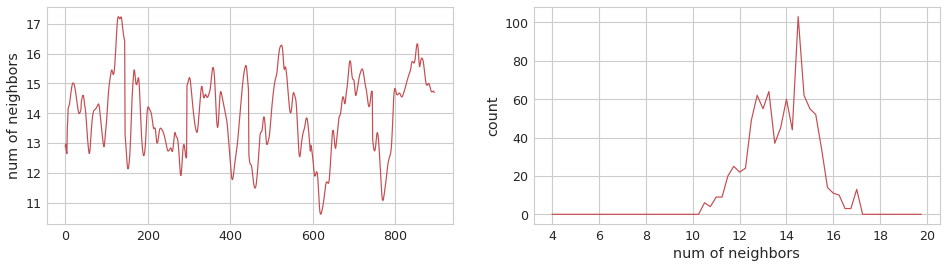

In [16]:
# Num of Neighbors, post-caging [7.0, 9.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_loc = np.zeros(len(na_loc))
for i in range(len(na_loc)):
    my_bond_dist = lib.dist(na_loc[i,0], na_loc[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_loc[i,0], ar_loc[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_loc[i,1], ar_loc[i])-r_cutoff)/kappa))                 
    my_dimer_dist = lib.calcNaArDist(na_loc[i,0], ar_loc[i]) + lib.calcNaArDist(na_loc[i,1], ar_loc[i])
    
    neighbors_loc[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_loc), stats.sem(neighbors_loc))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_loc = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_loc)):
    my_ind = int((neighbors_loc[i]-n0)/dn)
    neighbor_counts_loc[my_ind,1] += 1
neighbor_counts_loc[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_loc, 'C2')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_loc[:,0], neighbor_counts_loc[:,1], 'C2')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [6]:
# radial distr fxn using radial distance and averaging over both Na's, loc
r0 = 2; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_loc = np.zeros([len(bins_radial_na),2])

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_loc[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_loc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_loc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_loc[j,1] /= (V2-V1)*2*rho
gr_loc[:,1] /= len(na_loc)
gr_loc[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 2; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_loc = np.zeros([len(bins_radial_com),2])

for i in range(len(na_loc)):
    r_na_ar = ar_loc[i] - np.repeat([(na_loc[i,0]+na_loc[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_loc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_loc)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_loc[j,1] /= (V2-V1)*rho
gr_dimer_loc[:,1] /= len(na_loc)
gr_dimer_loc[:,0] = bins_radial_com

# radial distr fxn using only 1 Na+
r0 = 2; r = 10; dr = 0.1
bins = np.arange(r0,r,dr)
gr_min_loc = np.zeros([len(bins),2])

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_ar = d_na1_ar if np.min(d_na1_ar) < np.min(d_na2_ar) else d_na2_ar
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_min_loc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_min_loc)):
    V1 = 4*np.pi/3 * bins[j]**3
    V2 = 4*np.pi/3 * (bins[j]+dr)**3
    gr_min_loc[j,1] /= (V2-V1)*rho
gr_min_loc[:,1] /= len(na_loc)
gr_min_loc[:,0] = bins

Text(0.5,1,'g(r) elliptical dist')

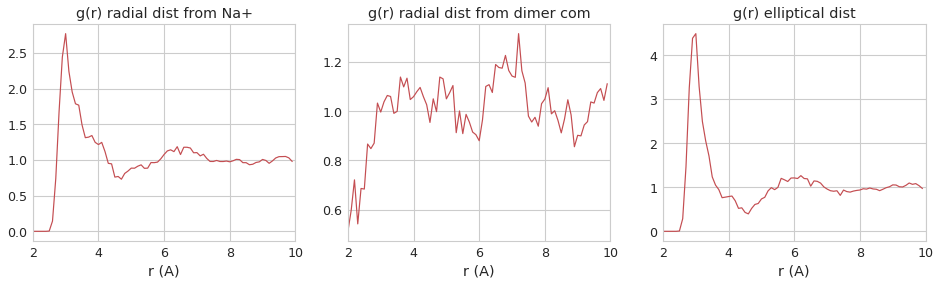

In [18]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_loc[:,0], gr_loc[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_loc[:,0], gr_dimer_loc[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(gr_min_loc[:,0], gr_min_loc[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [51]:
cation_rdf = np.loadtxt('rdfs/na+_Ar.txt')
neutral_rdf = np.loadtxt('rdfs/na_Ar.txt')

In [52]:
# radial distr fxn using radial distance and averaging over both Na's, loc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_loc = np.zeros([len(bins_radial_na),5])

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na_loc[i,0], e_com_loc[i]), lib.dist(na_loc[i,1], e_com_loc[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_loc[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_loc[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_loc[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_loc[my_ind,1] += 1

gr_loc[:,3:] = np.sqrt(gr_loc[:,1:3])
rho = 1600/(43.8332180561224**3)
for j in range(len(gr_loc)):
    dV = 4*np.pi/3 * (bins_radial_na[j]+dr)**3 - 4*np.pi/3 * bins_radial_na[j]**3
    gr_loc[j,1:] /= dV*rho
gr_loc[:,1:] /= len(na_loc)
gr_loc[:,0] = bins_radial_na

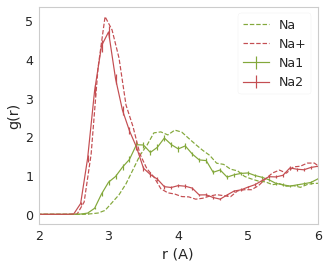

In [53]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.errorbar(gr_loc[:,0], gr_loc[:,1], yerr=gr_loc[:,3], color='g', label='Na1')
plt.errorbar(gr_loc[:,0], gr_loc[:,2], yerr=gr_loc[:,4], color='r', label='Na2')
plt.plot(neutral_rdf[:,0], neutral_rdf[:,1], 'g--', label='Na')
plt.plot(cation_rdf[:,0], cation_rdf[:,1], 'r--', label='Na+')
plt.xlim([2,6])
plt.legend(loc=1)
plt.xlabel('r (A)')
plt.ylabel('g(r)')

plt.grid(False)

In [11]:
gr_loc[np.argwhere(gr_loc[:,2] == np.max(gr_loc[:,2]))[0][0]]

array([3.        , 0.83004674, 4.70862878])

In [14]:
gr_loc[np.argwhere(gr_loc[:,1] == np.max(gr_loc[:,1]))[0][0]]

array([3.8       , 1.97013461, 0.71354234])

In [11]:
ind0 = 600; ind = 800; dind = 10; N = 15; ncutoff = 8
vacant, occupied, r_Na, close, closest = visualizeAtoms(na_loc, ar_loc, ind0, ind, dind, N, ncutoff)

In [13]:
# With BoundedIntText widget
indices = np.linspace(ind0, ind, num=int((ind-ind0)/dind+1), dtype='int')
my_Na = r_Na[str(indices[0])]
my_vacant = vacant[str(indices[0])]; my_occupied = occupied[str(indices[0])]
my_close = close[str(indices[0])]; my_closest = closest[str(indices[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=ind0, min=ind0, max=ind, step=dind, description='Index :')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

interactive(children=(BoundedIntText(value=600, description='Index :', max=800, min=600, step=10), Output()), …

Text(0,0.5,'Prob Distribution')

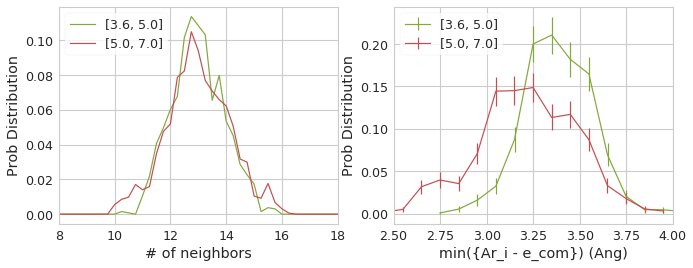

In [36]:
# Counts for number of neighbors around dimer and min Ar-e distance
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(neighbor_counts_fc[:,0], neighbor_counts_fc[:,1]/np.sum(neighbor_counts_fc[:,1]), 'C1', label='[3.6, 5.0]')
plt.plot(neighbor_counts_cage[:,0], neighbor_counts_cage[:,1]/np.sum(neighbor_counts_cage[:,1]), 'C2', label='[5.0, 7.0]')
#plt.plot(neighbor_counts_loc[:,0], neighbor_counts_loc[:,1], 'C3', label='[7.0, 9.0]')
plt.ylabel('Prob Distribution')
plt.xlabel('# of neighbors')
plt.xlim([8,18])
plt.legend(loc=2)

plt.subplot(1,2,2)
plt.errorbar(count_ar_e_fc[:,0], count_ar_e_fc[:,1], yerr=count_ar_e_fc[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(count_ar_e_cage[:,0], count_ar_e_cage[:,1], yerr=count_ar_e_cage[:,2], color='C2', label='[5.0, 7.0]')
#plt.errorbar(count_ar_e_loc[:,0], count_ar_e_loc[:,1], yerr=count_ar_e_loc[:,2], color='C3', label='[7.0, 9.0]')
plt.legend(loc=2)
plt.xlim([2.5, 4.0])
plt.xlabel('min({Ar_i - e_com}) (Ang)')
plt.ylabel('Prob Distribution')

In [ ]:
# loading na, ar, ecom data for ranges [3.6, 4.7], [4.7, 5.2], [5.2, 7.0]
na1 = np.load('solvent_environments/gnd_eqb/na_1.npy')
ar1 = np.load('solvent_environments/gnd_eqb/ar_1.npy')
e_com1 = np.load('solvent_environments/gnd_eqb/ecom_1.npy')

na2 = np.load('solvent_environments/gnd_eqb/na_2.npy')
ar2 = np.load('solvent_environments/gnd_eqb/ar_2.npy')
e_com2 = np.load('solvent_environments/gnd_eqb/ecom_2.npy')

na3 = np.load('solvent_environments/gnd_eqb/na_3.npy')
ar3 = np.load('solvent_environments/gnd_eqb/ar_3.npy')
e_com3 = np.load('solvent_environments/gnd_eqb/ecom_3.npy')

In [53]:
# Using Na and Ar positions to calculate cross-correlation between Na-Ar-bond axis angles
angles1 = np.zeros([len(na1),2])
for i in range(len(na1)):
    alpha = []   # angles involving Na1
    beta = []    # angles involving Na2    
    r_ar = lib.closestAr(na1[i], ar1[i], n_cutoff=6, option='dimer')
    bond_axis = na1[i,1,:] - na1[i,0,:]
    bond_axis /= np.sqrt(np.dot(bond_axis, bond_axis))
    
    for j in range(len(r_ar)):
        if lib.dist(na1[i,0,:], r_ar[j]) < lib.dist(na1[i,1,:], r_ar[j]):
            r_na_ar = r_ar[j] - na1[i,0,:]
            r_na_ar /= np.sqrt(np.dot(r_na_ar, r_na_ar))
            alpha += [np.arccos(np.dot(r_na_ar, bond_axis))]
        else:
            r_na_ar = r_ar[j] - na1[i,1,:]
            r_na_ar /= np.sqrt(np.dot(r_na_ar, r_na_ar))
            beta += [np.arccos(np.dot(r_na_ar, -bond_axis))]

    if np.min(alpha) < np.min(beta):
        angles1[i] = [np.min(alpha), np.min(beta)]
    else:
        angles1[i] = [np.min(beta), np.min(alpha)]
angles1 *= 180/np.pi

In [54]:
# Using Na and Ar positions to calculate cross-correlation between Na-Ar-bond axis angles
angles2 = np.zeros([len(na2),2])
for i in range(len(na2)):
    alpha = []   # angles involving Na1
    beta = []    # angles involving Na2    
    r_ar = lib.closestAr(na2[i], ar2[i], n_cutoff=6, option='dimer')
    bond_axis = na2[i,1,:] - na2[i,0,:]
    bond_axis /= np.sqrt(np.dot(bond_axis, bond_axis))
    
    for j in range(len(r_ar)):
        if lib.dist(na2[i,0,:], r_ar[j]) < lib.dist(na2[i,1,:], r_ar[j]):
            r_na_ar = r_ar[j] - na2[i,0,:]
            r_na_ar /= np.sqrt(np.dot(r_na_ar, r_na_ar))
            alpha += [np.arccos(np.dot(r_na_ar, bond_axis))]
        else:
            r_na_ar = r_ar[j] - na2[i,1,:]
            r_na_ar /= np.sqrt(np.dot(r_na_ar, r_na_ar))
            beta += [np.arccos(np.dot(r_na_ar, -bond_axis))]

    if np.min(alpha) < np.min(beta):
        angles2[i] = [np.min(alpha), np.min(beta)]
    else:
        angles2[i] = [np.min(beta), np.min(alpha)]
angles2 *= 180/np.pi

In [55]:
# Using Na and Ar positions to calculate cross-correlation between Na-Ar-bond axis angles
angles3 = np.zeros([len(na3),2])
for i in range(len(na3)):
    alpha = []   # angles involving Na1
    beta = []    # angles involving Na2    
    r_ar = lib.closestAr(na3[i], ar3[i], n_cutoff=6, option='dimer')
    bond_axis = na3[i,1,:] - na3[i,0,:]
    bond_axis /= np.sqrt(np.dot(bond_axis, bond_axis))
    
    for j in range(len(r_ar)):
        if lib.dist(na3[i,0,:], r_ar[j]) < lib.dist(na3[i,1,:], r_ar[j]):
            r_na_ar = r_ar[j] - na3[i,0,:]
            r_na_ar /= np.sqrt(np.dot(r_na_ar, r_na_ar))
            alpha += [np.arccos(np.dot(r_na_ar, bond_axis))]
        else:
            r_na_ar = r_ar[j] - na3[i,1,:]
            r_na_ar /= np.sqrt(np.dot(r_na_ar, r_na_ar))
            beta += [np.arccos(np.dot(r_na_ar, -bond_axis))]

    if np.min(alpha) < np.min(beta):
        angles3[i] = [np.min(alpha), np.min(beta)]
    else:
        angles3[i] = [np.min(beta), np.min(alpha)]
angles3 *= 180/np.pi

(35, 80)

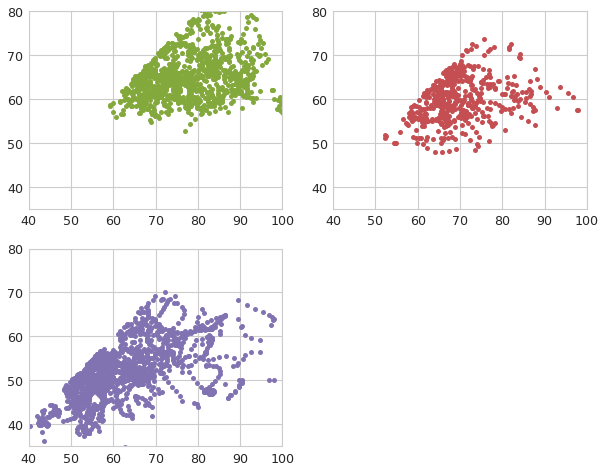

In [101]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(angles1[:,1], angles1[:,0], 'C1.', markersize=10)
plt.xlim([40,100])
plt.ylim([35,80])
plt.subplot(2,2,2)
plt.plot(angles2[:,1], angles2[:,0], 'C2.', markersize=10)
plt.xlim([40,100])
plt.ylim([35,80])
plt.subplot(2,2,3)
plt.plot(angles3[:,1], angles3[:,0], 'C3.', markersize=10)
plt.xlim([40,100])
plt.ylim([35,80])

In [87]:
# binning scatter plot to make heat map
alpha0, alpha1, d_alpha = (35, 80, 2.5)
beta0, beta1, d_beta = (40, 100, 2.5)
alpha_bins = np.arange(alpha0, alpha1, d_alpha)
beta_bins = np.arange(beta0, beta1, d_beta)

binned_angles1 = np.zeros([len(beta_bins), len(alpha_bins)])
norm = 0
for i in range(len(angles1)):
    if angles1[i,0] < alpha1 and angles1[i,0] > alpha0:
        if angles1[i,1] < beta1 and angles1[i,0] > beta0:
            alpha_ind = int((angles1[i,0]-alpha0)/d_alpha)
            beta_ind = int((angles1[i,1]-beta0)/d_beta)
            norm += 1
    binned_angles1[beta_ind, alpha_ind] += 1
binned_angles1 /= norm

binned_angles2 = np.zeros([len(beta_bins), len(alpha_bins)])
norm = 0
for i in range(len(angles2)):
    if angles2[i,0] < alpha1 and angles2[i,0] > alpha0:
        if angles2[i,1] < beta1 and angles2[i,0] > beta0:
            alpha_ind = int((angles2[i,0]-alpha0)/d_alpha)
            beta_ind = int((angles2[i,1]-beta0)/d_beta)
            norm += 1
    binned_angles2[beta_ind, alpha_ind] += 1
binned_angles2 /= norm

binned_angles3 = np.zeros([len(beta_bins), len(alpha_bins)])
norm = 0
for i in range(len(angles3)):
    if angles3[i,0] < alpha1 and angles3[i,0] > alpha0:
        if angles3[i,1] < beta1 and angles3[i,0] > beta0:
            alpha_ind = int((angles3[i,0]-alpha0)/d_alpha)
            beta_ind = int((angles3[i,1]-beta0)/d_beta)
            norm += 1
    binned_angles3[beta_ind, alpha_ind] += 1
binned_angles3 /= norm

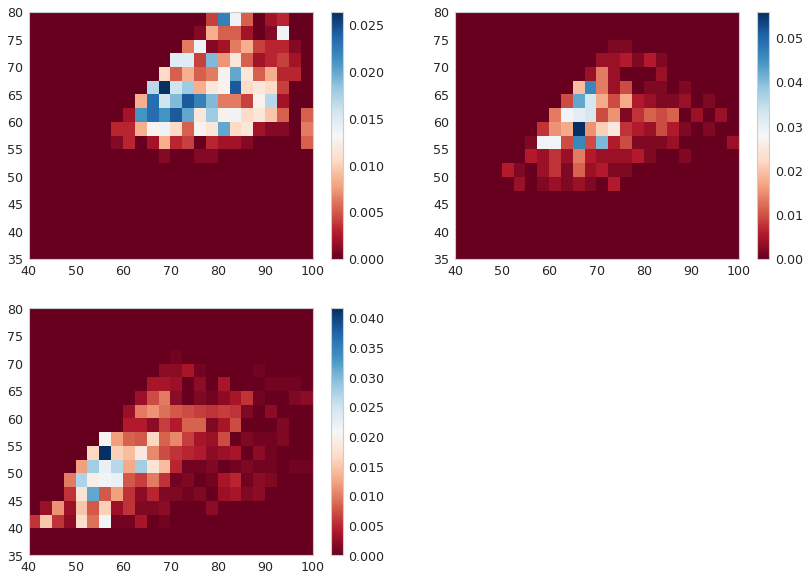

In [98]:
# plotting heat maps
alpha_bins = np.arange(alpha0, alpha1, d_alpha)
beta_bins = np.arange(beta0, beta1, d_beta)

x, y = np.mgrid[beta0:beta1+d_beta:d_beta, alpha0:alpha1+d_alpha:d_alpha]
# vmax=np.max(np.max(binned_angles1))
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.pcolormesh(x, y, binned_angles1, cmap='RdBu', vmin=0, vmax=np.max(np.max(binned_angles1)))
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolormesh(x, y, binned_angles2, cmap='RdBu', vmin=0, vmax=np.max(np.max(binned_angles2)))
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolormesh(x, y, binned_angles3, cmap='RdBu', vmin=0, vmax=np.max(np.max(binned_angles3)))
plt.colorbar()

While heat maps are nice, didn't make it to paper or SI because overly redundant and needed some extra work

In [53]:
# loading data for [3.6, 5.0], [5.0, 7.0], [7.0, 9.0]
na_fc = np.load('solvent_environments/gnd_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/gnd_eqb_ar_fc.npy')

na_cage = np.load('solvent_environments/gnd_eqb_na_cage.npy')
ar_cage = np.load('solvent_environments/gnd_eqb_ar_cage.npy')

na_loc = np.load('solvent_environments/gnd_eqb_na_loc.npy')
ar_loc = np.load('solvent_environments/gnd_eqb_ar_loc.npy')

In [70]:
# counting number of Ar in the intramolecular region for ranges [3.6, 5.0], [5.0, 7.0]
r_cutoff = 2.1; kappa = 10

counts_intra1 = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='dimer') - na_fc[i,0]
    bond_ax = na_fc[i,1,:] - na_fc[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra1[i] = np.dot(radial_filter, axial_filter)

counts_intra2 = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='dimer') - na_cage[i,0]
    bond_ax = na_cage[i,1,:] - na_cage[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra2[i] = np.dot(radial_filter, axial_filter)

1005.0
519.0
1445.0
0.125 0.13704238921001924 0.21877162629757785


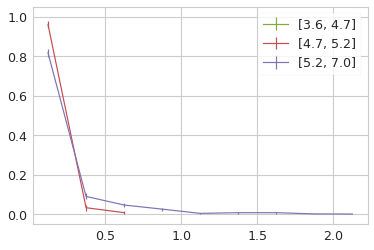

In [10]:
# integrate over cylinder r_cutoff = 2.5; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 4.7]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[4.7, 5.2]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[5.2, 7.0]')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]), 
      np.dot(distr_intra3[:,0], distr_intra3[:,1]))

1329.0
1640.0
0.00031017682468021074 0.010576402439024392


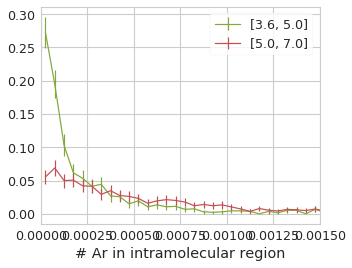

In [87]:
# integrate over cylinder r_cutoff = 2.1; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.00005)
distr_intra2 = genDistr(counts_intra2, spacing=0.00005)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.0, 7.0]')
plt.xlabel('# Ar in intramolecular region')
plt.legend(loc=1)
plt.xlim([0,0.0015])
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))

1005.0
519.0
1445.0
0.4558457711442786 0.5435934489402697


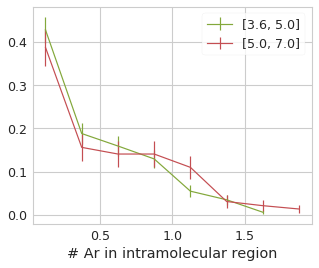

In [6]:
# integrate over fixed cylinder r_cutoff = 3.0; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.0, 7.0]')
plt.xlabel('# Ar in intramolecular region')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))

1329.0
1640.0
1445.0
0.6280097817908201 1.4096036585365854


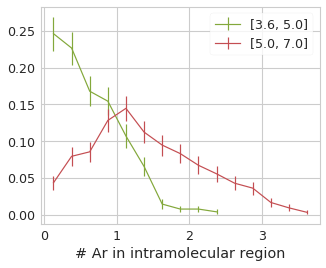

In [12]:
# integrate over cylinder r_cutoff = 3.0; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.0, 7.0]')
plt.xlabel('# Ar in intramolecular region')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))

1005.0
519.0
1445.0
0.8541044776119403 1.1211464354527938 1.709083044982699


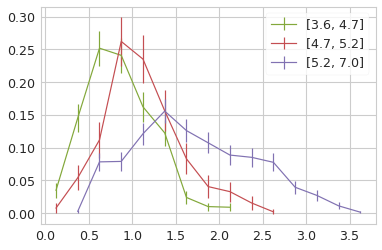

In [23]:
# integrate over cylinder r_cutoff = 3.0; kappa = 5
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 4.7]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[4.7, 5.2]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[5.2, 7.0]')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]), 
      np.dot(distr_intra3[:,0], distr_intra3[:,1]))

1005.0
519.0
1445.0
1.631965174129353 1.9997591522157996 2.8334775086505193


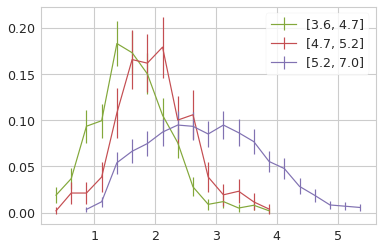

In [25]:
# integrate over cylinder r_cutoff=3.25
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 4.7]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[4.7, 5.2]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[5.2, 7.0]')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]), 
      np.dot(distr_intra3[:,0], distr_intra3[:,1]))

1005.0
519.0
1445.0
2.5727611940298507 3.045038535645472 4.044723183391003


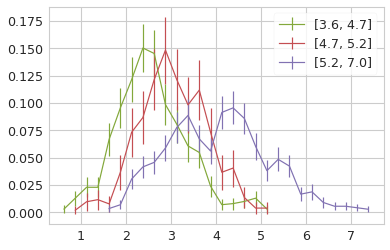

In [27]:
# integrate over cylinder r_cutoff=3.5
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 4.7]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[4.7, 5.2]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[5.2, 7.0]')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]), 
      np.dot(distr_intra3[:,0], distr_intra3[:,1]))

1005.0
519.0
1445.0


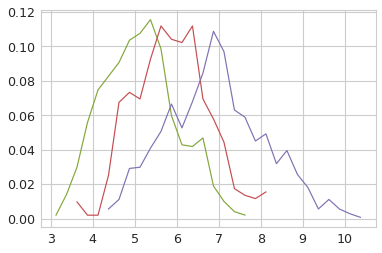

In [125]:
# integrate over cylinder r_cutoff=4.25
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)

plt.plot(distr_intra1[:,0], distr_intra1[:,1], 'C1')
plt.plot(distr_intra2[:,0], distr_intra2[:,1], 'C2')
plt.plot(distr_intra3[:,0], distr_intra3[:,1], 'C3')

In [31]:
# counting number of Ar in the intramolecular region for ranges [3.6, 5.0], [5.0, 7.0]
r_cutoff = 3.25; kappa = 5

counts_intra_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='dimer') - na_fc[i,0,:]
    bond_ax = na_fc[i,1,:] - na_fc[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra_fc[i] = np.dot(radial_filter, axial_filter)

counts_intra_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='dimer') - na_cage[i,0,:]
    bond_ax = na_cage[i,1,:] - na_cage[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra_cage[i] = np.dot(radial_filter, axial_filter)

1329.0
1640.0
1.6759781790820165 2.7713414634146343


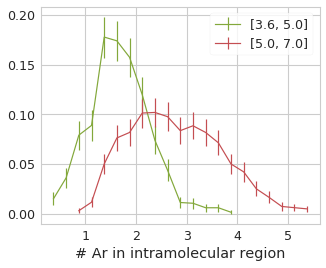

In [35]:
# integrate over cylinder r_cutoff=3.25
distr_intra_fc = genDistr(counts_intra_fc, spacing=0.25)
distr_intra_cage = genDistr(counts_intra_cage, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra_fc[:,0], distr_intra_fc[:,1], yerr=distr_intra_fc[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(distr_intra_cage[:,0], distr_intra_cage[:,1], yerr=distr_intra_cage[:,2], color='C2', label='[5.0, 7.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra_fc[:,0], distr_intra_fc[:,1]), np.dot(distr_intra_cage[:,0], distr_intra_cage[:,1]))

In [45]:
# curvature of parabolas corresponding to each Gaussian fit [fc, cage, loc]
print('curvature = '+'['+str(np.round((8.617333262145e-5 * 120)/(2*popt1[1]**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*popt2[1]**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*popt3[1]**2), 4))+']')

curvature = [1.4105, 2.1801, 0.3004]


In [14]:
ar_e_fc = [np.min(np.sqrt((ar_fc[i,:,0]-e_com_fc[i,0])**2 + (ar_fc[i,:,1]-e_com_fc[i,1])**2 + (ar_fc[i,:,2]-e_com_fc[i,2])**2))
           for i in range(len(e_com_fc))]
ar_e_cage = [np.min(np.sqrt((ar_cage[i,:,0]-e_com_cage[i,0])**2 + (ar_cage[i,:,1]-e_com_cage[i,1])**2 + (ar_cage[i,:,2]-e_com_cage[i,2])**2))
           for i in range(len(e_com_cage))]
ar_e_loc = [np.min(np.sqrt((ar_loc[i,:,0]-e_com_loc[i,0])**2 + (ar_loc[i,:,1]-e_com_loc[i,1])**2 + (ar_loc[i,:,2]-e_com_loc[i,2])**2))
           for i in range(len(e_com_loc))]

In [15]:
count_ar_e_fc = genDistr(ar_e_fc)
count_ar_e_cage = genDistr(ar_e_cage)
count_ar_e_loc = genDistr(ar_e_loc)

1329.0
1640.0
895.0


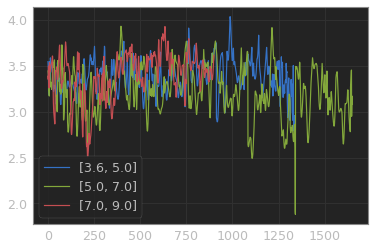

In [39]:
plt.plot(ar_e_fc, 'C0', label='[3.6, 5.0]')
plt.plot(ar_e_cage, 'C1', label='[5.0, 7.0]')
plt.plot(ar_e_loc, 'C2', label='[7.0, 9.0]')
plt.legend(loc=3)

In [32]:
print(np.average(ar_e_fc), stats.sem(ar_e_fc))
print(np.average(ar_e_cage), stats.sem(ar_e_cage))
print(np.average(ar_e_loc), stats.sem(ar_e_loc))

3.3802135956113437 0.004916562986461351
3.2143596017222773 0.006540450348839302
3.395793958574283 0.00822362080769118


Text(0,0.5,'Prob Distribution')

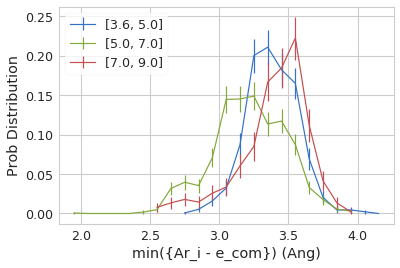

In [16]:
plt.errorbar(count_ar_e_fc[:,0], count_ar_e_fc[:,1], yerr=count_ar_e_fc[:,2], color='C0', label='[3.6, 5.0]')
plt.errorbar(count_ar_e_cage[:,0], count_ar_e_cage[:,1], yerr=count_ar_e_cage[:,2], color='C1', label='[5.0, 7.0]')
plt.errorbar(count_ar_e_loc[:,0], count_ar_e_loc[:,1], yerr=count_ar_e_loc[:,2], color='C2', label='[7.0, 9.0]')
plt.legend(loc=2)
plt.xlabel('min({Ar_i - e_com}) (Ang)')
plt.ylabel('Prob Distribution')

1329.0
1640.0
895.0


Text(0,0.5,'Prob Distribution')

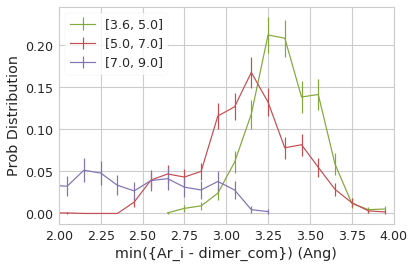

In [13]:
# distribiton of Ar-dimer_com distance
ar_dimer_fc = [np.min(np.sqrt((ar_fc[i,:,0]-(na_fc[i,0,0]+na_fc[i,1,0])/2)**2 + (ar_fc[i,:,1]-(na_fc[i,0,1]+na_fc[i,1,1])/2)**2
            + (ar_fc[i,:,2]-(na_fc[i,0,2]+na_fc[i,1,2])/2)**2)) for i in range(len(e_com_fc))]
ar_dimer_cage = [np.min(np.sqrt((ar_cage[i,:,0]-(na_cage[i,0,0]+na_cage[i,1,0])/2)**2 + (ar_cage[i,:,1]-(na_cage[i,0,1]+na_cage[i,1,1])/2)**2
            + (ar_cage[i,:,2]-(na_cage[i,0,2]+na_cage[i,1,2])/2)**2)) for i in range(len(e_com_cage))]
ar_dimer_loc = [np.min(np.sqrt((ar_loc[i,:,0]-(na_loc[i,0,0]+na_loc[i,1,0])/2)**2 + (ar_loc[i,:,1]-(na_loc[i,0,1]+na_loc[i,1,1])/2)**2
            + (ar_loc[i,:,2]-(na_loc[i,0,2]+na_loc[i,1,2])/2)**2)) for i in range(len(e_com_loc))]

count_ar_dimer_fc = genDistr(ar_dimer_fc)
count_ar_dimer_cage = genDistr(ar_dimer_cage)
count_ar_dimer_loc = genDistr(ar_dimer_loc)

plt.figure(figsize=(6,4))
plt.errorbar(count_ar_dimer_fc[:,0], count_ar_dimer_fc[:,1], yerr=count_ar_dimer_fc[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(count_ar_dimer_cage[:,0], count_ar_dimer_cage[:,1], yerr=count_ar_dimer_cage[:,2], color='C2', label='[5.0, 7.0]')
plt.errorbar(count_ar_dimer_loc[:,0], count_ar_dimer_loc[:,1], yerr=count_ar_dimer_loc[:,2], color='C3', label='[7.0, 9.0]')
plt.legend(loc=2)
plt.xlim([2.0, 4.0])
plt.xlabel('min({Ar_i - dimer_com}) (Ang)')
plt.ylabel('Prob Distribution')

#### If we look at spatial distribution of Ar around the Na+, then we see that in the [5.0, 7.0] range, the dimer has expanded but not so much that an Ar can fit between the two Na+

In [12]:
# heat map for fc
eps = 1.7; radius = 3.3; r = 4.3; dr = 0.7; n_cutoff = 100; num = 2000; project = 'None'
r_Na = np.array([[(r+dr/4)/2,0,0], [-(r+dr/4)/2,0,0]])
shell_pts_fc = lib.spherProjDimer(r_Na, np.array([[0,0,2*r],[0,0,-2*r]]), 1e-6, radius, N=num)[0]

for i in range(len(ar_fc)):
    my_Na = na_fc[i]
    my_Ar = lib.closestAr(my_Na, ar_fc[i], n_cutoff=n_cutoff, option='cation')
    my_Na, my_Ar = lib.rotDimerEnv(my_Na, my_Ar)
    if lib.dist(my_Na[0], e_com_fc[j,:]) > lib.dist(my_Na[1], e_com_fc[j,:]):
        my_Na *= [-1,1,1]; my_Ar *= [-1,1,1]
        
    my_shell_pts_fc = lib.spherProjDimer(r_Na, my_Ar, eps, radius, N=num, project=project)[0]
    shell_pts_fc[:,3] += my_shell_pts_fc[:,3]

shell_pts_fc[:,3] /= len(na_fc)

<IPython.core.display.Javascript object>


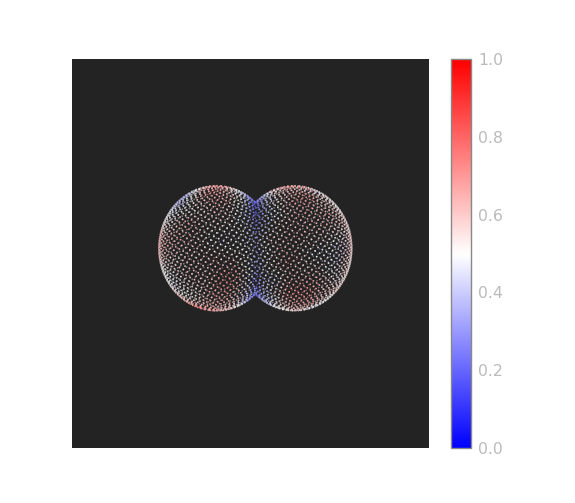

In [13]:
# [3.6, 5.0] or 'fc'
%matplotlib notebook
colorShell(shell_pts_fc)
plt.grid(False)
plt.axis('off')

In [12]:
# heat map for caging/post-caging
eps = 1.7; radius = 3.3; r = 6.0; dr = 1.0; n_cutoff = 100; num = 2000; project = 'None'
r_Na = np.array([[(r+dr/4)/2,0,0], [-(r+dr/4)/2,0,0]])
shell_pts_cage = lib.spherProjDimer(r_Na, np.array([[0,0,2*r],[0,0,-2*r]]), 1e-6, radius, N=num)[0]

for i in range(len(ar_cage)):
    my_Na = na_cage[i]
    my_Ar = lib.closestAr(my_Na, ar_cage[i], n_cutoff=n_cutoff, option='cation')
    my_Na, my_Ar = lib.rotDimerEnv(my_Na, my_Ar)
    if lib.dist(my_Na[0], e_com_cage[j,:]) > lib.dist(my_Na[1], e_com_cage[j,:]):
        my_Na *= [-1,1,1]; my_Ar *= [-1,1,1]
        
    my_shell_pts_cage = lib.spherProjDimer(r_Na, my_Ar, eps, radius, N=num, project=project)[0]
    shell_pts_cage[:,3] += my_shell_pts_cage[:,3]

shell_pts_cage[:,3] /= len(na_cage)

<IPython.core.display.Javascript object>


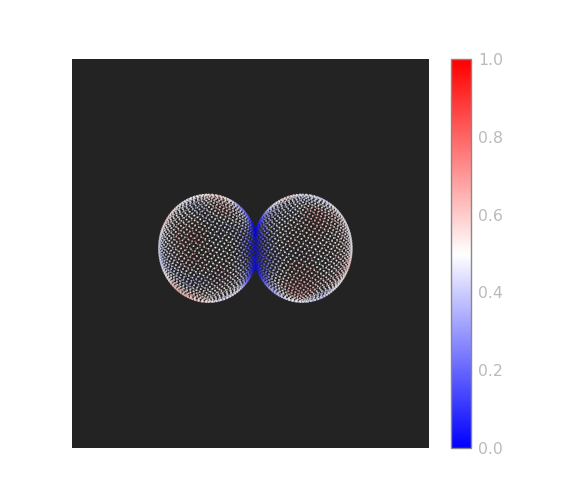

(-6.4233234088336904,
 6.423086258807869,
 -6.4237635543961646,
 6.4226461132453947)

In [14]:
# [5.0, 7.0] or 'cage'
%matplotlib notebook
colorShell(shell_pts_cage)
plt.grid(False)
plt.axis('off')

In [14]:
# heat map for localization
eps = 1.7; radius = 3.3; r = 8.0; dr = 1.0; n_cutoff = 100; num = 2000; project = 'None'
r_Na = np.array([[(r+dr/4)/2,0,0], [-(r+dr/4)/2,0,0]])
shell_pts_loc = lib.spherProjDimer(r_Na, np.array([[0,0,2*r],[0,0,-2*r]]), 1e-6, radius, N=num)[0]

for i in range(len(ar_loc)):
    my_Na = na_loc[i]
    my_Ar = lib.closestAr(my_Na, ar_loc[i], n_cutoff=n_cutoff, option='cation')
    my_Na, my_Ar = lib.rotDimerEnv(my_Na, my_Ar)
    if lib.dist(my_Na[0], e_com_loc[j,:]) > lib.dist(my_Na[1], e_com_loc[j,:]):
        my_Na *= [-1,1,1]; my_Ar *= [-1,1,1]
        
    my_shell_pts_loc = lib.spherProjDimer(r_Na, my_Ar, eps, radius, N=num, project=project)[0]
    shell_pts_loc[:,3] += my_shell_pts_loc[:,3]

shell_pts_loc[:,3] /= len(na_loc)

<IPython.core.display.Javascript object>


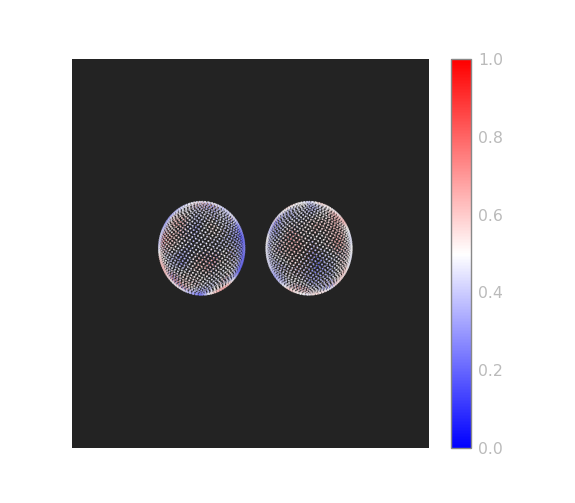

(-7.4233234088336904,
 7.423086258807869,
 -7.4237635543961646,
 7.4226461132453947)

In [15]:
# [7.0, 9.0] or 'loc'
%matplotlib notebook
colorShell(shell_pts_loc)
plt.grid(False)
plt.axis('off')

### Looking at solvent structure corresponding to fes eqb gaussians. Range 3.6-7.5 Ang, 7.5-9.0 Ang
Changing ranges to [3.6, 5.8], [5.8, 6.9], [6.9, 7.6], [7.6, 9.0]

In [12]:
def visualizeAtoms(na, ar, ind0, ind, dind, N, ncutoff):
    vacant = {}
    occupied = {}
    r_Na = {}
    close = {}
    closest = {}
    
    indices = np.linspace(ind0, ind, num=int((ind-ind0)/dind+1), dtype='int')
    
    for i in range(len(indices)):
        my_Na = na[indices[i]]
        my_Ar = ar[indices[i]]
        
        my_Na, my_Ar = lib.rotDimerEnv(my_Na, my_Ar)
        my_close = lib.closestAr(my_Na, my_Ar, n_cutoff=N, option='cation')
        my_pts, my_closest = lib.spherProjDimer(my_Na, my_Ar, 1.7, 3.3, n_cutoff=ncutoff, Ar_metric='cation', N=2000)
        
        my_val = int(len(my_pts)-sum(my_pts[:,3]))
        order = np.argsort(my_pts[:,3])
        my_vacant = my_pts[order,:][:my_val,:]
        my_occupied = my_pts[order,:][my_val:,:]
        
        vacant[str(indices[i])] = my_vacant
        occupied[str(indices[i])] = my_occupied
        r_Na[str(indices[i])] = my_Na
        close[str(indices[i])] = my_close
        closest[str(indices[i])] = my_closest
    
    return vacant, occupied, r_Na, close, closest
def colorShell(shell_pts):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(shell_pts[:,0],shell_pts[:,1],shell_pts[:,2],s=1.5,c=shell_pts[:,3],marker='o',vmin=0,vmax=1,cmap='bwr')
    fig.colorbar(p)

    X = shell_pts[:,0]; Y = shell_pts[:,1]; Z = shell_pts[:,2]

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    return None

In [4]:
# load the Na, Ar, e_com data for FC ([3.6, 7.5]) region
na_fc = np.load('solvent_environments/fes_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/fes_eqb_ar_fc.npy')
e_com_fc = np.load('solvent_environments/fes_eqb_ecom_fc.npy')

12.74261717809519 0.023173109883975362


Text(0.5,0,'num of neighbors')

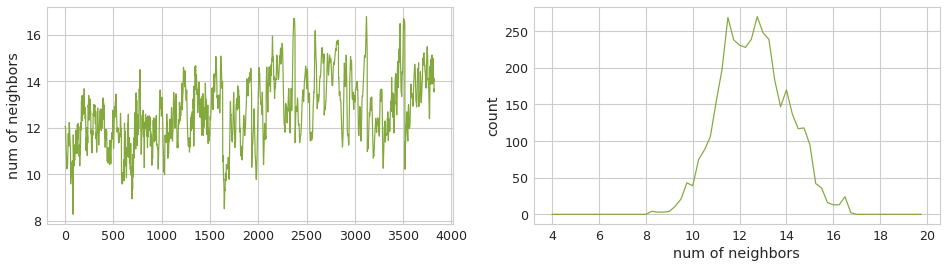

In [38]:
# Num of Neighbors, fc [3.6, 7.5]
r_cutoff = 4.25; kappa = 0.2
neighbors_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    my_bond_dist = lib.dist(na_fc[i,0], na_fc[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,0], ar_fc[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,1], ar_fc[i])-r_cutoff)/kappa))                 
#    my_dimer_dist = lib.calcNaArDist(na_fc[i,0], ar_fc[i]) + lib.calcNaArDist(na_fc[i,1], ar_fc[i])

    neighbors_fc[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_fc), stats.sem(neighbors_fc))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_fc = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_fc)):
    my_ind = int((neighbors_fc[i]-n0)/dn)
    neighbor_counts_fc[my_ind,1] += 1
neighbor_counts_fc[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_fc, 'C1')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_fc[:,0], neighbor_counts_fc[:,1], 'C1')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [5]:
# radial distr fxn using radial distance and averaging over both Na's, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_fc = np.zeros([len(bins_radial_na),2])

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_fc[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_fc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_fc[j,1] /= (V2-V1)*2*rho
gr_fc[:,1] /= len(na_fc)
gr_fc[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_fc = np.zeros([len(bins_radial_com),2])

for i in range(len(na_fc)):
    r_na_ar = ar_fc[i] - np.repeat([(na_fc[i,0]+na_fc[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_fc)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_fc[j,1] /= (V2-V1)*rho
gr_dimer_fc[:,1] /= len(na_fc)
gr_dimer_fc[:,0] = bins_radial_com

# radial distr fxn using elliptical (dimer) distance, fc
r0 = 4; r = 20; dr = 0.1
bins_elliptical = np.arange(r0,r,dr)
counts_elliptical = np.zeros(len(bins_elliptical))

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical)):
    V1 = 4*np.pi/27 * bins_elliptical[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical[j]+dr)**3
    counts_elliptical[j] /= (V2-V1)*rho
counts_elliptical /= len(na_fc)

Text(0.5,1,'g(r) elliptical dist')

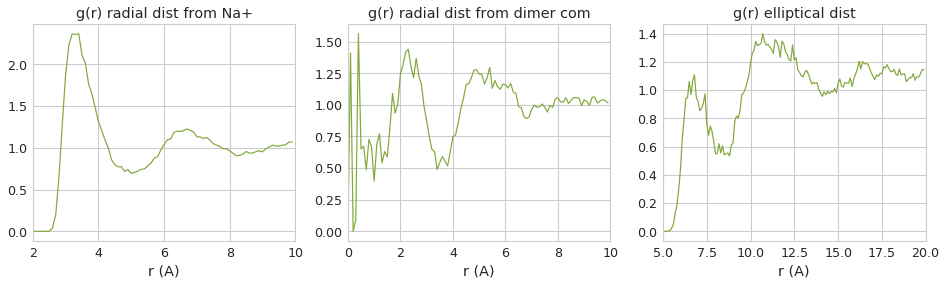

In [6]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_fc[:,0], gr_fc[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_fc[:,0], gr_dimer_fc[:,1], 'C1')
plt.xlim([0,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical, counts_elliptical, 'C1')
plt.xlim([5,20])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [7]:
np.max(gr_fc[:,1])

2.3645165826786148

In [8]:
np.argwhere(gr_fc[:,1] == np.max(gr_fc[:,1]))

array([[34]])

In [9]:
gr_fc[34]

array([3.4       , 2.36451658])

Text(0.5,1,'g(r) elliptical dist')

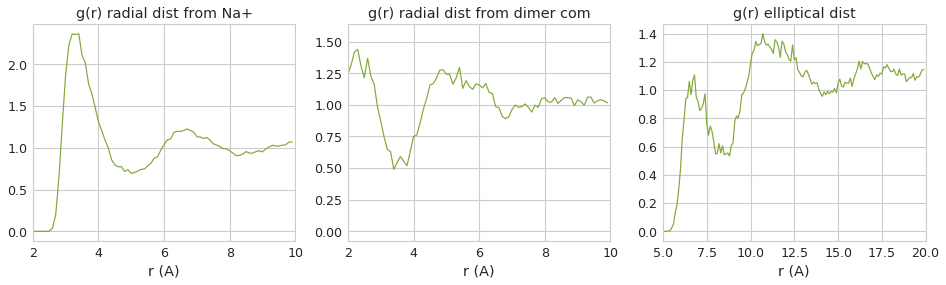

In [40]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_fc[:,0], gr_fc[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_fc[:,0], gr_dimer_fc[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical, counts_elliptical, 'C1')
plt.xlim([5,20])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [21]:
# radial distr fxn using radial distance and averaging over both Na's, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_fc = np.zeros([len(bins_radial_na),3])

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na_fc[i,0], e_com_fc[i]), lib.dist(na_fc[i,1], e_com_fc[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_fc[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_fc[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_fc[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_fc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_fc[j,1:] /= (V2-V1)*rho
gr_fc[:,1:] /= len(na_fc)
gr_fc[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

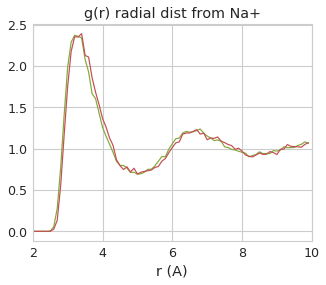

In [22]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr_fc[:,0], gr_fc[:,1], 'C1', label='Na1')
plt.plot(gr_fc[:,0], gr_fc[:,2], 'C2', label='Na2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')

In [28]:
na_ecom_fc = np.zeros([len(na_fc), 2])
for i in range(len(na_fc)):
    bond_len = lib.dist(na_fc[i,0], na_fc[i,1])
    na_ecom = lib.dist(na_fc[i,0], e_com_fc[i])
    
    na_ecom_fc[i] = [bond_len, na_ecom/bond_len]
na_ecom_fc[:,1] = 0.5 - np.abs(na_ecom_fc[:,1] - 0.5)

In [30]:
na_ecom_cage = np.zeros([len(na_cage), 2])
for i in range(len(na_cage)):
    bond_len = lib.dist(na_cage[i,0], na_cage[i,1])
    na_ecom = lib.dist(na_cage[i,0], e_com_cage[i])
    
    na_ecom_cage[i] = [bond_len, na_ecom/bond_len]
na_ecom_cage[:,1] = 0.5 - np.abs(na_ecom_cage[:,1] - 0.5)

(0, 0.5)

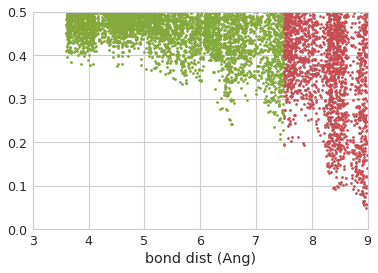

In [32]:
# scaled distance between Na+ and e_com
plt.plot(na_ecom_fc[:,0], na_ecom_fc[:,1], 'C1.')
plt.plot(na_ecom_cage[:,0], na_ecom_cage[:,1], 'C2.')

plt.xlabel('bond dist (Ang)')
plt.xlim([3.0, 9.0])
plt.ylim([0, 0.5])

In [43]:
root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
# dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
#         '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0',
#         '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8']
delta_q = lib.calcQSepDist(root, dirs, 2, chkpt='True', resume='False')

In [44]:
dirs = ['4.2', '4.3', '4.4', '4.6', '4.8', '5.0', '5.2', '5.4', '5.6', '5.8']
delta_q = lib.calcQSepDist(root, dirs, 2, chkpt='True', resume='True')

In [45]:
dirs = ['6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5']
delta_q = lib.calcQSepDist(root, dirs, 2, chkpt='True', resume='True')

In [ ]:
dirs = ['7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
fes_delta_q = lib.calcQSepDist(root, dirs, 2, chkpt='False', resume='True')
np.savetxt('fes_delta_q.txt', fes_delta_q, ['%10.2f', '%18.14f', '%18.14f', '%18.14f'])

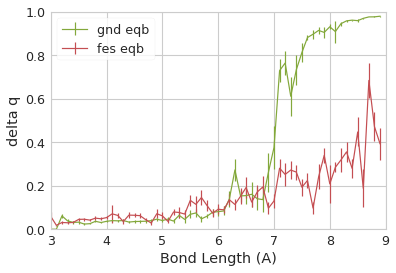

In [13]:
# delta q as function of bond length for gnd eqb and fes eqb
gnd_delta_q = np.loadtxt('gnd_delta_q.txt')
fes_delta_q = np.loadtxt('fes_delta_q.txt')
plt.errorbar(gnd_delta_q[:,0], gnd_delta_q[:,1], yerr=gnd_delta_q[:,3], color='C1', label='gnd eqb')
plt.errorbar(fes_delta_q[:,0], fes_delta_q[:,1], yerr=fes_delta_q[:,3], color='C2', label='fes eqb')
plt.ylim([0,1])
plt.xlim([3,9])
plt.ylabel('delta q')
plt.xlabel('Bond Length (A)')
plt.legend(loc=2)

In [13]:
na_fc = np.load('solvent_environments/fes_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/fes_eqb_ar_fc.npy')

na_cage = np.load('solvent_environments/fes_eqb_na4-5.npy')
ar_cage = np.load('solvent_environments/fes_eqb_ar4-5.npy')

na_loc = np.load('solvent_environments/fes_eqb_na6-7.npy')
ar_loc = np.load('solvent_environments/fes_eqb_ar6-7.npy')

In [14]:
# counting number of Ar in the intramolecular region for ranges [3.6, 7.5], [7.5, 9.0]
r_cutoff = 3.0; kappa = 10

counts_intra_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='dimer') - na_fc[i,0,:]
    bond_ax = na_fc[i,1,:] - na_fc[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra_fc[i] = np.dot(radial_filter, axial_filter)

counts_intra_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='dimer') - na_cage[i,0,:]
    bond_ax = na_cage[i,1,:] - na_cage[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra_cage[i] = np.dot(radial_filter, axial_filter)
    
counts_intra_loc = np.zeros(len(na_loc))
for i in range(len(na_loc)):
    closest_Ar = lib.closestAr(na_loc[i], ar_loc[i], n_cutoff=20, option='dimer') - na_loc[i,0,:]
    bond_ax = na_loc[i,1,:] - na_loc[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra_loc[i] = np.dot(radial_filter, axial_filter)

3824.0
1855.0
3.5105910041841 4.769609164420485


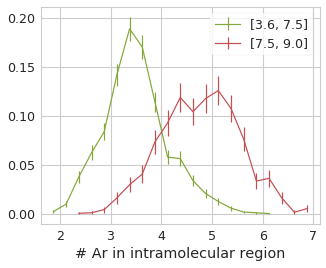

In [40]:
# integrate over cylinder r_cutoff=3.25
distr_intra_fc = genDistr(counts_intra_fc, spacing=0.25)
distr_intra_cage = genDistr(counts_intra_cage, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra_fc[:,0], distr_intra_fc[:,1], yerr=distr_intra_fc[:,2], color='C1', label='[3.6, 7.5]')
plt.errorbar(distr_intra_cage[:,0], distr_intra_cage[:,1], yerr=distr_intra_cage[:,2], color='C2', label='[7.5, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra_fc[:,0], distr_intra_fc[:,1]), np.dot(distr_intra_cage[:,0], distr_intra_cage[:,1]))

3824.0
991.0
1000.0
3.5105910041841 3.1948789101917257


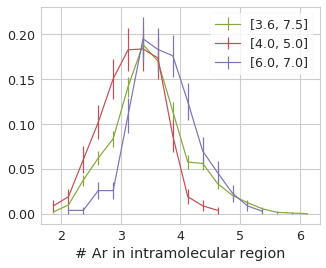

In [14]:
# integrate over cylinder r_cutoff=3.25
distr_intra_fc = genDistr(counts_intra_fc, spacing=0.25)
distr_intra_cage = genDistr(counts_intra_cage, spacing=0.25)
distr_intra_loc = genDistr(counts_intra_loc, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra_fc[:,0], distr_intra_fc[:,1], yerr=distr_intra_fc[:,2], color='C1', label='[3.6, 7.5]')
plt.errorbar(distr_intra_cage[:,0], distr_intra_cage[:,1], yerr=distr_intra_cage[:,2], color='C2', label='[4.0, 5.0]')
plt.errorbar(distr_intra_loc[:,0], distr_intra_loc[:,1], yerr=distr_intra_loc[:,2], color='C3', label='[6.0, 7.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra_fc[:,0], distr_intra_fc[:,1]), np.dot(distr_intra_cage[:,0], distr_intra_cage[:,1]))

3824.0
991.0
1000.0
2.7694822175732217 2.697906155398587


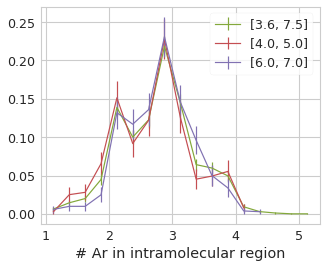

In [15]:
# integrate over cylinder r_cutoff = 3.0; kappa = 10
distr_intra_fc = genDistr(counts_intra_fc, spacing=0.25)
distr_intra_cage = genDistr(counts_intra_cage, spacing=0.25)
distr_intra_loc = genDistr(counts_intra_loc, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra_fc[:,0], distr_intra_fc[:,1], yerr=distr_intra_fc[:,2], color='C1', label='[3.6, 7.5]')
plt.errorbar(distr_intra_cage[:,0], distr_intra_cage[:,1], yerr=distr_intra_cage[:,2], color='C2', label='[4.0, 5.0]')
plt.errorbar(distr_intra_loc[:,0], distr_intra_loc[:,1], yerr=distr_intra_loc[:,2], color='C3', label='[6.0, 7.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra_fc[:,0], distr_intra_fc[:,1]), np.dot(distr_intra_cage[:,0], distr_intra_cage[:,1]))

In [7]:
# fes umbrella sampling [7.5, 9.0]
r0 = 7.5; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0',
        '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
# dirs = ['7.0', '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
na_cage = []; ar_cage = []; e_com_cage = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_cage += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_cage += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_cage += [my_e_com[j*tau,1:]]
na_cage = np.array(na_cage, dtype='float32'); ar_cage = np.array(ar_cage, dtype='float32'); e_com_cage = np.array(e_com_cage, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/fes_eqb_na_cage.npy', na_cage)
np.save('solvent_environments/fes_eqb_ar_cage.npy', ar_cage)
np.save('solvent_environments/fes_eqb_ecom_cage.npy', e_com_cage)

In [29]:
# load the Na, Ar, e_com data for cage ([7.5, 9.0]) region
na_cage = np.load('solvent_environments/fes_eqb_na_cage.npy')
ar_cage = np.load('solvent_environments/fes_eqb_ar_cage.npy')
e_com_cage = np.load('solvent_environments/fes_eqb_ecom_cage.npy')

14.325155305028723 0.028049197565896782


Text(0.5,0,'num of neighbors')

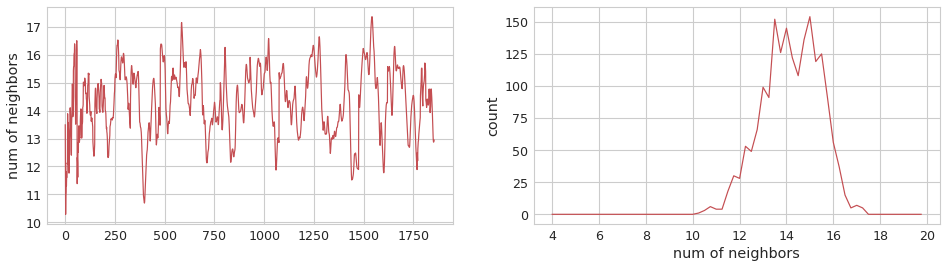

In [42]:
# Num of Neighbors, caging [7.5, 9.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    my_bond_dist = lib.dist(na_cage[i,0], na_cage[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,0], ar_cage[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,1], ar_cage[i])-r_cutoff)/kappa))                 
#    my_dimer_dist = lib.calcNaArDist(na_cage[i,0], ar_cage[i]) + lib.calcNaArDist(na_cage[i,1], ar_cage[i])

    neighbors_cage[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_cage), stats.sem(neighbors_cage))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_cage = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_cage)):
    my_ind = int((neighbors_cage[i]-n0)/dn)
    neighbor_counts_cage[my_ind] += 1
neighbor_counts_cage[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_cage, 'C2')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_cage[:,0], neighbor_counts_cage[:,1], 'C2')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [43]:
# radial distr fxn using radial distance and averaging over both Na's, cage/post-cage
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_cage = np.zeros([len(bins_radial_na),2])

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_cage[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_cage)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_cage[j,1] /= (V2-V1)*2*rho
gr_cage[:,1] /= len(na_cage)
gr_cage[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_cage = np.zeros([len(bins_radial_com),2])

for i in range(len(na_cage)):
    r_na_ar = ar_cage[i] - np.repeat([(na_cage[i,0]+na_cage[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_cage)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_cage[j,1] /= (V2-V1)*rho
gr_dimer_cage[:,1] /= len(na_cage)
gr_dimer_cage[:,0] = bins_radial_com

# radial distr fxn using elliptical (dimer) distance, fc
r0 = 4; r = 20; dr = 0.1
bins_elliptical = np.arange(r0,r,dr)
counts_elliptical = np.zeros(len(bins_elliptical))

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical)):
    V1 = 4*np.pi/27 * bins_elliptical[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical[j]+dr)**3
    counts_elliptical[j] /= (V2-V1)*rho
counts_elliptical /= len(na_cage)

Text(0.5,1,'g(r) elliptical dist')

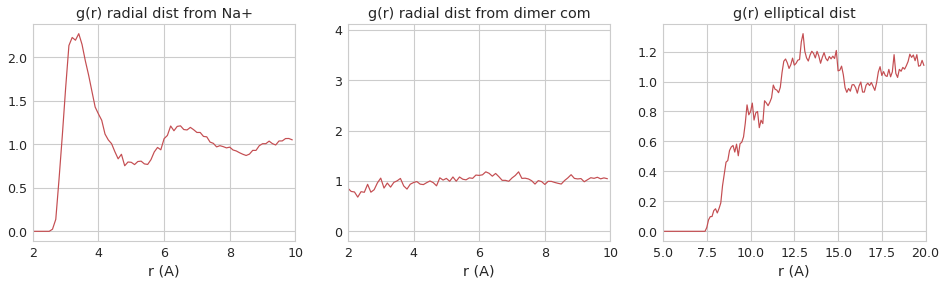

In [45]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_cage[:,0], gr_dimer_cage[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical, counts_elliptical, 'C2')
plt.xlim([5,20])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [30]:
# radial distr fxn using radial distance and averaging over both Na's, cage
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_cage = np.zeros([len(bins_radial_na),3])

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na_cage[i,0], e_com_cage[i]), lib.dist(na_cage[i,1], e_com_cage[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_cage[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_cage[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_cage[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_cage)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_cage[j,1:] /= (V2-V1)*rho
gr_cage[:,1:] /= len(na_cage)
gr_cage[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

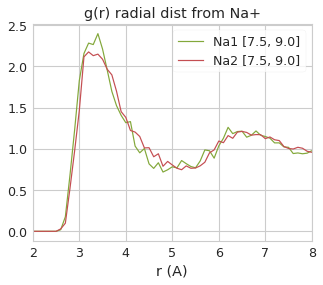

In [32]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C1', label='Na1 [7.5, 9.0]')
plt.plot(gr_cage[:,0], gr_cage[:,2], 'C2', label='Na2 [7.5, 9.0]')
plt.xlim([2,8])
plt.xlabel('r (A)')
plt.legend(loc=1)
plt.title('g(r) radial dist from Na+')

(500, 1500)

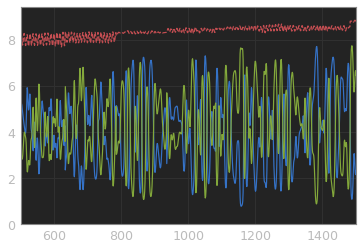

In [22]:
# in this [7.5, 9.0] window of fes eqb, the electron does not quite localize
a = na_cage[:,0,:] - e_com_cage
b = na_cage[:,1,:] - e_com_cage
dist_na1_e = np.sqrt(a[:,0]**2 + a[:,1]**2 + a[:,2]**2)
dist_na2_e = np.sqrt(b[:,0]**2 + b[:,1]**2 + b[:,2]**2)

plt.plot(dist_na1_e)
plt.plot(dist_na2_e)
plt.plot(dist_na1_e + dist_na2_e, '--')
plt.xlim([500,1500])

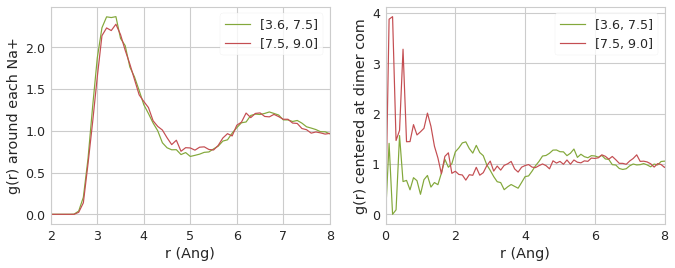

In [46]:
# g(r) centered at each Na+ and centered at dimer com
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(gr_fc[:,0], gr_fc[:,1], 'C1', label='[3.6, 7.5]')
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C2', label='[7.5, 9.0]')
plt.xlim([2,8])
plt.ylabel('g(r) around each Na+')
plt.xlabel('r (Ang)')
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.plot(gr_dimer_fc[:,0], gr_dimer_fc[:,1], 'C1', label='[3.6, 7.5]')
plt.plot(gr_dimer_cage[:,0], gr_dimer_cage[:,1], 'C2', label='[7.5, 9.0]')
plt.xlim([0,8])
plt.ylabel('g(r) centered at dimer com')
plt.xlabel('r (Ang)')
plt.legend(loc=1)

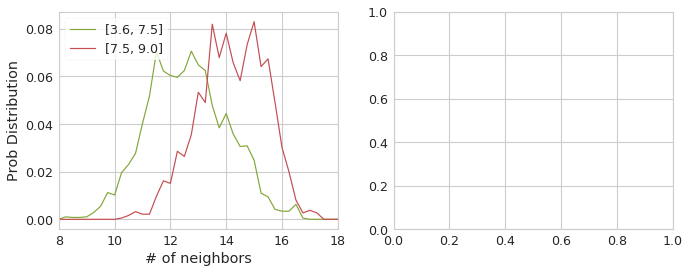

In [48]:
# Putting together plots of # neighbors and g(r) for each window
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(neighbor_counts_fc[:,0], neighbor_counts_fc[:,1]/np.sum(neighbor_counts_fc[:,1]), 'C1', label='[3.6, 7.5]')
plt.plot(neighbor_counts_cage[:,0], neighbor_counts_cage[:,1]/np.sum(neighbor_counts_cage[:,1]), 'C2', label='[7.5, 9.0]')
plt.xlim([8,18])
plt.ylabel('Prob Distribution')
plt.xlabel('# of neighbors')
plt.legend(loc=2)

plt.subplot(1,2,2)

3824.0
1855.0


Text(0,0.5,'Prob Distribution')

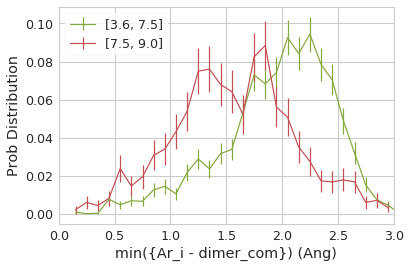

In [20]:
# distribiton of Ar-dimer_com distance
ar_dimer_fc = [np.min(np.sqrt((ar_fc[i,:,0]-(na_fc[i,0,0]+na_fc[i,1,0])/2)**2 + (ar_fc[i,:,1]-(na_fc[i,0,1]+na_fc[i,1,1])/2)**2
            + (ar_fc[i,:,2]-(na_fc[i,0,2]+na_fc[i,1,2])/2)**2)) for i in range(len(e_com_fc))]
ar_dimer_cage = [np.min(np.sqrt((ar_cage[i,:,0]-(na_cage[i,0,0]+na_cage[i,1,0])/2)**2 + (ar_cage[i,:,1]-(na_cage[i,0,1]+na_cage[i,1,1])/2)**2
            + (ar_cage[i,:,2]-(na_cage[i,0,2]+na_cage[i,1,2])/2)**2)) for i in range(len(e_com_cage))]

count_ar_dimer_fc = genDistr(ar_dimer_fc)
count_ar_dimer_cage = genDistr(ar_dimer_cage)

plt.figure(figsize=(6,4))
plt.errorbar(count_ar_dimer_fc[:,0], count_ar_dimer_fc[:,1], yerr=count_ar_dimer_fc[:,2], color='C1', label='[3.6, 7.5]')
plt.errorbar(count_ar_dimer_cage[:,0], count_ar_dimer_cage[:,1], yerr=count_ar_dimer_cage[:,2], color='C2', label='[7.5, 9.0]')
plt.legend(loc=2)
plt.xlim([0, 3.0])
plt.xlabel('min({Ar_i - dimer_com}) (Ang)')
plt.ylabel('Prob Distribution')

In [20]:
# curvature of free energy profiles from above for fc and cage in that order
print('curvature = '+'['+str(np.round((8.617333262145e-5 * 120)/(2*0.09999999999999999**2), 4))+', '+
      str(np.round((8.617333262145e-5 * 120)/(2*0.01946363670393874**2), 4))+']')

curvature = [0.517, 13.6482]


In [21]:
def coordNumber(g_r, S_r, n_solv=1600, box_dim=43.8332180561224):
    dr = g_r[1,0]-g_r[0,0]
    rho = n_solv/box_dim**3
    coord_n = 0
    for i in range(len(g_r)):
        shell_vol = 4/3*3.14159256*((g_r[i,0]+dr)**3 - g_r[i,0]**3)
        coord_n += g_r[i,1]*S_r[i]*shell_vol
    return coord_n*rho

In [33]:
S_r = 1/(np.exp(5*(gr_fc[:,0]-4.25))+1)
print('coordination number = '+str(coordNumber(gr_fc, S_r)))
print('coordination number = '+str(coordNumber(gr_cage, S_r)))

coordination number = 7.63456777653557
coordination number = 7.474518693560853


g(r) doesn't show a change in # neighbors because it can double count the belt Ar, but the way I have calculated the # neighbors ignores the double counting. To be sure, can see that integrating g(r) always gives more neighbors

#### Want to calculate overlap between electron (both ground state and excited state) and neighboring Argon

In [ ]:
# gnd/fes umbrella sampling
r0 = 3.6; r = 5.0; dr = 0.1

#root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
#dirs = '5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  \
#        6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  6.7  7.0  7.3'.split()

# root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', '4.8', '5.0']
# dirs = ['5.2', '5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5']
rho1_fc = []
#rho2_fc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            rho1_fc += [lib.readEDens(my_dir+'/rho_st1.cube', t_frames[j])[0]]
#            rho2_fc += [lib.readEDens(my_dir+'/rho_st2.cube', t_frames[j])[0]]
rho1_fc = np.array(rho1_fc, dtype='float32')
#rho2_fc = np.array(rho2_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/fes_eqb_rho1_fc1.npy', rho1_fc)
#np.save('solvent_environments/fes_eqb_rho2_fc.npy', rho2_fc)

In [ ]:
# code to calculate the overlap and save to .txt
rho = np.load('solvent_environments/gnd_eqb_rho2_fc.npy')
r_Na = np.load('solvent_environments/gnd_eqb_na_fc.npy')
r_Ar = np.load('solvent_environments/gnd_eqb_ar_fc.npy')

r_cutoff = 3.405
dens = 0.9
(l1, l2, l3) = np.shape(rho)

overlap = np.zeros(l1)
for i in range(l1):
    my_rho = -np.sort(-rho[i,:,3])

    running_sum = 0.0; n = 0
    while running_sum < dens:
        running_sum += my_rho[n]
        n += 1
    isoval = my_rho[n]

    rho[i,:,3] = 1/(np.exp(50*(isoval-rho[i,:,3]))+1)

    close_Ar = lib.closestAr(r_Na[i], r_Ar[i], n_cutoff=50, option='dimer')

    my_array = [np.min(np.sqrt((close_Ar[:,0]-rho[i,j,0])**2+(close_Ar[:,1]-rho[i,j,1])**2+(close_Ar[:,2]-rho[i,j,2])**2)) for j in range(l2)]
    my_array = 1/(np.exp(5*(np.array(my_array)-r_cutoff))+1)
    overlap[i] = np.dot(my_array, rho[i,:,3])/np.sum(rho[i,:,3])

np.savetxt('solvent_environments/gnd_ar_edens2_fc_overlap.txt', overlap)

1329.0
1329.0
1640.0
1640.0
0.3475921745673439
0.34604878048780485


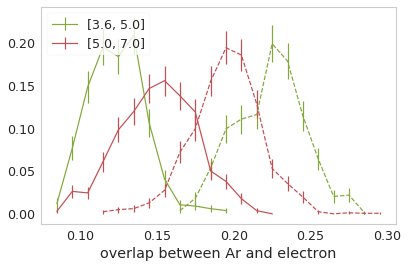

In [13]:
# Ar-e overlap for gnd eqb
overlap1 = np.loadtxt('solvent_environments/gnd_ar_edens1_fc_overlap.txt')
overlap2 = np.loadtxt('solvent_environments/gnd_ar_edens2_fc_overlap.txt')
overlap3 = np.loadtxt('solvent_environments/gnd_ar_edens1_cage_overlap.txt')
overlap4 = np.loadtxt('solvent_environments/gnd_ar_edens2_cage_overlap.txt')
overlap_distr1 = genDistr(overlap1, spacing=0.01)
overlap_distr2 = genDistr(overlap2, spacing=0.01)
overlap_distr3 = genDistr(overlap3, spacing=0.01)
overlap_distr4 = genDistr(overlap4, spacing=0.01)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

plt.errorbar(overlap_distr1[:,0], overlap_distr1[:,1], yerr=overlap_distr1[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(overlap_distr2[:,0], overlap_distr2[:,1], yerr=overlap_distr2[:,2], ls='--', color='C1')
plt.errorbar(overlap_distr3[:,0], overlap_distr3[:,1], yerr=overlap_distr3[:,2], color='C2', label='[5.0, 7.0]')
plt.errorbar(overlap_distr4[:,0], overlap_distr4[:,1], yerr=overlap_distr4[:,2], ls='--', color='C2')

plt.xlabel('overlap between Ar and electron')

plt.legend(loc=2)
plt.grid(False)

print(np.dot(overlap_distr1[:,0],overlap_distr1[:,1]) + np.dot(overlap_distr2[:,0], overlap_distr2[:,1]))
print(np.dot(overlap_distr3[:,0],overlap_distr3[:,1]) + np.dot(overlap_distr4[:,0], overlap_distr4[:,1]))

3824.0
3824.0
1855.0
1855.0
0.4059074267782427
0.37521293800539085


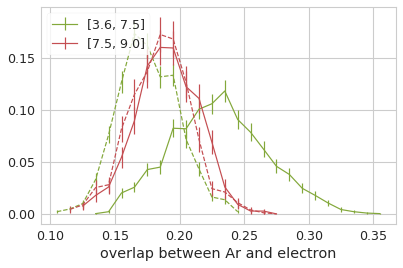

In [30]:
# Ar-e overlap for fes eqb
overlap1 = np.loadtxt('solvent_environments/fes_ar_edens1_fc_overlap.txt')
overlap2 = np.loadtxt('solvent_environments/fes_ar_edens2_fc_overlap.txt')
overlap3 = np.loadtxt('solvent_environments/fes_ar_edens1_cage_overlap.txt')
overlap4 = np.loadtxt('solvent_environments/fes_ar_edens2_cage_overlap.txt')
overlap_distr1 = genDistr(overlap1, spacing=0.01)
overlap_distr2 = genDistr(overlap2, spacing=0.01)
overlap_distr3 = genDistr(overlap3, spacing=0.01)
overlap_distr4 = genDistr(overlap4, spacing=0.01)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

plt.errorbar(overlap_distr1[:,0], overlap_distr1[:,1], yerr=overlap_distr1[:,2], color='C1', label='[3.6, 7.5]')
plt.errorbar(overlap_distr2[:,0], overlap_distr2[:,1], yerr=overlap_distr2[:,2], ls='--', color='C1')
plt.errorbar(overlap_distr3[:,0], overlap_distr3[:,1], yerr=overlap_distr3[:,2], color='C2', label='[7.5, 9.0]')
plt.errorbar(overlap_distr4[:,0], overlap_distr4[:,1], yerr=overlap_distr4[:,2], ls='--', color='C2')

plt.xlabel('overlap between Ar and electron')

plt.legend(loc=2)

print(np.dot(overlap_distr1[:,0],overlap_distr1[:,1]) + np.dot(overlap_distr2[:,0], overlap_distr2[:,1]))
print(np.dot(overlap_distr3[:,0],overlap_distr3[:,1]) + np.dot(overlap_distr4[:,0], overlap_distr4[:,1]))

1329.0
1329.0
1640.0
1640.0
0.15936042136945072
0.19691463414634147


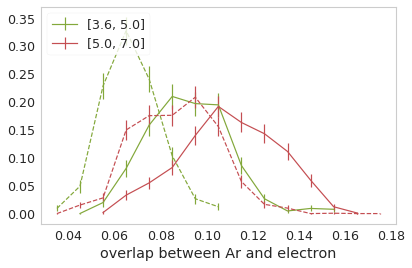

In [11]:
# Ar-e overlap for gnd eqb
overlap1 = np.loadtxt('solvent_environments/intra/gnd_ar_edens1_fc_overlap.txt')
overlap2 = np.loadtxt('solvent_environments/intra/gnd_ar_edens2_fc_overlap.txt')
overlap3 = np.loadtxt('solvent_environments/intra/gnd_ar_edens1_cage_overlap.txt')
overlap4 = np.loadtxt('solvent_environments/intra/gnd_ar_edens2_cage_overlap.txt')
overlap_distr1 = genDistr(overlap1, spacing=0.01)
overlap_distr2 = genDistr(overlap2, spacing=0.01)
overlap_distr3 = genDistr(overlap3, spacing=0.01)
overlap_distr4 = genDistr(overlap4, spacing=0.01)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

plt.errorbar(overlap_distr1[:,0], overlap_distr1[:,1], yerr=overlap_distr1[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(overlap_distr2[:,0], overlap_distr2[:,1], yerr=overlap_distr2[:,2], ls='--', color='C1')
plt.errorbar(overlap_distr3[:,0], overlap_distr3[:,1], yerr=overlap_distr3[:,2], color='C2', label='[5.0, 7.0]')
plt.errorbar(overlap_distr4[:,0], overlap_distr4[:,1], yerr=overlap_distr4[:,2], ls='--', color='C2')

plt.xlabel('overlap between Ar and electron')

plt.legend(loc=2)
plt.grid(False)

print(np.dot(overlap_distr1[:,0],overlap_distr1[:,1]) + np.dot(overlap_distr2[:,0], overlap_distr2[:,1]))
print(np.dot(overlap_distr3[:,0],overlap_distr3[:,1]) + np.dot(overlap_distr4[:,0], overlap_distr4[:,1]))

3824.0
3824.0
1855.0
1855.0
0.2774424686192468
0.2215471698113207


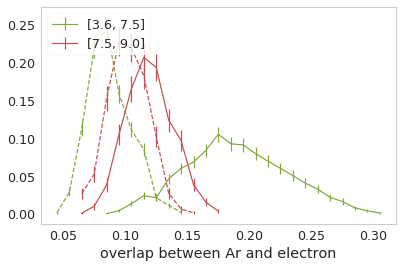

In [12]:
# Ar-e overlap for fes eqb
overlap1 = np.loadtxt('solvent_environments/intra/fes_ar_edens1_fc_overlap.txt')
overlap2 = np.loadtxt('solvent_environments/intra/fes_ar_edens2_fc_overlap.txt')
overlap3 = np.loadtxt('solvent_environments/intra/fes_ar_edens1_cage_overlap.txt')
overlap4 = np.loadtxt('solvent_environments/intra/fes_ar_edens2_cage_overlap.txt')
overlap_distr1 = genDistr(overlap1, spacing=0.01)
overlap_distr2 = genDistr(overlap2, spacing=0.01)
overlap_distr3 = genDistr(overlap3, spacing=0.01)
overlap_distr4 = genDistr(overlap4, spacing=0.01)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

plt.errorbar(overlap_distr1[:,0], overlap_distr1[:,1], yerr=overlap_distr1[:,2], color='C1', label='[3.6, 7.5]')
plt.errorbar(overlap_distr2[:,0], overlap_distr2[:,1], yerr=overlap_distr2[:,2], ls='--', color='C1')
plt.errorbar(overlap_distr3[:,0], overlap_distr3[:,1], yerr=overlap_distr3[:,2], color='C2', label='[7.5, 9.0]')
plt.errorbar(overlap_distr4[:,0], overlap_distr4[:,1], yerr=overlap_distr4[:,2], ls='--', color='C2')

plt.xlabel('overlap between Ar and electron')

plt.legend(loc=2)
plt.grid(False)

print(np.dot(overlap_distr1[:,0],overlap_distr1[:,1]) + np.dot(overlap_distr2[:,0], overlap_distr2[:,1]))
print(np.dot(overlap_distr3[:,0],overlap_distr3[:,1]) + np.dot(overlap_distr4[:,0], overlap_distr4[:,1]))

### Looking at solvent structure corresponding to fes eqb gaussians. Ranges [3.6, 5.8], [5.8, 6.9], [6.9, 7.6], [7.6, 9.0]

In [ ]:
# binning data according to ranges [3.6 Ang, 5.8 Ang]
# fes umbrella sampling

# [FC/pre-caging]
r0 = 3.6; r = 5.8; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
# had to break this up into 2 steps, save and then append
dirs = ['3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1']
na_fc = []; ar_fc = []; e_com_fc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_fc += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_fc += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_fc += [my_e_com[j*tau,1:]]
na_fc = np.array(na_fc, dtype='float32'); ar_fc = np.array(ar_fc, dtype='float32'); e_com_fc = np.array(e_com_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/fes_eqb_na36-58.npy', na_fc)
np.save('solvent_environments/fes_eqb_ar36-58.npy', ar_fc)
np.save('solvent_environments/fes_eqb_ecom36-58.npy', e_com_fc)

In [ ]:
# binning data according to ranges [5.8 Ang, 6.9 Ang]
# fes umbrella sampling

# [FC/pre-caging]
r0 = 5.8; r = 6.9; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
# had to break this up into 2 steps, save and then append
dirs = ['5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', '7.2']
na_fc = []; ar_fc = []; e_com_fc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_fc += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_fc += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_fc += [my_e_com[j*tau,1:]]
na_fc = np.array(na_fc, dtype='float32'); ar_fc = np.array(ar_fc, dtype='float32'); e_com_fc = np.array(e_com_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/fes_eqb_na58-69.npy', na_fc)
np.save('solvent_environments/fes_eqb_ar58-69.npy', ar_fc)
np.save('solvent_environments/fes_eqb_ecom58-69.npy', e_com_fc)

In [ ]:
# binning data according to ranges [6.9 Ang, 7.6 Ang]
# fes umbrella sampling

# [FC/pre-caging]
r0 = 6.9; r = 7.6; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
# had to break this up into 2 steps, save and then append
dirs = ['6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5', '7.6', '7.8']
na_fc = []; ar_fc = []; e_com_fc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_fc += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_fc += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_fc += [my_e_com[j*tau,1:]]
na_fc = np.array(na_fc, dtype='float32'); ar_fc = np.array(ar_fc, dtype='float32'); e_com_fc = np.array(e_com_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/fes_eqb_na69-76.npy', na_fc)
np.save('solvent_environments/fes_eqb_ar69-76.npy', ar_fc)
np.save('solvent_environments/fes_eqb_ecom69-76.npy', e_com_fc)

In [ ]:
# binning data according to ranges [7.6 Ang, 9.0 Ang]
# fes umbrella sampling

# [FC/pre-caging]
r0 = 7.6; r = 9.0; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
# had to break this up into 2 steps, save and then append
dirs = ['7.0', '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
na_fc = []; ar_fc = []; e_com_fc = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    my_eigvals = lib.readEigval(my_dir, nstates=5)[500:]
    my_e_com = lib.readEcom(my_dir)[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            na_fc += [lib.readNa(my_dir+'/out.na', t_frames[j])]
            ar_fc += [lib.readAr(my_dir+'/out.water', t_frames[j])]
            e_com_fc += [my_e_com[j*tau,1:]]
na_fc = np.array(na_fc, dtype='float32'); ar_fc = np.array(ar_fc, dtype='float32'); e_com_fc = np.array(e_com_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/fes_eqb_na76-90.npy', na_fc)
np.save('solvent_environments/fes_eqb_ar76-90.npy', ar_fc)
np.save('solvent_environments/fes_eqb_ecom76-90.npy', e_com_fc)

In [4]:
# Loading data for range [3.6, 5.8]
na1 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na36-58.npy')
ar1 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar36-58.npy')
e_com1 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom36-58.npy')

12.161011540161487 0.026398947314304366


Text(0.5,0,'num of neighbors')

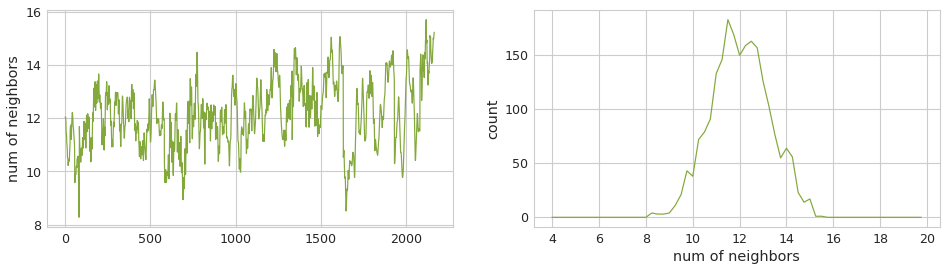

In [10]:
# Num of Neighbors, [3.6, 5.8]
r_cutoff = 4.25; kappa = 0.2
neighbors1 = np.zeros(len(na1))
for i in range(len(na1)):
    my_bond_dist = lib.dist(na1[i,0], na1[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na1[i,0], ar1[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na1[i,1], ar1[i])-r_cutoff)/kappa))

    neighbors1[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors1), stats.sem(neighbors1))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts1 = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors1)):
    my_ind = int((neighbors1[i]-n0)/dn)
    neighbor_counts1[my_ind] += 1
neighbor_counts1[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors1, 'C1')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts1[:,0], neighbor_counts1[:,1], 'C1')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [44]:
# radial distr fxn using radial distance and averaging over both Na's, [3.6, 5.8]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr1 = np.zeros([len(bins_radial_na),2])

for i in range(len(na1)):
    r_na1_ar = ar1[i] - np.repeat([na1[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar1[i] - np.repeat([na1[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr1[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr1[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr1)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr1[j,1] /= (V2-V1)*2*rho
gr1[:,1] /= len(na1)
gr1[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer1 = np.zeros([len(bins_radial_com),2])

for i in range(len(na1)):
    r_na_ar = ar1[i] - np.repeat([(na1[i,0]+na1[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer1[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer1)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer1[j,1] /= (V2-V1)*rho
gr_dimer1[:,1] /= len(na1)
gr_dimer1[:,0] = bins_radial_com

# radial distr fxn using elliptical (dimer) distance, fc
r0 = 4; r = 20; dr = 0.2
bins_elliptical1 = np.arange(r0,r,dr)
counts_elliptical1 = np.zeros(len(bins_elliptical1))

for i in range(len(na1)):
    r_na1_ar = ar1[i] - np.repeat([na1[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar1[i] - np.repeat([na1[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical1[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical1)):
    V1 = 4*np.pi/27 * bins_elliptical1[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical1[j]+dr)**3
    counts_elliptical1[j] /= (V2-V1)*rho
counts_elliptical1 /= len(na1)

Text(0.5,1,'g(r) elliptical dist')

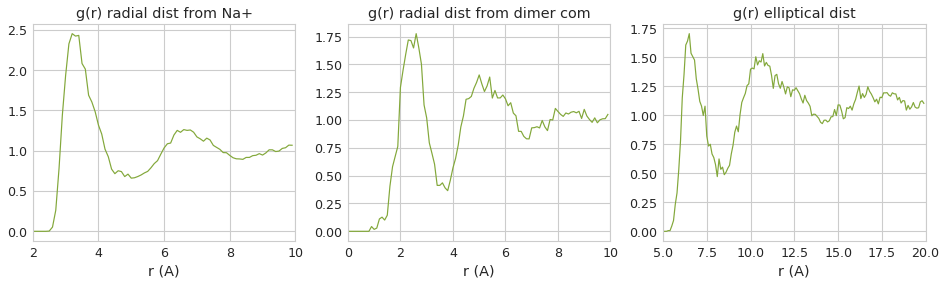

In [9]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr1[:,0], gr1[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer1[:,0], gr_dimer1[:,1], 'C1')
plt.xlim([0,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical1, counts_elliptical1, 'C1')
plt.xlim([5,20])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [12]:
print('g(r) max: '+str(gr1[np.argwhere(gr1[:,1] == np.max(gr1[:,1]))[0][0]]))

g(r) max: [3.2        2.45224299]


In [20]:
# radial distr fxn using radial distance and without averaging over both Na's, [3.6, 5.8]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr1 = np.zeros([len(bins_radial_na),3])

for i in range(len(na1)):
    r_na1_ar = ar1[i] - np.repeat([na1[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar1[i] - np.repeat([na1[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na1[i,0], e_com1[i]), lib.dist(na1[i,1], e_com1[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr1[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr1[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr1[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr1[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr1)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr1[j,1:] /= (V2-V1)*rho
gr1[:,1:] /= len(na1)
gr1[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

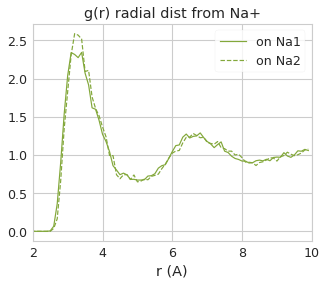

In [21]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr1[:,0], gr1[:,1], 'C1', label='on Na1')
plt.plot(gr1[:,0], gr1[:,2], '--C1', label='on Na2')
plt.xlim([2,10])
plt.legend(loc=1)
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')

Text(0.5,0,'e_com relative to bond axis (reduced units)')

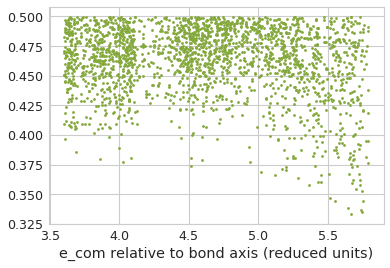

In [32]:
# distribution of e_com relative to Na positions
na_ecom1 = np.zeros([len(na1), 2])
for i in range(len(na1)):
    r_bond = (na1[i,1] - na1[i,0])/lib.dist(na1[i,1], na1[i,0])
    na_ecom = np.dot(e_com1[i] - na1[i,0], r_bond)/lib.dist(na1[i,1], na1[i,0])
    
    na_ecom1[i] = [lib.dist(na1[i,1], na1[i,0]), na_ecom]
na_ecom1[:,1] = 0.5 - np.abs(na_ecom1[:,1] - 0.5)

plt.plot(na_ecom1[:,0], na_ecom1[:,1], '.C1')
plt.xlabel('e_com relative to bond axis (reduced units)')

In [5]:
# Loading data for range [5.8, 6.9]
na2 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na58-69.npy')
ar2 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar58-69.npy')
e_com2 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom58-69.npy')

13.536724563930935 0.03943172992209643


Text(0.5,0,'num of neighbors')

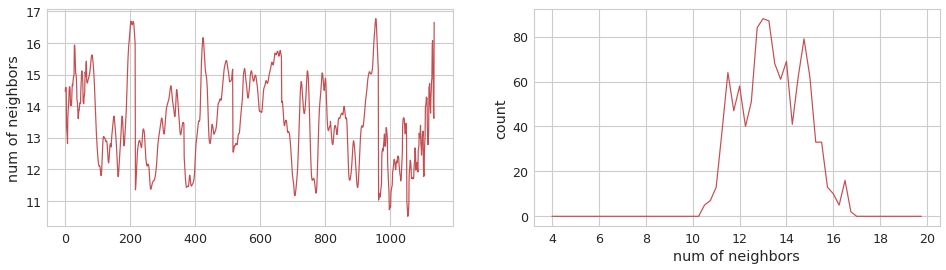

In [38]:
# Num of Neighbors, [5.8, 6.9]
r_cutoff = 4.25; kappa = 0.2
neighbors2 = np.zeros(len(na2))
for i in range(len(na2)):
    my_bond_dist = lib.dist(na2[i,0], na2[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na2[i,0], ar2[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na2[i,1], ar2[i])-r_cutoff)/kappa))

    neighbors2[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors2), stats.sem(neighbors2))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts2 = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors2)):
    my_ind = int((neighbors2[i]-n0)/dn)
    neighbor_counts2[my_ind] += 1
neighbor_counts2[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors2, 'C2')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts2[:,0], neighbor_counts2[:,1], 'C2')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [43]:
# radial distr fxn using radial distance and averaging over both Na's, [5.8, 6.9]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr2 = np.zeros([len(bins_radial_na),2])

for i in range(len(na2)):
    r_na1_ar = ar2[i] - np.repeat([na2[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar2[i] - np.repeat([na2[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr2[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr2[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr2)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr2[j,1] /= (V2-V1)*2*rho
gr2[:,1] /= len(na2)
gr2[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer2 = np.zeros([len(bins_radial_com),2])

for i in range(len(na2)):
    r_na_ar = ar2[i] - np.repeat([(na2[i,0]+na2[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer2[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer2)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer2[j,1] /= (V2-V1)*rho
gr_dimer2[:,1] /= len(na2)
gr_dimer2[:,0] = bins_radial_com

# radial distr fxn using elliptical2 (dimer) distance, fc
r0 = 4; r = 20; dr = 0.2
bins_elliptical2 = np.arange(r0,r,dr)
counts_elliptical2 = np.zeros(len(bins_elliptical2))

for i in range(len(na2)):
    r_na1_ar = ar2[i] - np.repeat([na2[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar2[i] - np.repeat([na2[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical2[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical2)):
    V1 = 4*np.pi/27 * bins_elliptical2[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical2[j]+dr)**3
    counts_elliptical2[j] /= (V2-V1)*rho
counts_elliptical2 /= len(na2)

Text(0.5,1,'g(r) elliptical dist')

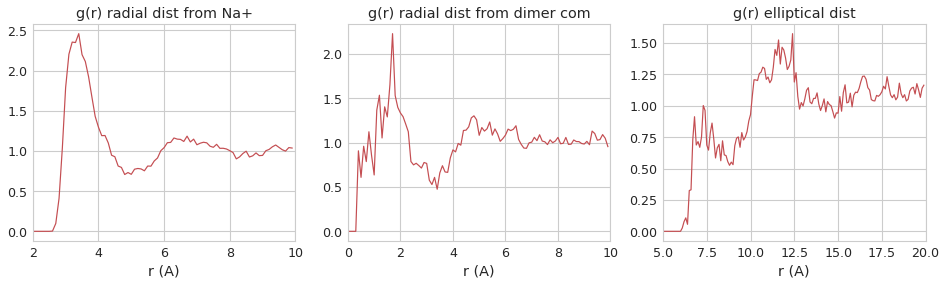

In [40]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr2[:,0], gr2[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer2[:,0], gr_dimer2[:,1], 'C2')
plt.xlim([0,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical, counts_elliptical, 'C2')
plt.xlim([5,20])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [41]:
print('g(r) max: '+str(gr2[np.argwhere(gr2[:,1] == np.max(gr2[:,1]))[0][0]]))

g(r) max: [3.4        2.45953947]


In [42]:
# radial distr fxn using radial distance and without averaging over both Na's, [5.8, 6.9]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr2 = np.zeros([len(bins_radial_na),3])

for i in range(len(na2)):
    r_na1_ar = ar2[i] - np.repeat([na2[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar2[i] - np.repeat([na2[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na2[i,0], e_com2[i]), lib.dist(na2[i,1], e_com2[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr2[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr2[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr2[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr2[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr2)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr2[j,1:] /= (V2-V1)*rho
gr2[:,1:] /= len(na2)
gr2[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

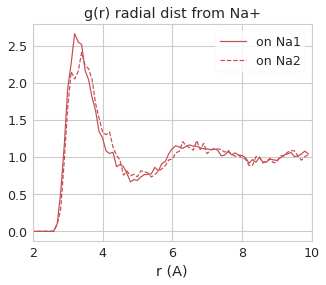

In [43]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr2[:,0], gr2[:,1], 'C2', label='on Na1')
plt.plot(gr2[:,0], gr2[:,2], '--C2', label='on Na2')
plt.xlim([2,10])
plt.legend(loc=1)
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')

Text(0.5,0,'e_com relative to bond axis (reduced units)')

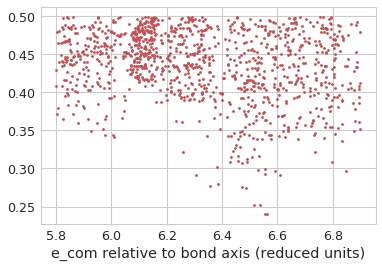

In [33]:
# distribution of e_com relative to Na positions
na_ecom2 = np.zeros([len(na2), 2])
for i in range(len(na2)):
    r_bond = (na2[i,1] - na2[i,0])/lib.dist(na2[i,1], na2[i,0])
    na_ecom = np.dot(e_com2[i] - na2[i,0], r_bond)/lib.dist(na2[i,1], na2[i,0])
    
    na_ecom2[i] = [lib.dist(na2[i,1], na2[i,0]), na_ecom]
na_ecom2[:,1] = 0.5 - np.abs(na_ecom2[:,1] - 0.5)

plt.plot(na_ecom2[:,0], na_ecom2[:,1], '.C2')
plt.xlabel('e_com relative to bond axis (reduced units)')

In [6]:
# Loading data for range [6.9, 7.6]
na3 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na69-76.npy')
ar3 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar69-76.npy')
e_com3 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom69-76.npy')

13.590531367923026 0.04897875301457589


Text(0.5,0,'num of neighbors')

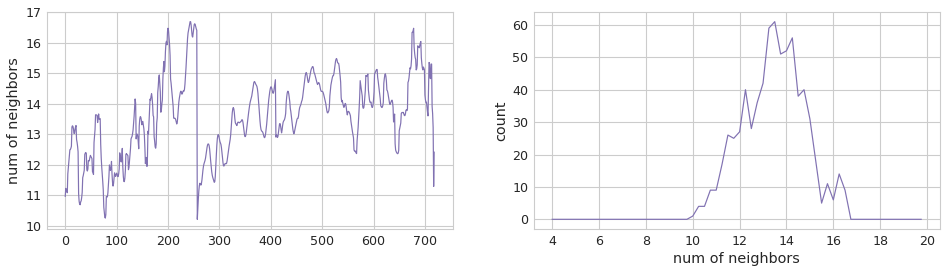

In [18]:
# Num of Neighbors, [6.9, 7.4]
r_cutoff = 4.25; kappa = 0.2
neighbors3 = np.zeros(len(na3))
for i in range(len(na3)):
    my_bond_dist = lib.dist(na3[i,0], na3[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na3[i,0], ar3[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na3[i,1], ar3[i])-r_cutoff)/kappa))

    neighbors3[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors3), stats.sem(neighbors3))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts3 = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors3)):
    my_ind = int((neighbors3[i]-n0)/dn)
    neighbor_counts3[my_ind,1] += 1
neighbor_counts3[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors3, 'C3')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts3[:,0], neighbor_counts3[:,1], 'C3')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [42]:
# radial distr fxn using radial distance and averaging over both Na's, [6.9, 7.6]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr3 = np.zeros([len(bins_radial_na),2])

for i in range(len(na3)):
    r_na1_ar = ar3[i] - np.repeat([na3[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar3[i] - np.repeat([na3[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr3[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr3[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr3)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr3[j,1] /= (V2-V1)*2*rho
gr3[:,1] /= len(na3)
gr3[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer3 = np.zeros([len(bins_radial_com),2])

for i in range(len(na3)):
    r_na_ar = ar3[i] - np.repeat([(na3[i,0]+na3[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer3[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer3)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer3[j,1] /= (V2-V1)*rho
gr_dimer3[:,1] /= len(na3)
gr_dimer3[:,0] = bins_radial_com

# radial distr fxn using elliptical3 (dimer) distance, fc
r0 = 4; r = 20; dr = 0.2
bins_elliptical3 = np.arange(r0,r,dr)
counts_elliptical3 = np.zeros(len(bins_elliptical3))

for i in range(len(na3)):
    r_na1_ar = ar3[i] - np.repeat([na3[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar3[i] - np.repeat([na3[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical3[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical3)):
    V1 = 4*np.pi/27 * bins_elliptical3[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical3[j]+dr)**3
    counts_elliptical3[j] /= (V2-V1)*rho
counts_elliptical3 /= len(na3)

Text(0.5,1,'g(r) elliptical dist')

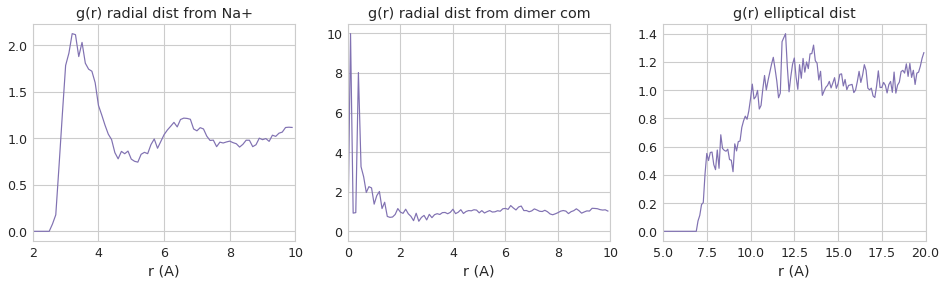

In [20]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr3[:,0], gr3[:,1], 'C3')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer3[:,0], gr_dimer3[:,1], 'C3')
plt.xlim([0,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical3, counts_elliptical3, 'C3')
plt.xlim([5,20])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [21]:
print('g(r) max: '+str(gr3[np.argwhere(gr3[:,1] == np.max(gr3[:,1]))[0][0]]))

g(r) max: [3.2        2.12329861]


In [23]:
# radial distr fxn using radial distance and without averaging over both Na's, [6.9, 7.6]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr3 = np.zeros([len(bins_radial_na),3])

for i in range(len(na3)):
    r_na1_ar = ar3[i] - np.repeat([na3[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar3[i] - np.repeat([na3[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na3[i,0], e_com3[i]), lib.dist(na3[i,1], e_com3[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr3[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr3[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr3[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr3[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr3)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr3[j,1:] /= (V2-V1)*rho
gr3[:,1:] /= len(na3)
gr3[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

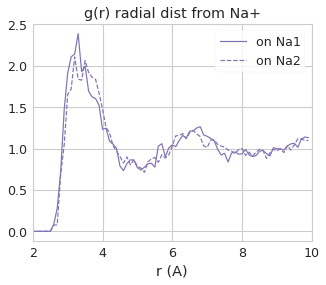

In [25]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr3[:,0], gr3[:,1], 'C3', label='on Na1')
plt.plot(gr3[:,0], gr3[:,2], '--C3', label='on Na2')
plt.xlim([2,10])
plt.legend(loc=1)
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')

Text(0.5,0,'e_com relative to bond axis (reduced units)')

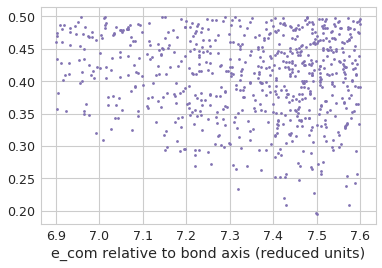

In [34]:
# distribution of e_com relative to Na positions
na_ecom3 = np.zeros([len(na3), 2])
for i in range(len(na3)):
    r_bond = (na3[i,1] - na3[i,0])/lib.dist(na3[i,1], na3[i,0])
    na_ecom = np.dot(e_com3[i] - na3[i,0], r_bond)/lib.dist(na3[i,1], na3[i,0])
    
    na_ecom3[i] = [lib.dist(na3[i,1], na3[i,0]), na_ecom]
na_ecom3[:,1] = 0.5 - np.abs(na_ecom3[:,1] - 0.5)

plt.plot(na_ecom3[:,0], na_ecom3[:,1], '.C3')
plt.xlabel('e_com relative to bond axis (reduced units)')

In [7]:
# Loading data for range [7.6, 9.0]
na4 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na76-90.npy')
ar4 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar76-90.npy')
e_com4 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom76-90.npy')

14.35761244711603 0.029197545634916593


Text(0.5,0,'num of neighbors')

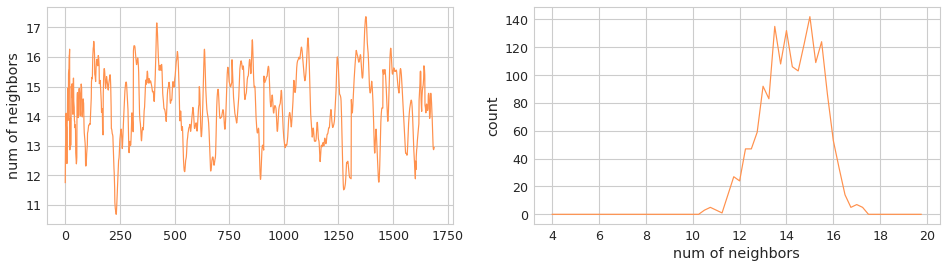

In [28]:
# Num of Neighbors, [7.6, 9.0]
r_cutoff = 4.25; kappa = 0.2
neighbors4 = np.zeros(len(na4))
for i in range(len(na4)):
    my_bond_dist = lib.dist(na4[i,0], na4[i,1])
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na4[i,0], ar4[i])-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na4[i,1], ar4[i])-r_cutoff)/kappa))

    neighbors4[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors4), stats.sem(neighbors4))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts4 = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors4)):
    my_ind = int((neighbors4[i]-n0)/dn)
    neighbor_counts4[my_ind,1] += 1
neighbor_counts4[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors4, 'C4')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts4[:,0], neighbor_counts4[:,1], 'C4')
plt.ylabel('count')
plt.xlabel('num of neighbors')

In [122]:
# radial distr fxn using radial distance and averaging over both Na's, [7.6, 9.0]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr4 = np.zeros([len(bins_radial_na),2])

for i in range(len(na4)):
    r_na1_ar = ar4[i] - np.repeat([na4[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar4[i] - np.repeat([na4[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr4[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr4[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr4)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr4[j,1] /= (V2-V1)*2*rho
gr4[:,1] /= len(na4)
gr4[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer4 = np.zeros([len(bins_radial_com),2])

for i in range(len(na4)):
    r_na_ar = ar4[i] - np.repeat([(na4[i,0]+na4[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer4[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer4)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer4[j,1] /= (V2-V1)*rho
gr_dimer4[:,1] /= len(na4)
gr_dimer4[:,0] = bins_radial_com

# radial distr fxn using elliptical4 (dimer) distance, [7.6, 9.0]
r0 = 0; r = 10; dr = 0.2
bins_elliptical4 = np.arange(r0,r,dr)/2
counts_elliptical4 = np.zeros(len(bins_elliptical4))

for i in range(len(na4)):
    r_na1_ar = ar4[i] - np.repeat([na4[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar4[i] - np.repeat([na4[i,1]], repeats=1600, axis=0)
    bond_dist = lib.dist(na4[i,0], na4[i,1])
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    dimer_dist -= bond_dist
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            dV = 4*np.pi/27*(((my_ind+1)*dr+bond_dist)**3 - (my_ind*dr+bond_dist)**3)
            counts_elliptical4[my_ind] += 1/dV

rho = 1600/(43.8332180561224**3)
# for j in range(len(counts_elliptical4)):
#     V1 = 4*np.pi/27 * (bins_elliptical4[j]+8.3)**3
#     V2 = 4*np.pi/27 * (bins_elliptical4[j]+dr+8.3)**3
#     counts_elliptical4[j] /= (V2-V1)*rho
counts_elliptical4 /= len(na4)*rho

In [116]:
np.sort(dimer_dist)

array([ 0.8590107,  0.9589691,  1.1507168, ..., 65.58525  , 66.17056  ,
       67.91157  ], dtype=float32)

Text(0.5,1,'g(r) elliptical dist')

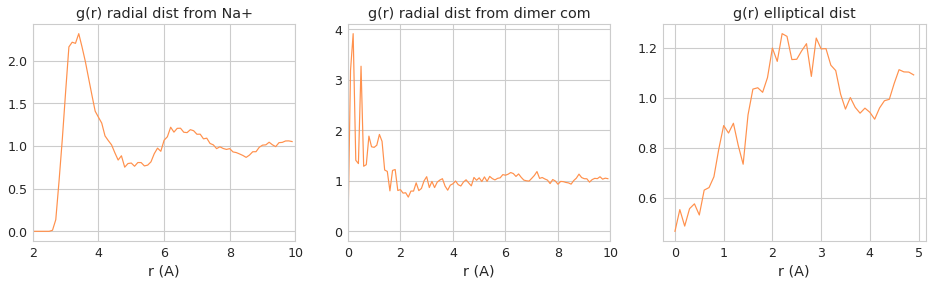

In [123]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr4[:,0], gr4[:,1], 'C4')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer4[:,0], gr_dimer4[:,1], 'C4')
plt.xlim([0,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
plt.subplot(1,3,3)
plt.plot(bins_elliptical4, counts_elliptical4, 'C4')
#plt.xlim([5,20])
# plt.ylim([0,100])
plt.xlabel('r (A)')
plt.title('g(r) elliptical dist')

In [31]:
print('g(r) max: '+str(gr4[np.argwhere(gr4[:,1] == np.max(gr4[:,1]))[0][0]]))

g(r) max: [3.4       2.3167905]


In [32]:
# radial distr fxn using radial distance and without averaging over both Na's, [7.6, 9.0]
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr4 = np.zeros([len(bins_radial_na),3])

for i in range(len(na4)):
    r_na1_ar = ar4[i] - np.repeat([na4[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar4[i] - np.repeat([na4[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na4[i,0], e_com4[i]), lib.dist(na4[i,1], e_com4[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr4[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr4[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr4[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr4[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr4)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr4[j,1:] /= (V2-V1)*rho
gr4[:,1:] /= len(na4)
gr4[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

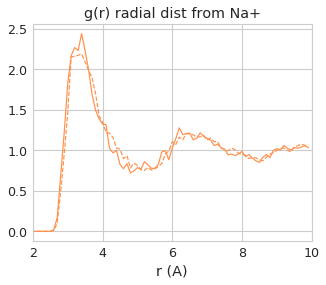

In [33]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr4[:,0], gr4[:,1], 'C4', label='Na1')
plt.plot(gr4[:,0], gr4[:,2], '--C4', label='Na2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')

Text(0.5,0,'e_com relative to bond axis (reduced units)')

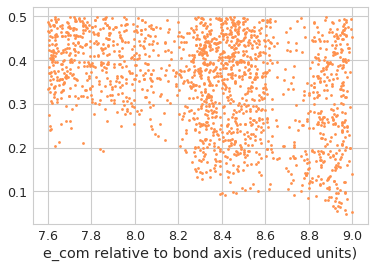

In [35]:
# distribution of e_com relative to Na positions
na_ecom4 = np.zeros([len(na4), 2])
for i in range(len(na4)):
    r_bond = (na4[i,1] - na4[i,0])/lib.dist(na4[i,1], na4[i,0])
    na_ecom = np.dot(e_com4[i] - na4[i,0], r_bond)/lib.dist(na4[i,1], na4[i,0])
    
    na_ecom4[i] = [lib.dist(na4[i,1], na4[i,0]), na_ecom]
na_ecom4[:,1] = 0.5 - np.abs(na_ecom4[:,1] - 0.5)

plt.plot(na_ecom4[:,0], na_ecom4[:,1], '.C4')
plt.xlabel('e_com relative to bond axis (reduced units)')

In [95]:
# radial distr fxn using radial distance from dimer com, [3.6, 5.8] & [5.8, 6.9]
r0 = 0; r = 10; dr = 0.25
bins_radial_com = np.arange(r0,r,dr)
gr_dimer1 = np.zeros([len(bins_radial_com),3])

for i in range(len(na1)):
    r_na_ar = ar1[i] - np.repeat([(na1[i,0]+na1[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer1[my_ind,1] += 1

gr_dimer1[:,2] = gr_dimer1[:,1]
rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer1)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer1[j,1] /= (V2-V1)*rho
    gr_dimer1[j,2] /= (V2-V1)*rho*np.sqrt(gr_dimer1[j,2])
gr_dimer1[:,1] /= len(na1)
gr_dimer1[:,2] /= len(na1)
gr_dimer1[:,0] = bins_radial_com

r0 = 0; r = 10; dr = 0.25
bins_radial_com = np.arange(r0,r,dr)
gr_dimer2 = np.zeros([len(bins_radial_com),3])

for i in range(len(na2)):
    r_na_ar = ar2[i] - np.repeat([(na2[i,0]+na2[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer2[my_ind,1] += 1

gr_dimer2[:,2] = gr_dimer2[:,1]
rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer2)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer2[j,1] /= (V2-V1)*rho
    gr_dimer2[j,2] /= (V2-V1)*rho*np.sqrt(gr_dimer2[j,2])
gr_dimer2[:,1] /= len(na2)
gr_dimer2[:,2] /= len(na2)
gr_dimer2[:,0] = bins_radial_com

/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


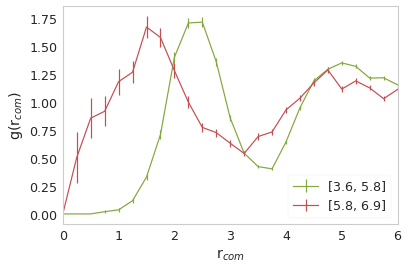

In [102]:
plt.rcParams.update({'font.size': 14})
plt.errorbar(gr_dimer1[:,0], gr_dimer1[:,1], yerr=gr_dimer1[:,2], label='[3.6, 5.8]', color='C1')
plt.errorbar(gr_dimer2[:,0], gr_dimer2[:,1], yerr=gr_dimer2[:,2], label='[5.8, 6.9]', color='C2')
plt.legend(loc=4)
plt.ylabel('g(r$_{com}$)')
plt.xlabel('r$_{com}$')
plt.xlim([0,6])
plt.grid(False)

plt.savefig('fes_rdf_dimer.eps', format='eps')

In [136]:
%matplotlib inline

In [46]:
def ellipticalRDF(r_Na, r_Ar, avg_bond_length, r, r0, dr):
    bins = np.arange(r0,r+dr,dr)
    elliptical_rdf = np.zeros([len(bins),3])
    raw_counts = np.zeros(len(bins))

    for i in range(len(r_Na)):
        r_na1_ar = r_Ar[i] - np.repeat([r_Na[i,0]], repeats=1600, axis=0)
        r_na2_ar = r_Ar[i] - np.repeat([r_Na[i,1]], repeats=1600, axis=0)
        bond_dist = lib.dist(r_Na[i,0], r_Na[i,1])
        dimer_dist = np.sqrt(np.sum(r_na1_ar**2, axis=1)) + np.sqrt(np.sum(r_na2_ar**2, axis=1)) - bond_dist

        for j in range(len(dimer_dist)):
            if dimer_dist[j] < r+dr and dimer_dist[j] > r0:
                my_ind = int((dimer_dist[j]-r0)/dr)
                dV = 4*np.pi/27*(((my_ind+1)*dr+bond_dist)**3 - (my_ind*dr+bond_dist)**3)
                elliptical_rdf[my_ind, 1] += 1/dV
                raw_counts[my_ind] += 1

    elliptical_rdf[:,2] = np.sqrt(raw_counts)
    for i in range(len(bins)):
        deltaV = 4*np.pi/27*((bins[i]+dr+avg_bond_length)**3 - (bins[i]+avg_bond_length)**3)
        elliptical_rdf[i,2] /= deltaV
    rho = 1600/(43.8332180561224**3)
    elliptical_rdf /= len(r_Na)*rho
    raw_counts /= len(r_Na)
    elliptical_rdf[:,0] = bins
    
    return elliptical_rdf, raw_counts

In [47]:
elliptical_rdf1, raw_counts1 = ellipticalRDF(na1, ar1, 4.7, 6, 0, 0.25)
elliptical_rdf2, raw_counts2 = ellipticalRDF(na2, ar2, 6.35, 6, 0, 0.25)
elliptical_rdf3, raw_counts3 = ellipticalRDF(na3, ar3, 7.25, 6, 0, 0.25)
elliptical_rdf4, raw_counts4 = ellipticalRDF(na4, ar4, 8.3, 6, 0, 0.25)

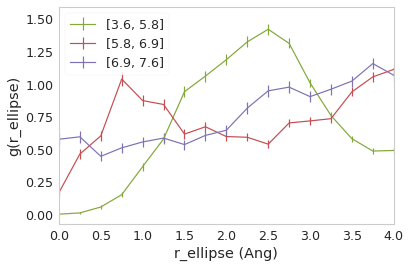

In [48]:
#comparing elliptical g(r)
plt.errorbar(elliptical_rdf1[:,0], elliptical_rdf1[:,1], yerr=elliptical_rdf1[:,2], color='C1', label='[3.6, 5.8]')
plt.errorbar(elliptical_rdf2[:,0], elliptical_rdf2[:,1], yerr=elliptical_rdf2[:,2], color='C2', label='[5.8, 6.9]')
plt.errorbar(elliptical_rdf3[:,0], elliptical_rdf3[:,1], yerr=elliptical_rdf3[:,2], color='C3', label='[6.9, 7.6]')
# plt.errorbar(elliptical_rdf4[:,0], elliptical_rdf4[:,1], yerr=elliptical_rdf4[:,2], color='C4', label='[7.6, 9.0]')

plt.xlim([0, 4])
plt.legend(loc=2)
plt.xlabel('r_ellipse (Ang)')
plt.ylabel('g(r_ellipse)')
plt.grid(False)
plt.savefig('fes_elliptical_rdf.eps', format='eps')

Ultimately, these elliptical distribution functions showed the cleanest difference in solvent environments

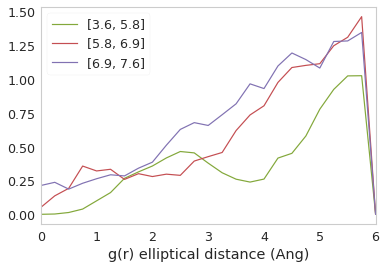

In [49]:
#comparing integral of elliptical g(r)
plt.plot(elliptical_rdf1[:,0], raw_counts1, 'C1', label='[3.6, 5.8]')
plt.plot(elliptical_rdf2[:,0], raw_counts2, 'C2', label='[5.8, 6.9]')
plt.plot(elliptical_rdf3[:,0], raw_counts3, 'C3', label='[6.9, 7.6]')
# plt.plot(bins_elliptical4, raw_counts4, 'C4', label='[7.6, 9.0]')
plt.xlim([0, 6])
plt.legend(loc=2)
plt.xlabel('g(r) elliptical distance (Ang)')
plt.grid(False)

In [35]:
print(np.sum(raw_counts1[:8]), np.sum(raw_counts2[:8]), np.sum(raw_counts3[:8]), np.sum(raw_counts4[:8]))
print(np.sum(raw_counts1[8:16]), np.sum(raw_counts2[8:16]), np.sum(raw_counts3[8:16]), np.sum(raw_counts4[8:16]))
print(np.sum(raw_counts1[16:24]), np.sum(raw_counts2[16:24]), np.sum(raw_counts3[16:24]), np.sum(raw_counts4[16:24]))

0.8942751615881811 1.9471830985915493 2.0445062586926284 2.8069863824748373
2.8739612188365653 3.492957746478873 5.372739916550765 6.432800473653049
5.451061865189289 9.088028169014084 9.342141863699585 11.251628182356423


Text(0.5,0,'bond dist (Ang)')

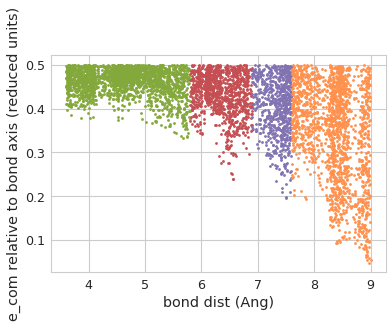

In [36]:
# distribution of e_com relative to Na positions
plt.plot(na_ecom1[:,0], na_ecom1[:,1], '.C1')
plt.plot(na_ecom2[:,0], na_ecom2[:,1], '.C2')
plt.plot(na_ecom3[:,0], na_ecom3[:,1], '.C3')
plt.plot(na_ecom4[:,0], na_ecom4[:,1], '.C4')
plt.ylabel('e_com relative to bond axis (reduced units)')
plt.xlabel('bond dist (Ang)')

In [51]:
# Loading data for range [5.8, 6.9]
na2 = np.load('solvent_environments/fes_eqb_na58-69.npy')
ar2 = np.load('solvent_environments/fes_eqb_ar58-69.npy')
e_com2 = np.load('solvent_environments/fes_eqb_ecom58-69.npy')

dist_com = np.zeros([len(na2),2])
for i in range(len(na2)):
    dimer_com = (na2[i,0]+na2[i,1])/2

    dist_com[i,0] = lib.dist(na2[i,0], na2[i,1])
    dist_com[i,1] = np.min([lib.dist(ar2[i,j], dimer_com) for j in range(1600)])

plt.plot(dist_com[:,0], dist_com[:,1], '.C2')

distr_ar_com_2 = lib.binScalarsBondDist(dist_com[:,1], dist_com[:,0], 5.8, 6.9, 0.1)

/home/andy/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


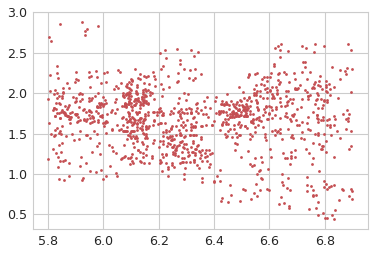

In [53]:
plt.plot(dist_com[:,0], dist_com[:,1], '.C2')

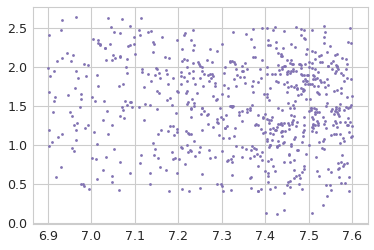

In [54]:
# Loading data for range [6.9, 7.6]
na3 = np.load('solvent_environments/fes_eqb_na69-76.npy')
ar3 = np.load('solvent_environments/fes_eqb_ar69-76.npy')
e_com3 = np.load('solvent_environments/fes_eqb_ecom69-76.npy')

dist_com = np.zeros([len(na3),2])
for i in range(len(na3)):
    dimer_com = (na3[i,0]+na3[i,1])/2

    dist_com[i,0] = lib.dist(na3[i,0], na3[i,1])
    dist_com[i,1] = np.min([lib.dist(ar3[i,j], dimer_com) for j in range(1600)])

plt.plot(dist_com[:,0], dist_com[:,1], '.C3')

distr_ar_com_3 = lib.binScalarsBondDist(dist_com[:,1], dist_com[:,0], 6.9, 7.6, 0.1)

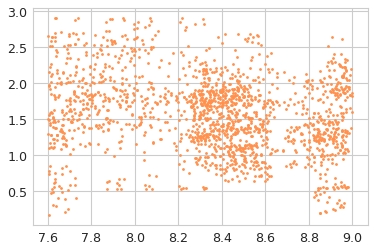

In [56]:
# Loading data for range [7.6, 9.0]
na4 = np.load('solvent_environments/fes_eqb_na76-90.npy')
ar4 = np.load('solvent_environments/fes_eqb_ar76-90.npy')
e_com4 = np.load('solvent_environments/fes_eqb_ecom76-90.npy')

dist_com = np.zeros([len(na4),2])
for i in range(len(na4)):
    dimer_com = (na4[i,0]+na4[i,1])/2

    dist_com[i,0] = lib.dist(na4[i,0], na4[i,1])
    dist_com[i,1] = np.min([lib.dist(ar4[i,j], dimer_com) for j in range(1600)])

plt.plot(dist_com[:,0], dist_com[:,1], '.C4')

distr_ar_com_4 = lib.binScalarsBondDist(dist_com[:,1], dist_com[:,0], 7.6, 9.0, 0.1)

Text(0.5,0,'bond dist')

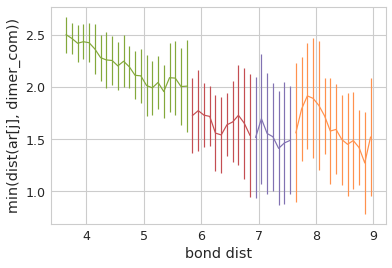

In [59]:
plt.errorbar(distr_ar_com_1[:,0], distr_ar_com_1[:,1], yerr=distr_ar_com_1[:,3], color='C1')
plt.errorbar(distr_ar_com_2[:,0], distr_ar_com_2[:,1], yerr=distr_ar_com_2[:,3], color='C2')
plt.errorbar(distr_ar_com_3[:,0], distr_ar_com_3[:,1], yerr=distr_ar_com_3[:,3], color='C3')
plt.errorbar(distr_ar_com_4[:,0], distr_ar_com_4[:,1], yerr=distr_ar_com_4[:,3], color='C4')
plt.ylabel('min(dist(ar[j], dimer_com))')
plt.xlabel('bond dist')

In [92]:
(r_cutoff, kappa) = (1.7, 0.2)

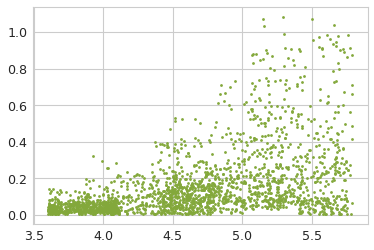

In [93]:
# Loading data for range [3.6, 5.8]
na1 = np.load('solvent_environments/fes_eqb_na36-58.npy')
ar1 = np.load('solvent_environments/fes_eqb_ar36-58.npy')
e_com1 = np.load('solvent_environments/fes_eqb_ecom36-58.npy')

Sr_com = np.zeros([len(na1),2])
for i in range(len(na1)):
    dimer_com = (na1[i,0]+na1[i,1])/2

    Sr_com[i,0] = lib.dist(na1[i,0], na1[i,1])
    ar_com = np.array([lib.dist(ar1[i,j], dimer_com) for j in range(1600)])
    Sr_com[i,1] = np.sum(1/(1+np.exp((ar_com-r_cutoff)/kappa)))

plt.plot(Sr_com[:,0], Sr_com[:,1], '.C1')

distr_Sr_com_1 = lib.binScalarsBondDist(Sr_com[:,1], Sr_com[:,0], 3.6, 5.8, 0.1)

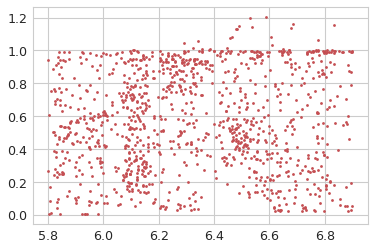

In [94]:
# Loading data for range [5.8, 6.9]
na2 = np.load('solvent_environments/fes_eqb_na58-69.npy')
ar2 = np.load('solvent_environments/fes_eqb_ar58-69.npy')
e_com2 = np.load('solvent_environments/fes_eqb_ecom58-69.npy')

Sr_com = np.zeros([len(na2),2])
for i in range(len(na2)):
    dimer_com = (na2[i,0]+na2[i,1])/2

    Sr_com[i,0] = lib.dist(na2[i,0], na2[i,1])
    ar_com = np.array([lib.dist(ar2[i,j], dimer_com) for j in range(1600)])
    Sr_com[i,1] = np.sum(1/(1+np.exp((ar_com-r_cutoff)/kappa)))

plt.plot(Sr_com[:,0], Sr_com[:,1], '.C2')

distr_Sr_com_2 = lib.binScalarsBondDist(Sr_com[:,1], Sr_com[:,0], 5.8, 6.9, 0.1)

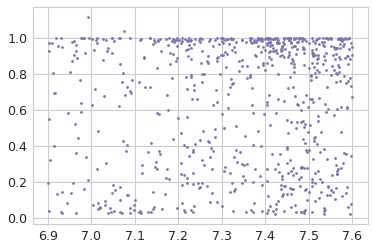

In [95]:
# Loading data for range [6.9, 7.6]
na3 = np.load('solvent_environments/fes_eqb_na69-76.npy')
ar3 = np.load('solvent_environments/fes_eqb_ar69-76.npy')
e_com3 = np.load('solvent_environments/fes_eqb_ecom69-76.npy')

Sr_com = np.zeros([len(na3),2])
for i in range(len(na3)):
    dimer_com = (na3[i,0]+na3[i,1])/2

    Sr_com[i,0] = lib.dist(na3[i,0], na3[i,1])
    ar_com = np.array([lib.dist(ar3[i,j], dimer_com) for j in range(1600)])
    Sr_com[i,1] = np.sum(1/(1+np.exp((ar_com-r_cutoff)/kappa)))

plt.plot(Sr_com[:,0], Sr_com[:,1], '.C3')

distr_Sr_com_3 = lib.binScalarsBondDist(Sr_com[:,1], Sr_com[:,0], 6.9, 7.6, 0.1)

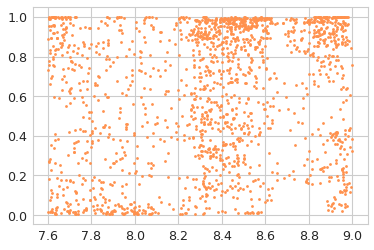

In [96]:
# Loading data for range [7.6, 9.0]
na4 = np.load('solvent_environments/fes_eqb_na76-90.npy')
ar4 = np.load('solvent_environments/fes_eqb_ar76-90.npy')
e_com4 = np.load('solvent_environments/fes_eqb_ecom76-90.npy')

Sr_com = np.zeros([len(na4),2])
for i in range(len(na4)):
    dimer_com = (na4[i,0]+na4[i,1])/2

    Sr_com[i,0] = lib.dist(na4[i,0], na4[i,1])
    ar_com = np.array([lib.dist(ar4[i,j], dimer_com) for j in range(1600)])
    Sr_com[i,1] = np.sum(1/(1+np.exp((ar_com-r_cutoff)/kappa)))

plt.plot(Sr_com[:,0], Sr_com[:,1], '.C4')

distr_Sr_com_4 = lib.binScalarsBondDist(Sr_com[:,1], Sr_com[:,0], 7.6, 9.0, 0.1)

Text(0.5,0,'bond dist')

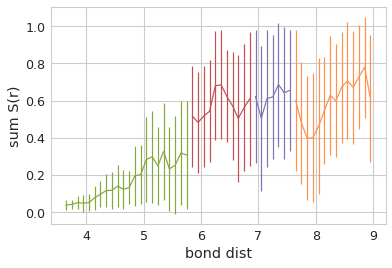

In [97]:
plt.errorbar(distr_Sr_com_1[:,0], distr_Sr_com_1[:,1], yerr=distr_Sr_com_1[:,3], color='C1')
plt.errorbar(distr_Sr_com_2[:,0], distr_Sr_com_2[:,1], yerr=distr_Sr_com_2[:,3], color='C2')
plt.errorbar(distr_Sr_com_3[:,0], distr_Sr_com_3[:,1], yerr=distr_Sr_com_3[:,3], color='C3')
plt.errorbar(distr_Sr_com_4[:,0], distr_Sr_com_4[:,1], yerr=distr_Sr_com_4[:,3], color='C4')
plt.ylabel('sum S(r)')
plt.xlabel('bond dist')

In [103]:
# counting number of Ar in the intramolecular region for ranges [3.6, 5.8], [5.8, 6.9], [6.9, 7.6], [7.6, 9.0]
r_cutoff = 2.1; kappa = 10

counts_intra1 = np.zeros(len(na1))
for i in range(len(na1)):
    closest_Ar = lib.closestAr(na1[i], ar1[i], n_cutoff=20, option='dimer') - na1[i,0,:]
    bond_ax = na1[i,1,:] - na1[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra1[i] = np.dot(radial_filter, axial_filter)

counts_intra2 = np.zeros(len(na2))
for i in range(len(na2)):
    closest_Ar = lib.closestAr(na2[i], ar2[i], n_cutoff=20, option='dimer') - na2[i,0,:]
    bond_ax = na2[i,1,:] - na2[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra2[i] = np.dot(radial_filter, axial_filter)
    
counts_intra3 = np.zeros(len(na3))
for i in range(len(na3)):
    closest_Ar = lib.closestAr(na3[i], ar3[i], n_cutoff=20, option='dimer') - na3[i,0,:]
    bond_ax = na3[i,1,:] - na3[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra3[i] = np.dot(radial_filter, axial_filter)
    
counts_intra4 = np.zeros(len(na4))
for i in range(len(na4)):
    closest_Ar = lib.closestAr(na4[i], ar4[i], n_cutoff=20, option='dimer') - na4[i,0,:]
    bond_ax = na4[i,1,:] - na4[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra4[i] = np.dot(radial_filter, axial_filter)

2166.0
1136.0
719.0
1689.0
0.17497691597414589 0.5532570422535211
0.6524687065368568 0.7386767317939609


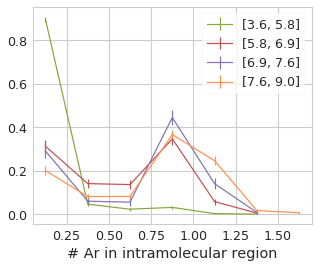

In [100]:
# integrate over cylinder r_cutoff = 1.7; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)
distr_intra4 = genDistr(counts_intra4, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.8]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.8, 6.9]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[6.9, 7.6]')
plt.errorbar(distr_intra4[:,0], distr_intra4[:,1], yerr=distr_intra4[:,2], color='C4', label='[7.6, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))
print(np.dot(distr_intra3[:,0], distr_intra3[:,1]), np.dot(distr_intra4[:,0], distr_intra4[:,1]))

2166.0
1136.0
719.0
1689.0
0.4564866112650046 1.1258802816901408
1.081884561891516 1.2326080521018354


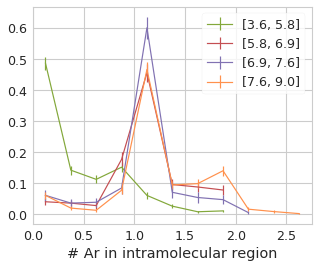

In [104]:
# integrate over cylinder r_cutoff = 2.1; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)
distr_intra4 = genDistr(counts_intra4, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.8]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.8, 6.9]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[6.9, 7.6]')
plt.errorbar(distr_intra4[:,0], distr_intra4[:,1], yerr=distr_intra4[:,2], color='C4', label='[7.6, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))
print(np.dot(distr_intra3[:,0], distr_intra3[:,1]), np.dot(distr_intra4[:,0], distr_intra4[:,1]))

2166.0
1136.0
719.0
1689.0
1.151315789473684 1.654269366197183
1.5293810848400557 1.8128330373001775


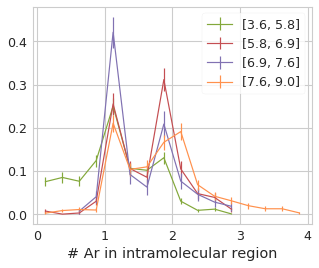

In [102]:
# integrate over cylinder r_cutoff = 2.45; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)
distr_intra4 = genDistr(counts_intra4, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.8]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.8, 6.9]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[6.9, 7.6]')
plt.errorbar(distr_intra4[:,0], distr_intra4[:,1], yerr=distr_intra4[:,2], color='C4', label='[7.6, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))
print(np.dot(distr_intra3[:,0], distr_intra3[:,1]), np.dot(distr_intra4[:,0], distr_intra4[:,1]))

2166.0
1136.0
719.0
1689.0
2.7233379501385038 2.803257042253521
2.9671418636995828 3.562981053878034


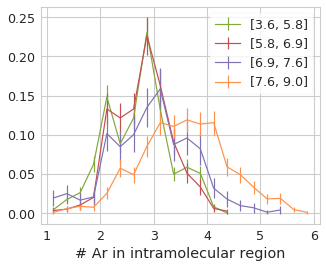

In [80]:
# integrate over cylinder r_cutoff = 3.0; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)
distr_intra3 = genDistr(counts_intra3, spacing=0.25)
distr_intra4 = genDistr(counts_intra4, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.8]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.8, 6.9]')
plt.errorbar(distr_intra3[:,0], distr_intra3[:,1], yerr=distr_intra3[:,2], color='C3', label='[6.9, 7.6]')
plt.errorbar(distr_intra4[:,0], distr_intra4[:,1], yerr=distr_intra4[:,2], color='C4', label='[7.6, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))
print(np.dot(distr_intra3[:,0], distr_intra3[:,1]), np.dot(distr_intra4[:,0], distr_intra4[:,1]))

(2, 10)

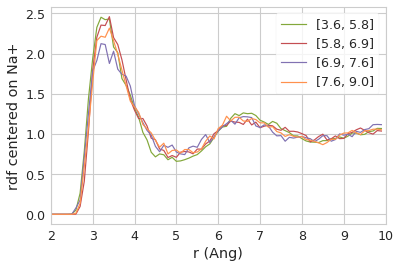

In [21]:
plt.plot(gr1[:,0], gr1[:,1], 'C1', label='[3.6, 5.8]')
plt.plot(gr2[:,0], gr2[:,1], 'C2', label='[5.8, 6.9]')
plt.plot(gr3[:,0], gr3[:,1], 'C3', label='[6.9, 7.6]')
plt.plot(gr4[:,0], gr4[:,1], 'C4', label='[7.6, 9.0]')
plt.ylabel('rdf centered on Na+')
plt.xlabel('r (Ang)')
plt.legend(loc=1)
plt.xlim([2,10])

(0, 5)

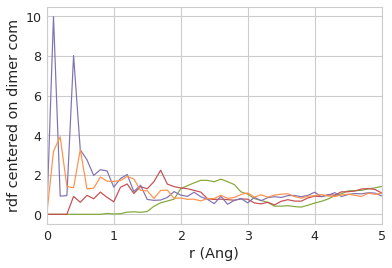

In [18]:
plt.plot(gr_dimer1[:,0], gr_dimer1[:,1], 'C1')
plt.plot(gr_dimer2[:,0], gr_dimer2[:,1], 'C2')
plt.plot(gr_dimer3[:,0], gr_dimer3[:,1], 'C3')
plt.plot(gr_dimer4[:,0], gr_dimer4[:,1], 'C4')
plt.ylabel('rdf centered on dimer com')
plt.xlabel('r (Ang)')
plt.xlim([0,5])

In [4]:
def rotDimerEnv(r_Na, r_Ar, e_com):
    '''
    Rotates coordinates such that dimer bond axis is along x-axis with Na1 pointing toward +x-axis.
    Assigns Na1 as one with electron
    '''
    swap = lib.dist(r_Na[1], e_com) < lib.dist(r_Na[0], e_com)
#     swap = False
    swap_m = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])

    # recenters sodiums and argon s.t. dimer center of mass at origin
    r_solu = r_Na - (r_Na[0]+r_Na[1])/2
    r_solv = r_Ar - (r_Na[0]+r_Na[1])/2
    r_com = e_com - (r_Na[0]+r_Na[1])/2

    # project solu and solvent onto unit sphere to make rotations easier
    radial_solu = np.array([[set_fxns.norm(r_solu[i])] for i in range(len(r_solu))])
    radial_solv = np.array([[set_fxns.norm(r_solv[i])] for i in range(len(r_solv))])

    r_solu /= radial_solu
    r_solv /= radial_solv 

    # rotate atoms s.t. dimer is along x-axis with Na1 on +x-axis
    if set_fxns.norm(np.cross(r_solu[0], [1,0,0])) > 1e-6:
        rot_ax = np.cross(r_solu[0], [1,0,0])/set_fxns.norm(np.cross(r_solu[0], [1,0,0]))
        rot_ang = 2*np.arcsin(0.5*lib.dist(r_solu[0], [1,0,0]))
        cross_mat = np.array([[0,-rot_ax[2],rot_ax[1]],[rot_ax[2],0,-rot_ax[0]],[-rot_ax[1],rot_ax[0],0]])

        rot_m = np.cos(rot_ang)*np.identity(3) + \
            np.sin(rot_ang)*cross_mat + (1-np.cos(rot_ang))*np.outer(rot_ax,rot_ax)
        if swap:
            for i in range(len(r_solu)):
                r_solu[i] = np.matmul(np.matmul(rot_m,r_solu[i]), swap_m)*radial_solu[i,0]
            for i in range(len(r_solv)):
                r_solv[i] = np.matmul(np.matmul(rot_m,r_solv[i]), swap_m)*radial_solv[i,0]
            r_com = np.matmul(rot_m, r_com)
        else:
            for i in range(len(r_solu)):
                r_solu[i] = np.matmul(rot_m,r_solu[i])*radial_solu[i,0]
            for i in range(len(r_solv)):
                r_solv[i] = np.matmul(rot_m,r_solv[i])*radial_solv[i,0]
            r_com = np.matmul(rot_m, r_com)

    return r_solu, r_solv

In [5]:
def gaussShell(r_Na, r_Ar, r_sep, radius, sigma=1.7, kappa=0.2, n_cutoff=20, Ar_metric='cation', N=2000, project='hard_all'):
    if r_sep > 2*radius:
        shell_pts = np.append(set_fxns.fibonacciSphere(N, r=radius) + np.array([r_sep/2,0,0]), 
                              set_fxns.fibonacciSphere(N, r=radius) - np.array([r_sep/2,0,0]), axis=0)
        shell_pts = np.append(shell_pts, [[0]]*(2*N), axis=1)
    else:
        shell_pts_na1 = set_fxns.fibonacciSphere(N, r=radius) + np.array([r_sep/2,0,0])
        shell_pts_na2 = set_fxns.fibonacciSphere(N, r=radius) - np.array([r_sep/2,0,0])
        del_list1 = []; del_list2 = []
        for i in range(N):
            if lib.dist(shell_pts_na1[i], np.array([-r_sep/2,0,0])) < radius:
                del_list1 += [i]
            if lib.dist(shell_pts_na2[i], np.array([r_sep/2,0,0])) < radius:
                del_list2 += [i]
        shell_pts_na1 = np.delete(shell_pts_na1, del_list1, axis=0)
        shell_pts_na2 = np.delete(shell_pts_na2, del_list2, axis=0)
        
        shell_pts = np.append(shell_pts_na1, shell_pts_na2, axis=0)
        shell_pts = np.append(shell_pts, [[0]]*len(shell_pts), axis=1)

    closest_ar = lib.closestAr(r_Na, r_Ar, n_cutoff=n_cutoff, option=Ar_metric)

    if project.lower() == 'hard':
        for n in range(len(shell_pts)):
            my_dist = np.array([lib.dist(shell_pts[n], closest_ar[m])/sigma for m in range(len(closest_ar))])
            if min(my_dist) < 1:
                shell_pts[n,3] = 1 
    if project.lower() == 'smooth':
        for n in range(len(shell_pts)):
            my_dist = np.array([lib.dist(shell_pts[n], closest_ar[m])/sigma for m in range(len(closest_ar))])
            shell_pts[n,3] = 1/(1+np.exp((min(my_dist)-1.1)/kappa))
    if project.lower() == 'hard_all':
        for n in range(len(shell_pts)):
            my_dist = np.array([lib.dist(shell_pts[n], closest_ar[m])/sigma for m in range(len(closest_ar))])
            shell_pts[n,3] = -np.sum(np.sign(my_dist-1)-1)/2
    if project.lower() == 'smooth_all':
        for n in range(len(shell_pts)):
            my_dist = np.array([lib.dist(shell_pts[n], closest_ar[m])/sigma for m in range(len(closest_ar))])
            shell_pts[n,3] = np.sum(1/(1+np.exp((my_dist-1.1)/kappa)))

    return shell_pts

In [6]:
def colorShell(shell_pts):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     p = ax.scatter(shell_pts[:,0],shell_pts[:,1],shell_pts[:,2],s=1.5,c=shell_pts[:,3],marker='o',vmin=0,vmax=1,cmap='bwr')
    p = ax.scatter(shell_pts[:,0],shell_pts[:,1],shell_pts[:,2],s=1.5,c=shell_pts[:,3],marker='o',vmin=np.min(shell_pts[:,3]),vmax=np.max(shell_pts[:,3]),cmap='bwr')
#     p = ax.plot_surface(shell_pts[:,0], shell_pts[:,1], shell_pts[:,2], c=shell_pts[:,3], cmap='bwr')
    fig.colorbar(p)

    X = shell_pts[:,0]; Y = shell_pts[:,1]; Z = shell_pts[:,2]

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    return None

In [12]:
# 3D projection of ar positions [3.6, 5.8]
my_na, my_ar = rotDimerEnv(na1[0], ar1[0], e_com1[0])
pts1 = gaussShell(my_na, my_ar, 6.3, 3.3, project='smooth')
for i in range(1, len(na1)):
    my_na, my_ar = rotDimerEnv(na1[i], ar1[i], e_com1[i])
    pts1[:,3] += gaussShell(my_na, my_ar, 6.3, 3.3, project='smooth')[:,3]
pts1[:,3] /= len(na1)

In [13]:
# 3D projection of ar positions [5.8, 6.9]
my_na, my_ar = rotDimerEnv(na2[0], ar2[0], e_com2[0])
pts2 = gaussShell(my_na, my_ar, 6.3, 3.3, project='smooth')
for i in range(1, len(na2)):
    my_na, my_ar = rotDimerEnv(na2[i], ar2[i], e_com2[i])
    pts2[:,3] += gaussShell(my_na, my_ar, 6.3, 3.3, project='smooth')[:,3]
pts2[:,3] /= len(na2)

In [14]:
# 3D projection of ar positions [6.9, 7.6]
my_na, my_ar = rotDimerEnv(na3[0], ar3[0], e_com3[0])
pts3 = gaussShell(my_na, my_ar, 7.2, 3.3, project='smooth')
for i in range(1, len(na3)):
    my_na, my_ar = rotDimerEnv(na3[i], ar3[i], e_com3[i])
    pts3[:,3] += gaussShell(my_na, my_ar, 7.2, 3.3, project='smooth')[:,3]
pts3[:,3] /= len(na3)

In [15]:
# 3D projection of ar positions [7.6, 9.0]
my_na, my_ar = rotDimerEnv(na4[0], ar4[0], e_com4[0])
pts4 = gaussShell(my_na, my_ar, 7.2, 3.3, project='smooth')
for i in range(1, len(na4)):
    my_na, my_ar = rotDimerEnv(na4[i], ar4[i], e_com4[i])
    pts4[:,3] += gaussShell(my_na, my_ar, 7.2, 3.3, project='smooth')[:,3]
pts4[:,3] /= len(na4)

In [41]:
dist_na1_ecom4 = np.array([lib.dist(na4[i,0], e_com4[i]) for i in range(len(na4))])
dist_na2_ecom4 = np.array([lib.dist(na4[i,1], e_com4[i]) for i in range(len(na4))])

In [91]:
dist_na1 = np.zeros(len(na4))
dist_na2 = np.zeros(len(na4))
for i in range(len(na4)):
    my_na, my_ar, my_com = rotDimerEnv(na4[i], ar4[i], e_com4[i])
    dist_na1[i] = lib.dist(my_na[0], my_com)
    dist_na2[i] = lib.dist(my_na[1], my_com)

(0, 500)

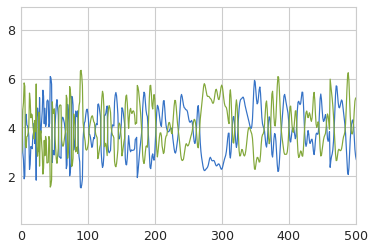

In [49]:
%matplotlib inline
plt.plot(np.arange(len(na4)), dist_na1_ecom4)
plt.plot(np.arange(len(na4)), dist_na2_ecom4)
plt.xlim([0,500])

(0, 500)

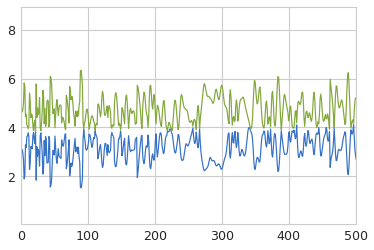

In [92]:
%matplotlib inline
plt.plot(np.arange(len(na4)), dist_na1)
plt.plot(np.arange(len(na4)), dist_na2)
plt.xlim([0, 500])

In [ ]:
my_pts3 = gaussShell(na3[0], ar3[0], 7.2, 3.3, project='smooth', kappa=0.2)

In [49]:
pts1 = np.load('solvent_environments/fes_eqb_shellpts_36-58.npy')
pts2 = np.load('solvent_environments/fes_eqb_shellpts_58-69.npy')
pts3 = np.load('solvent_environments/fes_eqb_shellpts_69-76.npy')
pts4 = np.load('solvent_environments/fes_eqb_shellpts_76-90.npy')

<IPython.core.display.Javascript object>


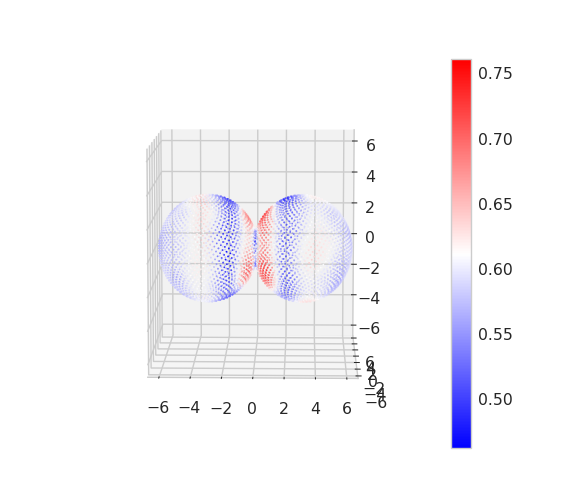

In [135]:
%matplotlib notebook
colorShell(pts1)

In [19]:
for i in range(len(pts2)):
    if pts2[i,3] < 0.52 or pts2[i,3] > 0.56:
        pts2[i,3] = 0
# pts2[:,3] = np.round(pts2[:,3] - 0.15)

<IPython.core.display.Javascript object>


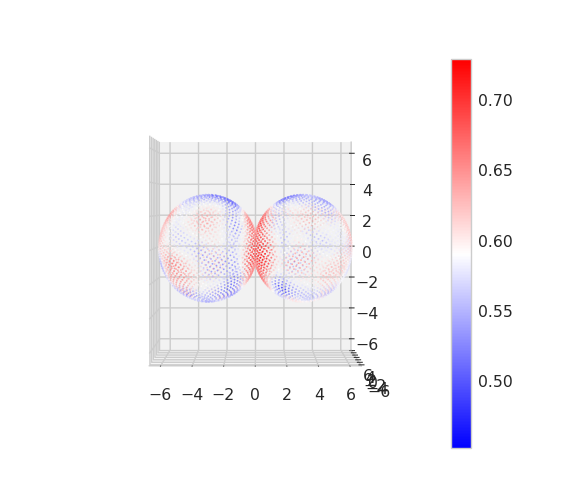

In [52]:
%matplotlib notebook
colorShell(pts2)

In [17]:
for i in range(len(pts3)):
    if pts3[i,3] < 0.52 or pts3[i,3] > 0.56:
        pts3[i,3] = 0
# pts3[:,3] = np.round(pts3[:,3] - 0.15)

<IPython.core.display.Javascript object>


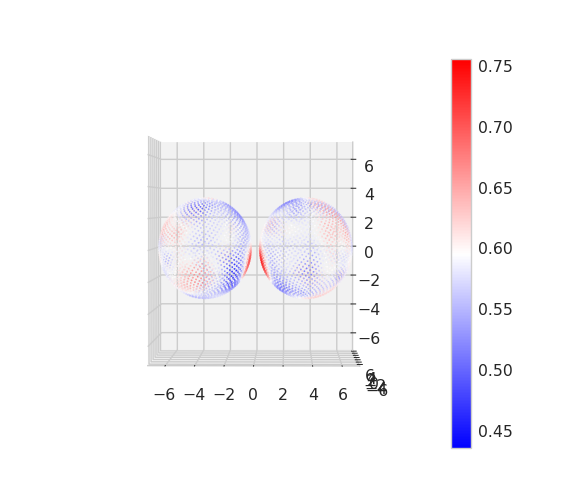

In [51]:
%matplotlib notebook
colorShell(pts3)

<IPython.core.display.Javascript object>


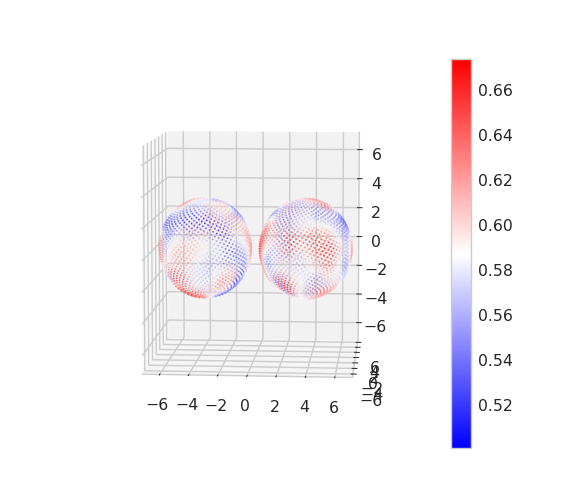

In [19]:
%matplotlib notebook
colorShell(pts4)

In [20]:
np.save('solvent_environments/fes_eqb_shellpts_36-58.npy', pts1)

In [21]:
np.save('solvent_environments/fes_eqb_shellpts_58-69.npy', pts2)

In [22]:
np.save('solvent_environments/fes_eqb_shellpts_69-76.npy', pts3)

In [23]:
np.save('solvent_environments/fes_eqb_shellpts_76-90.npy', pts4)

In [25]:
print(np.average(pts2[:,3]), np.average(pts3[:,3]))
print(np.std(pts2[:,3]), np.std(pts3[:,3]))

0.5957381375230834 0.5821316567949651
0.04508419221862233 0.04200846059123462


In [12]:
print(len(pts1), len(pts2), len(pts3), len(pts4))

3909 3909 4000 4000


In [13]:
pts_distr1_na1 = genDistr(pts1[:1954,3], spacing=0.02)
pts_distr1_na2 = genDistr(pts1[1954:,3], spacing=0.02)
pts_distr2_na1 = genDistr(pts2[:1954,3], spacing=0.02)
pts_distr2_na2 = genDistr(pts2[1954:,3], spacing=0.02)
pts_distr3_na1 = genDistr(pts3[:2000,3], spacing=0.02)
pts_distr3_na2 = genDistr(pts3[2000:,3], spacing=0.02)
pts_distr4_na1 = genDistr(pts4[:2000,3], spacing=0.02)
pts_distr4_na2 = genDistr(pts4[2000:,3], spacing=0.02)

1954.0
1955.0
1954.0
1955.0
2000.0
2000.0
2000.0
2000.0


In [14]:
pts_distr1 = genDistr(pts1[:,3], spacing=0.02)
pts_distr2 = genDistr(pts2[:,3], spacing=0.02)
pts_distr3 = genDistr(pts3[:,3], spacing=0.02)
pts_distr4 = genDistr(pts4[:,3], spacing=0.02)

3909.0
3909.0
4000.0
4000.0


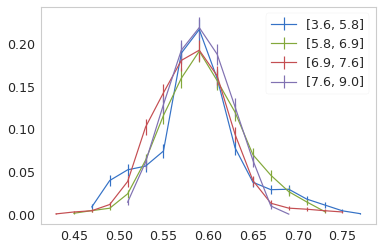

In [23]:
%matplotlib inline
plt.errorbar(pts_distr1[:,0], pts_distr1[:,1], yerr=pts_distr1[:,2], color='C0', label='[3.6, 5.8]')
plt.errorbar(pts_distr2[:,0], pts_distr2[:,1], yerr=pts_distr2[:,2], color='C1', label='[5.8, 6.9]')
plt.errorbar(pts_distr3[:,0], pts_distr3[:,1], yerr=pts_distr3[:,2], color='C2', label='[6.9, 7.6]')
plt.errorbar(pts_distr4[:,0], pts_distr4[:,1], yerr=pts_distr4[:,2], color='C3', label='[7.6, 9.0]')
plt.legend(loc=1)
plt.grid(False)

In [16]:
pts_distr2[:,0]

array([0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73])

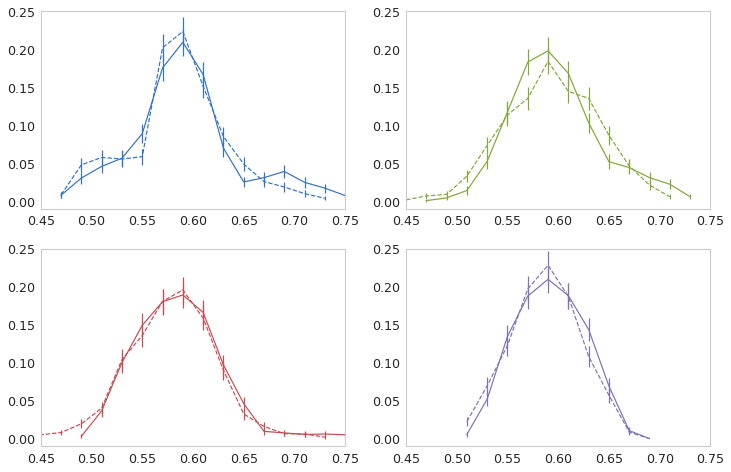

In [38]:
# distribution of overlap around each Na+
%matplotlib inline
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.errorbar(pts_distr1_na1[:,0], pts_distr1_na1[:,1], yerr=pts_distr1_na1[:,2], color='C0')
plt.errorbar(pts_distr1_na2[:,0], pts_distr1_na2[:,1], yerr=pts_distr1_na2[:,2], color='C0', linestyle='--')
plt.ylim([-0.01,0.25])
plt.xlim([0.45, 0.75])
plt.grid(False)
plt.subplot(2,2,2)
plt.errorbar(pts_distr2_na1[:,0], pts_distr2_na1[:,1], yerr=pts_distr2_na1[:,2], color='C1')
plt.errorbar(pts_distr2_na2[:,0], pts_distr2_na2[:,1], yerr=pts_distr2_na2[:,2], color='C1', linestyle='--')
plt.ylim([-0.01,0.25])
plt.xlim([0.45, 0.75])
plt.grid(False)
plt.subplot(2,2,3)
plt.errorbar(pts_distr3_na1[:,0], pts_distr3_na1[:,1], yerr=pts_distr3_na1[:,2], color='C2')
plt.errorbar(pts_distr3_na2[:,0], pts_distr3_na2[:,1], yerr=pts_distr3_na2[:,2], color='C2', linestyle='--')
plt.ylim([-0.01,0.25])
plt.xlim([0.45, 0.75])
plt.grid(False)
plt.subplot(2,2,4)
plt.errorbar(pts_distr4_na1[:,0], pts_distr4_na1[:,1], yerr=pts_distr4_na1[:,2], color='C3')
plt.errorbar(pts_distr4_na2[:,0], pts_distr4_na2[:,1], yerr=pts_distr4_na2[:,2], color='C3', linestyle='--')
plt.ylim([-0.01,0.25])
plt.xlim([0.45, 0.75])
plt.grid(False)

In [4]:
# gnd/fes umbrella sampling
r0 = 6.9; r = 7.6; dr = 0.1

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
# dirs = ['3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1']
# dirs = ['5.4', '5.6', '5.8', '6.0', '6.1', '6.2', '6.4', '6.6', '6.8', '7.0', '7.2']
dirs = ['6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5', '7.6', '7.8']
# dirs = ['7.0', '7.2', '7.3', '7.4', '7.5', '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
rho1 = []
rho2 = []
for i in range(len(dirs)):
    my_dir = root+dirs[i]+'/'
    
    t0 = lib.convFloat(linecache.getline(my_dir+'out.na', 2).split()[4])
    t1 = lib.convFloat(linecache.getline(my_dir+'out.na', 17).split()[4])
    dt = t1-t0
    f = open(my_dir+'/out.na')
    t = len(f.readlines())/15*dt
    f.close()
    t_frames = np.arange(2000, t, dt)
    
    my_bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[500:]
    del_t = my_bond_dist[1,0] - my_bond_dist[0,0]
    tau = int(dt/del_t)
    for j in range(len(t_frames)-1):
        if my_bond_dist[j*tau,1] >= r0 and my_bond_dist[j*tau,1] < r:
            rho1 += [lib.readEDens(my_dir+'/rho_st1.cube', t_frames[j])[0]]
            rho2 += [lib.readEDens(my_dir+'/rho_st2.cube', t_frames[j])[0]]
rho1 = np.array(rho1, dtype='float32')
rho2 = np.array(rho2, dtype='float32')

# saving to be loaded at a later time
np.save('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_rho1_69-76.npy', rho1)
np.save('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_rho2_69-76.npy', rho2)

### Onto non-eqb stuff

In [ ]:
# Need to generate na_fc, ar_fc, etc. for the non-eqb data
r0 = 3.6; r = 6.0

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/'
dirs = np.arange(1,106)

na_fc = []; ar_fc = []; e_com_fc = []
for i in range(len(dirs)):
    my_dir = root+str(dirs[i])+'/1/'
    
    my_bond_dist = increasingBondDist(my_dir)
    my_e_com = lib.readEcom(my_dir)
    for j in range(len(my_bond_dist)):
        if my_bond_dist[j,1] > r0 and my_bond_dist[j,1] < r:
            na_fc += [lib.readNa(my_dir+'/out.na', my_bond_dist[j,0])]
            ar_fc += [lib.readAr(my_dir+'/out.water', my_bond_dist[j,0])]
            e_com_fc += [my_e_com[j,1:]]
na_fc = np.array(na_fc, dtype='float32'); ar_fc = np.array(ar_fc, dtype='float32'); e_com_fc = np.array(e_com_fc, dtype='float32')

# saving to be loaded at a later time
np.save('solvent_environments/non_eqb_na_fc1.npy', na_fc)
np.save('solvent_environments/non_eqb_ar_fc1.npy', ar_fc)
np.save('solvent_environments/non_eqb_ecom_fc1.npy', e_com_fc)

In [4]:
# load the Na, Ar, e_com data for FC ([3.6, 6.0]) region
na_fc = np.load('solvent_environments/non_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/non_eqb_ar_fc.npy')
v_ar_fc = np.load('solvent_environments/non_eqb_v_ar_fc.npy')
e_com_fc = np.load('solvent_environments/non_eqb_ecom_fc.npy')

12.775950583058332 0.01818317195912959


Text(0.5,0,'num of neighbors')

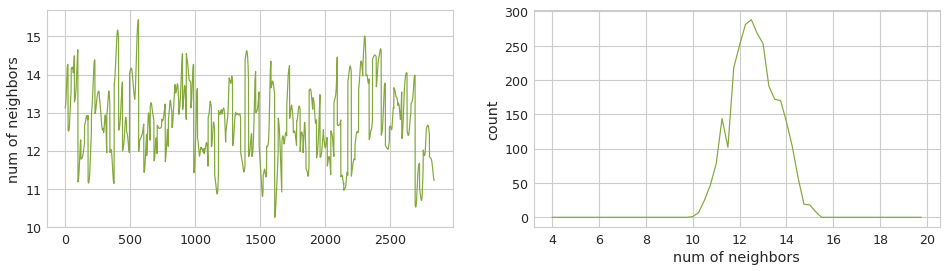

In [13]:
# Num of Neighbors, fc [3.6, 6.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='cation', index='false')
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,0], closest_Ar)-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,1], closest_Ar)-r_cutoff)/kappa))

    neighbors_fc[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_fc), stats.sem(neighbors_fc))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_fc = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_fc)):
    my_ind = int((neighbors_fc[i]-n0)/dn)
    neighbor_counts_fc[my_ind,1] += 1
neighbor_counts_fc[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_fc, 'C1')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_fc[:,0], neighbor_counts_fc[:,1], 'C1')
plt.ylabel('count')
plt.xlabel('num of neighbors')

172.54595832248162 1.8335577895835937
2840.0


Text(0.5,0,'Temp of neighbors')

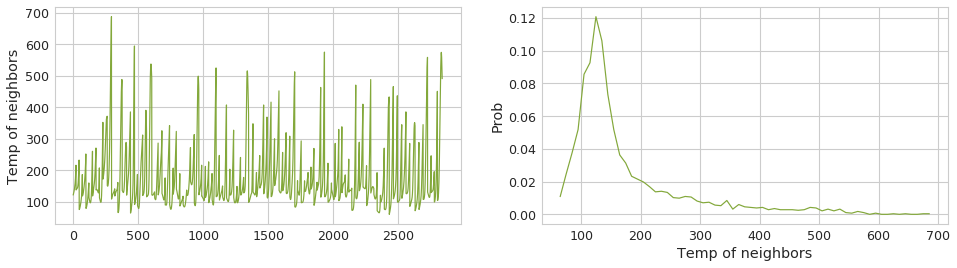

In [18]:
# Temp of Neighbors, fc [3.6, 6.0]
r_cutoff = 4.25; kappa = 0.2
T_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar, ar_index = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='cation', index='true')
    v_closest = v_ar_fc[i, ar_index,:]
    
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,0], closest_Ar)-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_fc[i,1], closest_Ar)-r_cutoff)/kappa))
    dist_filter = np.maximum(S_r_na1, S_r_na2)
    
    v2_closest = (v_closest[:,0]**2 + v_closest[:,1]**2 + v_closest[:,2]**2)

    # 16.015466 = 39.948 / 6.0221409e+23 / 1000 / 3 / 1.380649e-23 * 10000
    # 5.024e-16 / (1.3806505e-23*(3*nmol + 3)) / 480.3377512888936 * 16
    T_fc[i] = np.sum(dist_filter * v2_closest)*39.948 * 5.024e-16 / ((3*np.sum(dist_filter)+3)*1.38065e-23) / 480.3377512888936 * 16

print(np.average(T_fc), stats.sem(T_fc))

T_distr_fc = genDistr(T_fc, spacing=10)

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(T_fc, 'C1')
plt.ylabel('Temp of neighbors')
plt.subplot(1,2,2)
plt.plot(T_distr_fc[:,0], T_distr_fc[:,1], 'C1')
plt.ylabel('Prob')
plt.xlabel('Temp of neighbors')

In [6]:
# radial distr fxn using radial distance and averaging over both Na's, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_fc = np.zeros([len(bins_radial_na),2])

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_fc[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_fc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_fc[j,1] /= (V2-V1)*2*rho
gr_fc[:,1] /= len(na_fc)
gr_fc[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, fc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_fc = np.zeros([len(bins_radial_com),2])

for i in range(len(na_fc)):
    r_na_ar = ar_fc[i] - np.repeat([(na_fc[i,0]+na_fc[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_fc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_fc)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_fc[j,1] /= (V2-V1)*rho
gr_dimer_fc[:,1] /= len(na_fc)
gr_dimer_fc[:,0] = bins_radial_com

# radial distr fxn using elliptical (dimer) distance, fc
r0 = 4; r = 20; dr = 0.1
bins_elliptical = np.arange(r0,r,dr)
counts_elliptical = np.zeros(len(bins_elliptical))

for i in range(len(na_fc)):
    r_na1_ar = ar_fc[i] - np.repeat([na_fc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_fc[i] - np.repeat([na_fc[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical)):
    V1 = 4*np.pi/27 * bins_elliptical[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical[j]+dr)**3
    counts_elliptical[j] /= (V2-V1)*rho
counts_elliptical /= len(na_fc)

Text(0.5,1,'g(r) radial dist from dimer com')

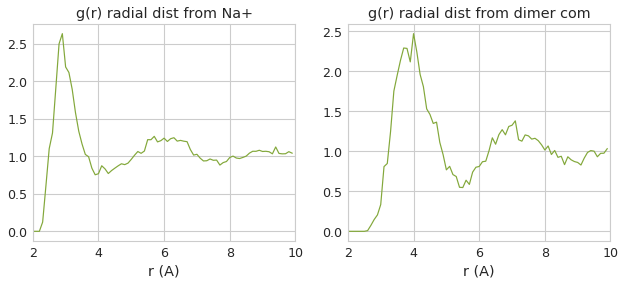

In [8]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_fc[:,0], gr_fc[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_fc[:,0], gr_dimer_fc[:,1], 'C1')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
# plt.subplot(1,3,3)
# plt.plot(gr_min_fc[:,0], gr_min_fc[:,1], 'C1')
# plt.xlim([2,10])
# plt.xlabel('r (A)')
# plt.title('g(r) for Na1 closest to neighboring Ar')

In [20]:
T_distr_fc[:,0] # max at 125 K

array([ 65.,  75.,  85.,  95., 105., 115., 125., 135., 145., 155., 165.,
       175., 185., 195., 205., 215., 225., 235., 245., 255., 265., 275.,
       285., 295., 305., 315., 325., 335., 345., 355., 365., 375., 385.,
       395., 405., 415., 425., 435., 445., 455., 465., 475., 485., 495.,
       505., 515., 525., 535., 545., 555., 565., 575., 585., 595., 605.,
       615., 625., 635., 645., 655., 665., 675., 685.])

In [21]:
T_distr_fc[:,1]

array([0.01091549, 0.02464789, 0.03767606, 0.05176056, 0.08556338,
       0.09260563, 0.12077465, 0.10598592, 0.07323944, 0.05176056,
       0.03626761, 0.03133803, 0.02323944, 0.02147887, 0.01971831,
       0.01690141, 0.01373239, 0.01408451, 0.01338028, 0.01021127,
       0.00985915, 0.01091549, 0.01056338, 0.00809859, 0.00704225,
       0.00739437, 0.0056338 , 0.00528169, 0.0084507 , 0.00316901,
       0.00598592, 0.00457746, 0.00422535, 0.00387324, 0.00422535,
       0.0028169 , 0.00352113, 0.0028169 , 0.0028169 , 0.0028169 ,
       0.00246479, 0.0028169 , 0.00422535, 0.00387324, 0.00211268,
       0.00316901, 0.00211268, 0.00316901, 0.00105634, 0.00070423,
       0.00176056, 0.00105634, 0.        , 0.00070423, 0.        ,
       0.        , 0.00035211, 0.        , 0.00035211, 0.        ,
       0.        , 0.00035211, 0.00035211])

In [22]:
max(T_distr_fc[:,1])

0.12077464788732395

In [5]:
# load the Na, Ar, e_com data for cage ([6.0, 7.0]) region
na_cage = np.load('solvent_environments/non_eqb_na_cage.npy')
ar_cage = np.load('solvent_environments/non_eqb_ar_cage.npy')
v_ar_cage = np.load('solvent_environments/non_eqb_v_ar_cage.npy')
e_com_cage = np.load('solvent_environments/non_eqb_ecom_cage.npy')

12.667509637760096 0.02557320998659513


Text(0.5,0,'num of neighbors')

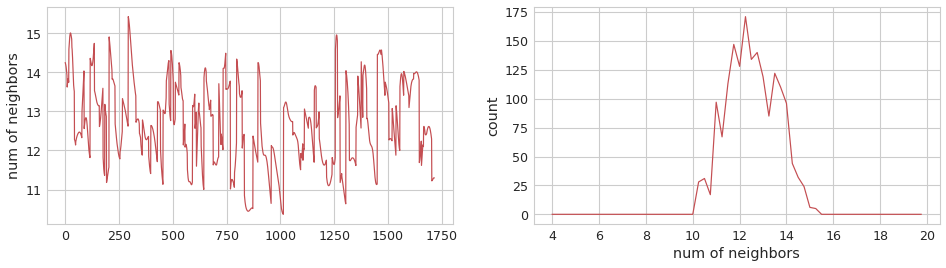

In [22]:
# Num of Neighbors, cage [6.0, 7.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='cation', index='false')
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,0], closest_Ar)-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,1], closest_Ar)-r_cutoff)/kappa))

    neighbors_cage[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_cage), stats.sem(neighbors_cage))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_cage = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_cage)):
    my_ind = int((neighbors_cage[i]-n0)/dn)
    neighbor_counts_cage[my_ind,1] += 1
neighbor_counts_cage[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_cage, 'C2')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_cage[:,0], neighbor_counts_cage[:,1], 'C2')
plt.ylabel('count')
plt.xlabel('num of neighbors')

395.5119074330617 3.1787626165585237
1716.0


Text(0.5,0,'Temp of neighbors')

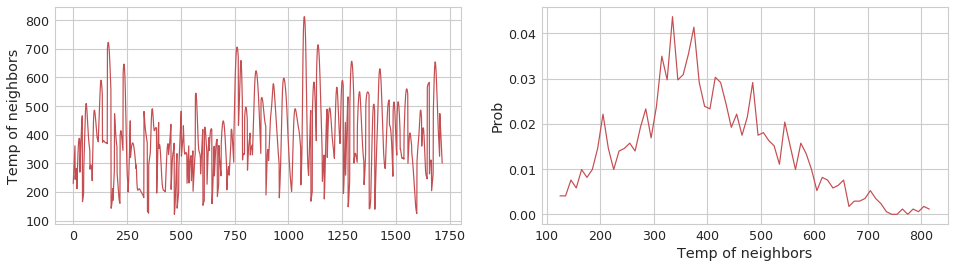

In [23]:
# Temp of Neighbors, cage [6.0, 7.0]
r_cutoff = 4.25; kappa = 0.2
T_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar, ar_index = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='cation', index='true')
    v_closest = v_ar_cage[i, ar_index,:]
    
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,0], closest_Ar)-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_cage[i,1], closest_Ar)-r_cutoff)/kappa))
    dist_filter = np.maximum(S_r_na1, S_r_na2)
    
    v2_closest = (v_closest[:,0]**2 + v_closest[:,1]**2 + v_closest[:,2]**2)

    # 16.015466 = 39.948 / 6.0221409e+23 / 1000 / 3 / 1.380649e-23 * 10000
    # 5.024e-16 / (1.3806505e-23*(3*nmol + 3)) / 480.3377512888936 * 16
    T_cage[i] = np.sum(dist_filter * v2_closest)*39.948 * 5.024e-16 / ((3*np.sum(dist_filter)+3)*1.38065e-23) / 480.3377512888936 * 16

print(np.average(T_cage), stats.sem(T_cage))

T_distr_cage = genDistr(T_cage, spacing=10)

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(T_cage, 'C2')
plt.ylabel('Temp of neighbors')
plt.subplot(1,2,2)
plt.plot(T_distr_cage[:,0], T_distr_cage[:,1], 'C2')
plt.ylabel('Prob')
plt.xlabel('Temp of neighbors')

In [24]:
# radial distr fxn using radial distance and averaging over both Na's, cage
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_cage = np.zeros([len(bins_radial_na),2])

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_cage[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_cage)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_cage[j,1] /= (V2-V1)*2*rho
gr_cage[:,1] /= len(na_cage)
gr_cage[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, cage
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_cage = np.zeros([len(bins_radial_com),2])

for i in range(len(na_cage)):
    r_na_ar = ar_cage[i] - np.repeat([(na_cage[i,0]+na_cage[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_cage[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_cage)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_cage[j,1] /= (V2-V1)*rho
gr_dimer_cage[:,1] /= len(na_cage)
gr_dimer_cage[:,0] = bins_radial_com

# radial distr fxn using elliptical (dimer) distance, cage
r0 = 4; r = 20; dr = 0.1
bins_elliptical = np.arange(r0,r,dr)
counts_elliptical = np.zeros(len(bins_elliptical))

for i in range(len(na_cage)):
    r_na1_ar = ar_cage[i] - np.repeat([na_cage[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_cage[i] - np.repeat([na_cage[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical)):
    V1 = 4*np.pi/27 * bins_elliptical[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical[j]+dr)**3
    counts_elliptical[j] /= (V2-V1)*rho
counts_elliptical /= len(na_cage)

Text(0.5,1,'g(r) radial dist from dimer com')

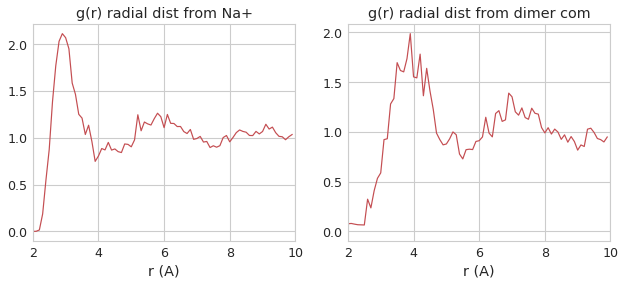

In [25]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_cage[:,0], gr_dimer_cage[:,1], 'C2')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
# plt.subplot(1,3,3)
# plt.plot(gr_min_cage[:,0], gr_min_cage[:,1])
# plt.xlim([2,10])
# plt.xlabel('r (A)')
# plt.title('g(r) for Na1 closest to neighboring Ar')

In [33]:
# load the Na, Ar, e_com data for loc ([7.0, 9.0]) region
na_loc = np.load('solvent_environments/non_eqb_na_loc.npy')
ar_loc = np.load('solvent_environments/non_eqb_ar_loc.npy')
v_ar_loc = np.load('solvent_environments/non_eqb_v_ar_loc.npy')
e_com_loc = np.load('solvent_environments/non_eqb_ecom_loc.npy')

12.222550227255343 0.01698383054101301


Text(0.5,0,'num of neighbors')

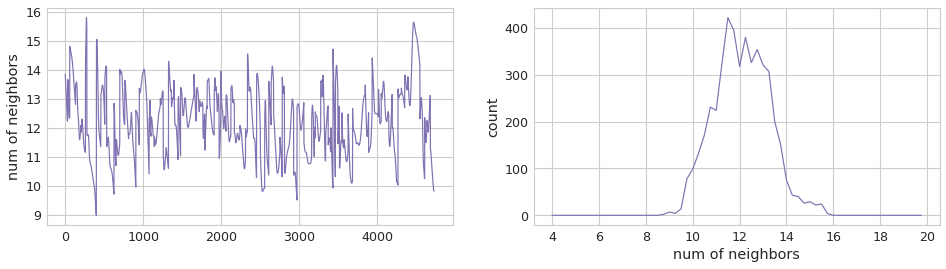

In [27]:
# Num of Neighbors, loc [7.0, 9.0]
r_cutoff = 4.25; kappa = 0.2
neighbors_loc = np.zeros(len(na_loc))
for i in range(len(na_loc)):
    closest_Ar = lib.closestAr(na_loc[i], ar_loc[i], n_cutoff=20, option='cation', index='false')
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_loc[i,0], closest_Ar)-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_loc[i,1], closest_Ar)-r_cutoff)/kappa))

    neighbors_loc[i] = np.sum(np.maximum(S_r_na1, S_r_na2))

print(np.average(neighbors_loc), stats.sem(neighbors_loc))

n0 = 4; n = 20; dn = 0.25
dimer_dist = np.arange(n0,n,dn)
neighbor_counts_loc = np.zeros([len(dimer_dist),2])
for i in range(len(neighbors_loc)):
    my_ind = int((neighbors_loc[i]-n0)/dn)
    neighbor_counts_loc[my_ind,1] += 1
neighbor_counts_loc[:,0] = dimer_dist

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(neighbors_loc, 'C3')
plt.ylabel('num of neighbors')
plt.subplot(1,2,2)
plt.plot(neighbor_counts_loc[:,0], neighbor_counts_loc[:,1], 'C3')
plt.ylabel('count')
plt.xlabel('num of neighbors')

263.4315736116017 1.7298778960347179
4727.0


Text(0.5,0,'Temp of neighbors')

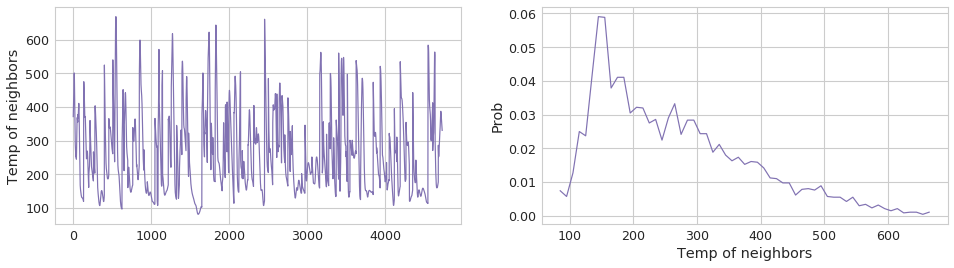

In [30]:
# Temp of Neighbors, loc [7.0, 9.0]
r_cutoff = 4.25; kappa = 0.2
T_loc = np.zeros(len(na_loc))
for i in range(len(na_loc)):
    closest_Ar, ar_index = lib.closestAr(na_loc[i], ar_loc[i], n_cutoff=20, option='cation', index='true')
    v_closest = v_ar_loc[i, ar_index,:]
    
    S_r_na1 = 1/(1+np.exp((lib.calcNaArDist(na_loc[i,0], closest_Ar)-r_cutoff)/kappa))
    S_r_na2 = 1/(1+np.exp((lib.calcNaArDist(na_loc[i,1], closest_Ar)-r_cutoff)/kappa))
    dist_filter = np.maximum(S_r_na1, S_r_na2)
    
    v2_closest = (v_closest[:,0]**2 + v_closest[:,1]**2 + v_closest[:,2]**2)

    # 16.015466 = 39.948 / 6.0221409e+23 / 1000 / 3 / 1.380649e-23 * 10000
    # 5.024e-16 / (1.3806505e-23*(3*nmol + 3)) / 480.3377512888936 * 16
    T_loc[i] = np.sum(dist_filter * v2_closest)*39.948 * 5.024e-16 / ((3*np.sum(dist_filter)+3)*1.38065e-23) / 480.3377512888936 * 16

print(np.average(T_loc), stats.sem(T_loc))

T_distr_loc = genDistr(T_loc, spacing=10)

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(T_loc, 'C3')
plt.ylabel('Temp of neighbors')
plt.subplot(1,2,2)
plt.plot(T_distr_loc[:,0], T_distr_loc[:,1], 'C3')
plt.ylabel('Prob')
plt.xlabel('Temp of neighbors')

In [31]:
# radial distr fxn using radial distance and averaging over both Na's, loc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_loc = np.zeros([len(bins_radial_na),2])

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    
    for j in range(len(d_na1_ar)):
        if d_na1_ar[j] < r and d_na1_ar[j] > r0:
            my_ind = int((d_na1_ar[j]-r0)/dr)
            gr_loc[my_ind,1] += 1
        if d_na2_ar[j] < r and d_na2_ar[j] > r0:
            my_ind = int((d_na2_ar[j]-r0)/dr)
            gr_loc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_loc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_loc[j,1] /= (V2-V1)*2*rho
gr_loc[:,1] /= len(na_loc)
gr_loc[:,0] = bins_radial_na

# radial distr fxn using radial distance from dimer com, loc
r0 = 0; r = 10; dr = 0.1
bins_radial_com = np.arange(r0,r,dr)
gr_dimer_loc = np.zeros([len(bins_radial_com),2])

for i in range(len(na_loc)):
    r_na_ar = ar_loc[i] - np.repeat([(na_loc[i,0]+na_loc[i,1])/2], repeats=1600, axis=0)
    d_na_ar = np.sqrt(r_na_ar[:,0]**2 + r_na_ar[:,1]**2 + r_na_ar[:,2]**2)
    
    for j in range(len(d_na_ar)):
        if d_na_ar[j] < r and d_na_ar[j] > r0:
            my_ind = int((d_na_ar[j]-r0)/dr)
            gr_dimer_loc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_dimer_loc)):
    V1 = 4*np.pi/3 * bins_radial_com[j]**3
    V2 = 4*np.pi/3 * (bins_radial_com[j]+dr)**3
    gr_dimer_loc[j,1] /= (V2-V1)*rho
gr_dimer_loc[:,1] /= len(na_loc)
gr_dimer_loc[:,0] = bins_radial_com

# radial distr fxn using elliptical (dimer) distance, loc
r0 = 4; r = 20; dr = 0.1
bins_elliptical = np.arange(r0,r,dr)
counts_elliptical = np.zeros(len(bins_elliptical))

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    dimer_dist = np.sqrt(r_na1_ar[:,0]**2+r_na1_ar[:,1]**2+r_na1_ar[:,2]**2) + np.sqrt(r_na2_ar[:,0]**2+r_na2_ar[:,1]**2+r_na2_ar[:,2]**2)
    
    for j in range(len(dimer_dist)):
        if dimer_dist[j] < r and dimer_dist[j] > r0:
            my_ind = int((dimer_dist[j]-r0)/dr)
            counts_elliptical[my_ind] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(counts_elliptical)):
    V1 = 4*np.pi/27 * bins_elliptical[j]**3
    V2 = 4*np.pi/27 * (bins_elliptical[j]+dr)**3
    counts_elliptical[j] /= (V2-V1)*rho
counts_elliptical /= len(na_loc)

Text(0.5,1,'g(r) radial dist from dimer com')

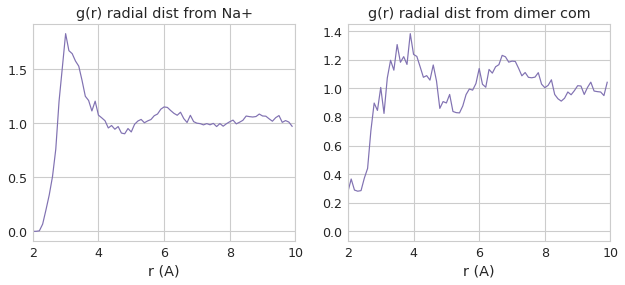

In [33]:
# plotting g(r)s
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(gr_loc[:,0], gr_loc[:,1], 'C3')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from Na+')
plt.subplot(1,3,2)
plt.plot(gr_dimer_loc[:,0], gr_dimer_loc[:,1], 'C3')
plt.xlim([2,10])
plt.xlabel('r (A)')
plt.title('g(r) radial dist from dimer com')
# plt.subplot(1,3,3)
# plt.plot(gr_min_loc[:,0], gr_min_loc[:,1])
# plt.xlim([2,10])
# plt.xlabel('r (A)')
# plt.title('g(r) for Na1 closest to neighboring Ar')

In [34]:
# radial distr fxn using radial distance and averaging over both Na's, loc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_loc = np.zeros([len(bins_radial_na),3])

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na_loc[i,0], e_com_loc[i]), lib.dist(na_loc[i,1], e_com_loc[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_loc[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_loc[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_loc[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_loc[my_ind,1] += 1

rho = 1600/(43.8332180561224**3)
for j in range(len(gr_loc)):
    V1 = 4*np.pi/3 * bins_radial_na[j]**3
    V2 = 4*np.pi/3 * (bins_radial_na[j]+dr)**3
    gr_loc[j,1:] /= (V2-V1)*rho
gr_loc[:,1:] /= len(na_loc)
gr_loc[:,0] = bins_radial_na

Text(0.5,1,'g(r) radial dist from Na+')

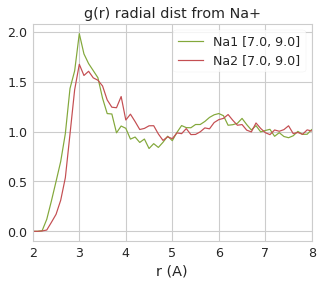

In [35]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr_loc[:,0], gr_loc[:,1], 'C1', label='Na1 [7.0, 9.0]')
plt.plot(gr_loc[:,0], gr_loc[:,2], 'C2', label='Na2 [7.0, 9.0]')
plt.xlim([2,8])
plt.xlabel('r (A)')
plt.legend(loc=1)
plt.title('g(r) radial dist from Na+')

Text(0.5,1,'g(r) radial dist from Na+')

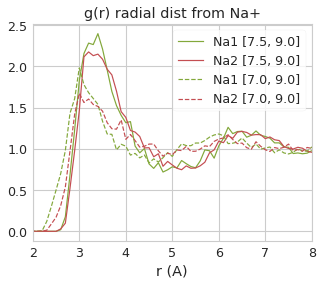

In [37]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C1', label='Na1 [7.5, 9.0]')
plt.plot(gr_cage[:,0], gr_cage[:,2], 'C2', label='Na2 [7.5, 9.0]')
plt.plot(gr_loc[:,0], gr_loc[:,1], 'C1--', label='Na1 [7.0, 9.0]')
plt.plot(gr_loc[:,0], gr_loc[:,2], 'C2--', label='Na2 [7.0, 9.0]')
plt.xlim([2,8])
plt.xlabel('r (A)')
plt.legend(loc=1)
plt.title('g(r) radial dist from Na+')

2840.0
1716.0
4727.0


Text(0,0.5,'Prob Distribution')

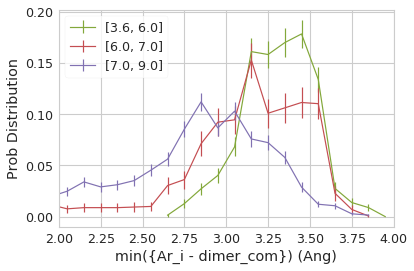

In [8]:
# distribiton of Ar-dimer_com distance
ar_dimer_fc = [np.min(np.sqrt((ar_fc[i,:,0]-(na_fc[i,0,0]+na_fc[i,1,0])/2)**2 + (ar_fc[i,:,1]-(na_fc[i,0,1]+na_fc[i,1,1])/2)**2
            + (ar_fc[i,:,2]-(na_fc[i,0,2]+na_fc[i,1,2])/2)**2)) for i in range(len(e_com_fc))]
ar_dimer_cage = [np.min(np.sqrt((ar_cage[i,:,0]-(na_cage[i,0,0]+na_cage[i,1,0])/2)**2 + (ar_cage[i,:,1]-(na_cage[i,0,1]+na_cage[i,1,1])/2)**2
            + (ar_cage[i,:,2]-(na_cage[i,0,2]+na_cage[i,1,2])/2)**2)) for i in range(len(e_com_cage))]
ar_dimer_loc = [np.min(np.sqrt((ar_loc[i,:,0]-(na_loc[i,0,0]+na_loc[i,1,0])/2)**2 + (ar_loc[i,:,1]-(na_loc[i,0,1]+na_loc[i,1,1])/2)**2
            + (ar_loc[i,:,2]-(na_loc[i,0,2]+na_loc[i,1,2])/2)**2)) for i in range(len(e_com_loc))]

count_ar_dimer_fc = genDistr(ar_dimer_fc)
count_ar_dimer_cage = genDistr(ar_dimer_cage)
count_ar_dimer_loc = genDistr(ar_dimer_loc)

plt.figure(figsize=(6,4))
plt.errorbar(count_ar_dimer_fc[:,0], count_ar_dimer_fc[:,1], yerr=count_ar_dimer_fc[:,2], color='C1', label='[3.6, 6.0]')
plt.errorbar(count_ar_dimer_cage[:,0], count_ar_dimer_cage[:,1], yerr=count_ar_dimer_cage[:,2], color='C2', label='[6.0, 7.0]')
plt.errorbar(count_ar_dimer_loc[:,0], count_ar_dimer_loc[:,1], yerr=count_ar_dimer_loc[:,2], color='C3', label='[7.0, 9.0]')
plt.legend(loc=2)
plt.xlim([2.0, 4.0])
plt.xlabel('min({Ar_i - dimer_com}) (Ang)')
plt.ylabel('Prob Distribution')

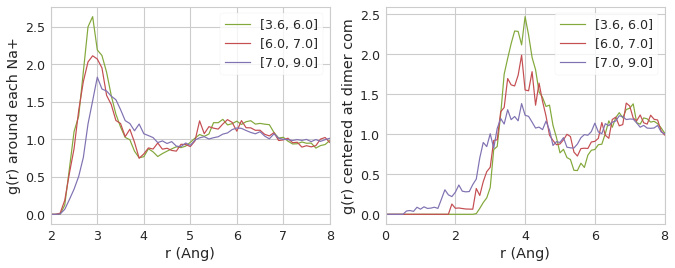

In [34]:
# g(r) centered at each Na+ and centered at dimer com
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(gr_fc[:,0], gr_fc[:,1], 'C1', label='[3.6, 6.0]')
plt.plot(gr_cage[:,0], gr_cage[:,1], 'C2', label='[6.0, 7.0]')
plt.plot(gr_loc[:,0], gr_loc[:,1], 'C3', label='[7.0, 9.0]')
plt.xlim([2,8])
plt.ylabel('g(r) around each Na+')
plt.xlabel('r (Ang)')
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.plot(gr_dimer_fc[:,0], gr_dimer_fc[:,1], 'C1', label='[3.6, 6.0]')
plt.plot(gr_dimer_cage[:,0], gr_dimer_cage[:,1], 'C2', label='[6.0, 7.0]')
plt.plot(gr_dimer_loc[:,0], gr_dimer_loc[:,1], 'C3', label='[7.0, 9.0]')
plt.xlim([0,8])
plt.ylabel('g(r) centered at dimer com')
plt.xlabel('r (Ang)')
plt.legend(loc=1)

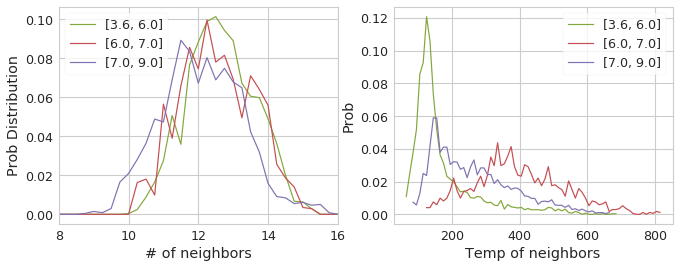

In [38]:
# Putting together plots of # neighbors and g(r) for each window
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(neighbor_counts_fc[:,0], neighbor_counts_fc[:,1]/np.sum(neighbor_counts_fc[:,1]), 'C1', label='[3.6, 6.0]')
plt.plot(neighbor_counts_cage[:,0], neighbor_counts_cage[:,1]/np.sum(neighbor_counts_cage[:,1]), 'C2', label='[6.0, 7.0]')
plt.plot(neighbor_counts_loc[:,0], neighbor_counts_loc[:,1]/np.sum(neighbor_counts_loc[:,1]), 'C3', label='[7.0, 9.0]')
plt.ylabel('Prob Distribution')
plt.xlabel('# of neighbors')
plt.xlim([8,16])
plt.legend(loc=2)

plt.subplot(1,2,2)
plt.plot(T_distr_fc[:,0], T_distr_fc[:,1], 'C1', label='[3.6, 6.0]')
plt.plot(T_distr_cage[:,0], T_distr_cage[:,1], 'C2', label='[6.0, 7.0]')
plt.plot(T_distr_loc[:,0], T_distr_loc[:,1], 'C3', label='[7.0, 9.0]')
plt.ylabel('Prob')
plt.xlabel('Temp of neighbors')
plt.legend(loc=1)

In [7]:
na_fc = np.load('solvent_environments/non_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/non_eqb_ar_fc.npy')

na_cage = np.load('solvent_environments/non_eqb_na_cage.npy')
ar_cage = np.load('solvent_environments/non_eqb_ar_cage.npy')

na_loc = np.load('solvent_environments/non_eqb_na_loc.npy')
ar_loc = np.load('solvent_environments/non_eqb_ar_loc.npy')

In [8]:
# counting number of Ar in the intramolecular region for ranges [3.6, 6.0], [6.0, 7.0]
r_cutoff = 3.0; kappa = 10

counts_intra_fc = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='dimer') - na_fc[i,0,:]
    bond_ax = na_fc[i,1,:] - na_fc[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
#    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-1.8)) + 1)
    
    counts_intra_fc[i] = np.dot(radial_filter, axial_filter)

counts_intra_cage = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='dimer') - na_cage[i,0,:]
    bond_ax = na_cage[i,1,:] - na_cage[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
#    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-1.8)) + 1)
    
    counts_intra_cage[i] = np.dot(radial_filter, axial_filter)
    
# counts_intra_loc = np.zeros(len(na_loc))
# for i in range(len(na_loc)):
#     closest_Ar = lib.closestAr(na_loc[i], ar_loc[i], n_cutoff=20, option='dimer') - na_loc[i,0,:]
#     bond_ax = na_loc[i,1,:] - na_loc[i,0,:]
#     bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
#     bond_ax /= bond_dist
    
#     axial_dist = np.dot(closest_Ar, bond_ax)
#     radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
#     radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
#     axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
#     counts_intra_loc[i] = np.dot(radial_filter, axial_filter)

2840.0
1716.0
0.8619718309859155 1.6368006993006996


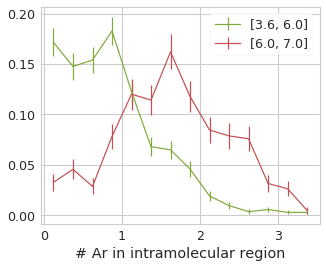

In [18]:
# integrate over cylinder r_cutoff = 3.0; kappa = 10
distr_intra_fc = genDistr(counts_intra_fc, spacing=0.25)
distr_intra_cage = genDistr(counts_intra_cage, spacing=0.25)
# distr_intra_loc = genDistr(counts_intra_loc, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra_fc[:,0], distr_intra_fc[:,1], yerr=distr_intra_fc[:,2], color='C1', label='[3.6, 6.0]')
plt.errorbar(distr_intra_cage[:,0], distr_intra_cage[:,1], yerr=distr_intra_cage[:,2], color='C2', label='[6.0, 7.0]')
# plt.errorbar(distr_intra_loc[:,0], distr_intra_loc[:,1], yerr=distr_intra_loc[:,2], color='C3', label='[7.0, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra_fc[:,0], distr_intra_fc[:,1]), np.dot(distr_intra_cage[:,0], distr_intra_cage[:,1]))